# Applied Econometrics - term paper - Pavlína Křenková and Ivan Kotlan - QUALCOMM Inc

In [1]:
shhh = suppressPackageStartupMessages #load quietly
shhh(library(tseries))
shhh(library(forecast))
shhh(library(moments))
shhh(library(aTSA))
shhh(library(rugarch))
shhh(library(tidyverse))
shhh(library(lubridate))
shhh(library(zoo))
shhh(library(dplyr))

## Data load

In [2]:
files = unzip("data_term_paper_AE_2024.zip", list = TRUE)
print(files$Name)

 [1] "data_term_paper_AE_2023/"                          
 [2] "data_term_paper_AE_2023/Description of assets.xlsx"
 [3] "data_term_paper_AE_2023/SeparateTables/"           
 [4] "data_term_paper_AE_2023/SeparateTables/AAPL.csv"   
 [5] "data_term_paper_AE_2023/SeparateTables/BAC.csv"    
 [6] "data_term_paper_AE_2023/SeparateTables/C.csv"      
 [7] "data_term_paper_AE_2023/SeparateTables/CMCSA.csv"  
 [8] "data_term_paper_AE_2023/SeparateTables/CVX.csv"    
 [9] "data_term_paper_AE_2023/SeparateTables/DIS.csv"    
[10] "data_term_paper_AE_2023/SeparateTables/GE.csv"     
[11] "data_term_paper_AE_2023/SeparateTables/HD.csv"     
[12] "data_term_paper_AE_2023/SeparateTables/IBM.csv"    
[13] "data_term_paper_AE_2023/SeparateTables/JNJ.csv"    
[14] "data_term_paper_AE_2023/SeparateTables/JPM.csv"    
[15] "data_term_paper_AE_2023/SeparateTables/KO.csv"     
[16] "data_term_paper_AE_2023/SeparateTables/MCD.csv"    
[17] "data_term_paper_AE_2023/SeparateTables/MRK.csv"    
[18] "data_ter

In [3]:
qcom_data_path = unzip("data_term_paper_AE_2024.zip", files = "data_term_paper_AE_2023/SeparateTables/QCOM.csv" , exdir = tempdir())
qcom_data = read.csv(qcom_data_path)
head(qcom_data)
tail(qcom_data)

,Index,QCOM.Close
,<chr>,<dbl>
1,2010-01-04,46.94
2,2010-01-05,48.07
3,2010-01-06,47.60
4,2010-01-07,48.98
5,2010-01-08,49.47
6,2010-01-11,49.29


,Index,QCOM.Close
,<chr>,<dbl>
3310,2023-02-27,123.42
3311,2023-02-28,123.53
3312,2023-03-01,123.68
3313,2023-03-02,123.78
3314,2023-03-03,123.60
3315,2023-03-06,122.41


In [4]:
# check missing dates
library(tidyverse)
library(lubridate)
library(zoo)

data <- qcom_data %>% 
  mutate(Date = as.Date(Index))

date_sequence <- seq(min(data$Date), max(data$Date), by="day")

full_dates <- tibble(Date = date_sequence)
check_dates <- full_dates %>%
  left_join(data, by = "Date")
missing_dates <- check_dates %>%
  filter(is.na(QCOM.Close))
print(missing_dates)

# A tibble: 1,495 × 3
   Date       Index QCOM.Close
   <date>     <chr>      <dbl>
 1 2010-01-09 NA            NA
 2 2010-01-10 NA            NA
 3 2010-01-16 NA            NA
 4 2010-01-17 NA            NA
 5 2010-01-18 NA            NA
 6 2010-01-23 NA            NA
 7 2010-01-24 NA            NA
 8 2010-01-30 NA            NA
 9 2010-01-31 NA            NA
10 2010-02-06 NA            NA
# ℹ 1,485 more rows


daily closing prices data, let's make logreturns

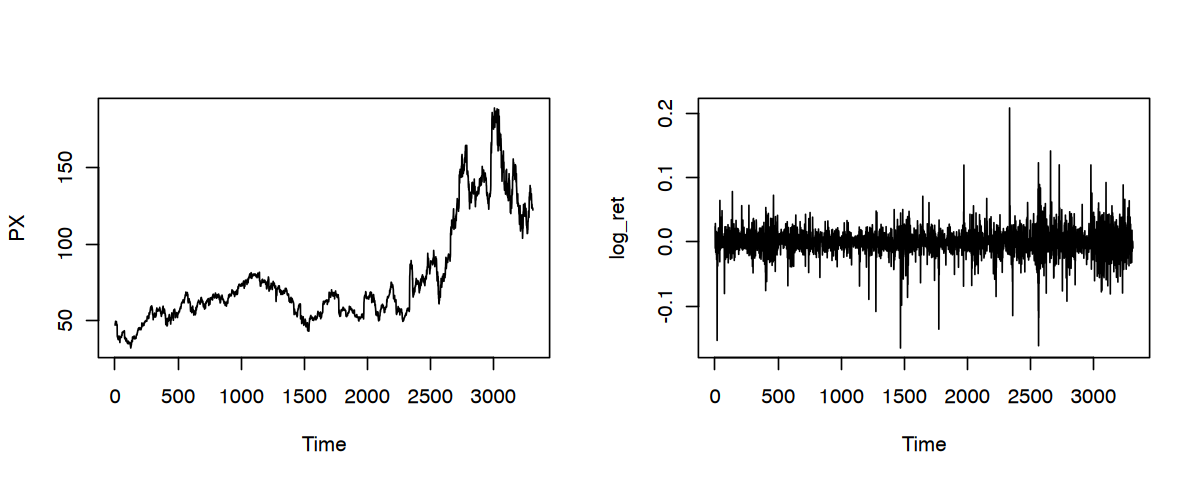

In [5]:
price <- qcom_data$QCOM.Close # extract the prices
log_ret <- diff(log(price)) # compute the log returns

## plot the data
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))
plot.ts(price, ylab = "PX")
plot.ts(log_ret)

In [6]:
summary(price)
length(price)
summary(log_ret)
length(log_ret)
kurtosis(log_ret)
skewness(log_ret)
kurtosis(price)
skewness(price)
tseries::adf.test(price)
tseries::adf.test(log_ret)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  31.96   55.35   65.53   77.28   80.03  189.28 

[1] 3315

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1654713 -0.0089342  0.0003957  0.0002892  0.0096447  0.2086990 

[1] 3314

[1] 14.01898

[1] -0.1523311

[1] 3.981698

[1] 1.395756


	Augmented Dickey-Fuller Test

data:  price
Dickey-Fuller = -2.3638, Lag order = 14, p-value = 0.4243
alternative hypothesis: stationary


Warning message in tseries::adf.test(log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret
Dickey-Fuller = -15.666, Lag order = 14, p-value = 0.01
alternative hypothesis: stationary


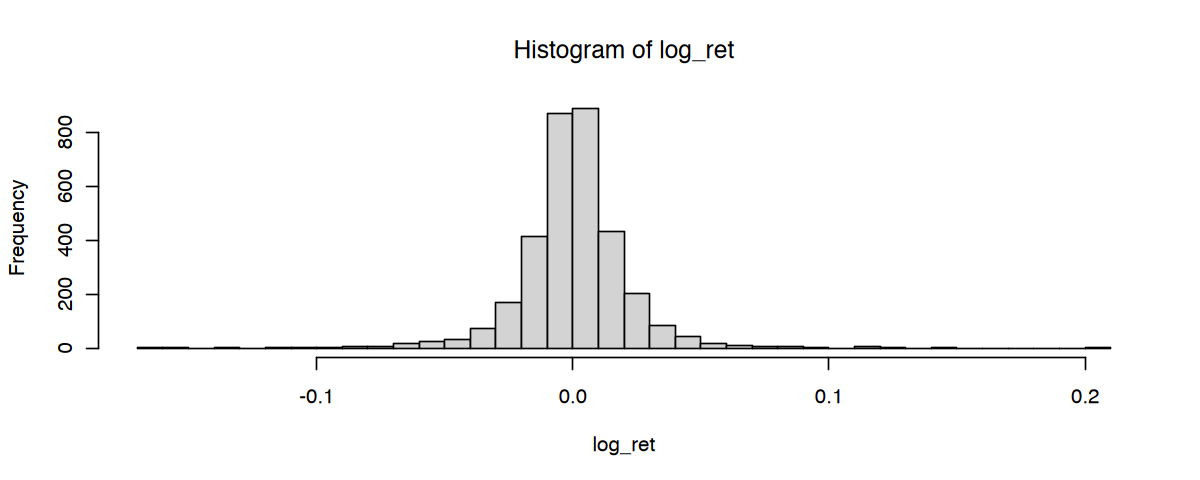

In [7]:
hist(log_ret, breaks = 30)

## Some mean model

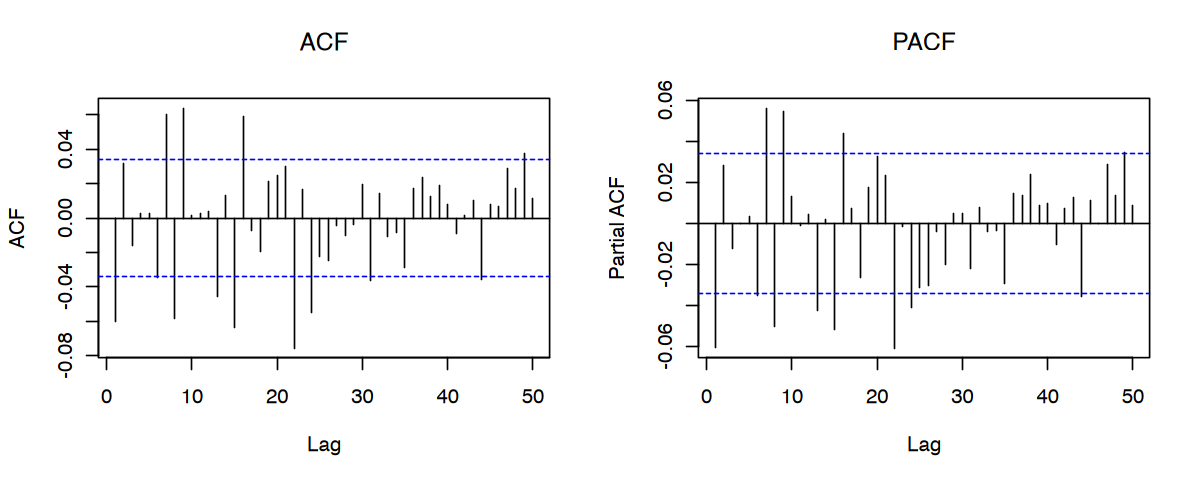

In [8]:
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))
Acf(log_ret, lag.max = 50, main="ACF")
Pacf(log_ret, lag.max = 50, main="PACF")

Series: log_ret 
ARIMA(1,0,1) with zero mean 

Coefficients:
          ar1     ma1
      -0.4232  0.3624
s.e.   0.1612  0.1652

sigma^2 = 0.0004356:  log likelihood = 8121.71
AIC=-16237.41   AICc=-16237.4   BIC=-16219.09

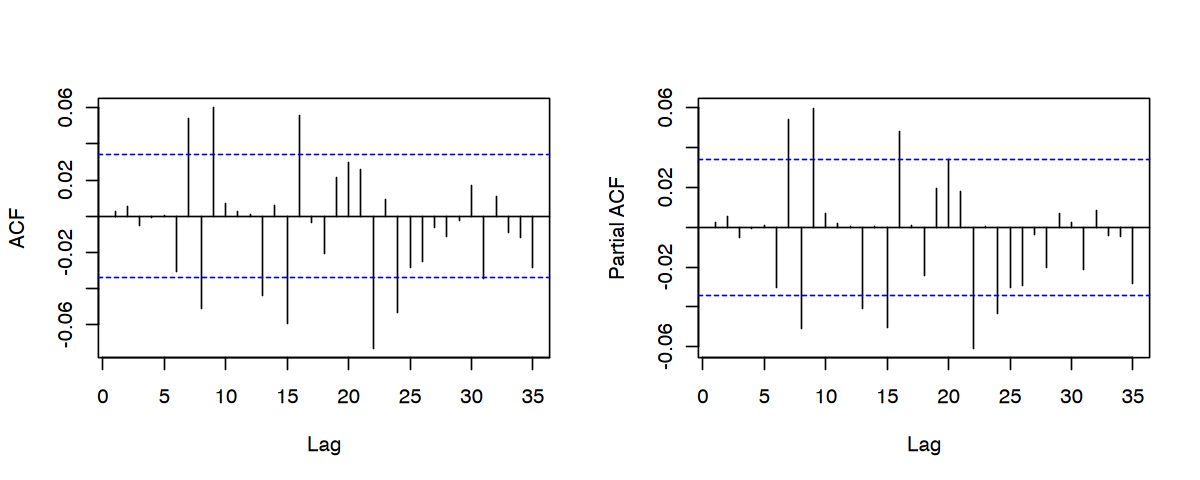

In [9]:
ar_auto = auto.arima(log_ret)
ar_auto
par(mfrow=c(1,2))
Acf(ar_auto$residuals, main = NA)
Pacf(ar_auto$residuals, main = NA)

In [10]:
resid <- ar_auto$residuals 
jarque.bera.test(resid)


	Jarque Bera Test

data:  resid
X-squared = 16614, df = 2, p-value < 2.2e-16


auto arima suggests (1,0,1) but the values are quite close, CIs overlap. They cancel out and we might be overfitting.


Call:
arima(x = log_ret, order = c(0, 0, 0))

Coefficients:
      intercept
          3e-04
s.e.      4e-04

sigma^2 estimated as 0.0004372:  log likelihood = 8114.64,  aic = -16225.29

intercept 
0.0002892293

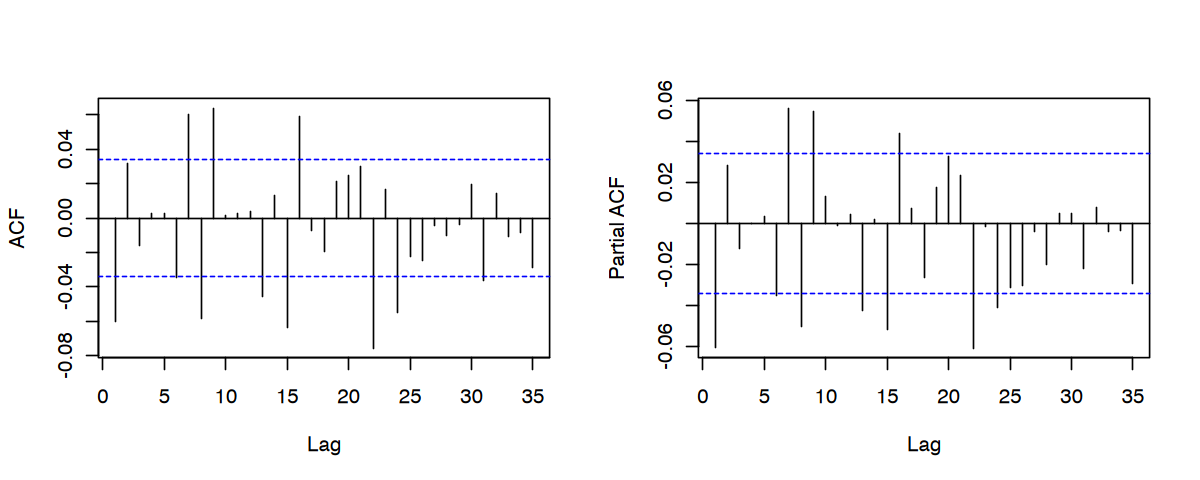

In [11]:
ar_00 <- arima(log_ret, order = c(0, 0, 0))
ar_00
ar_00$coef
par(mfrow=c(1,2))
Acf(ar_00$residuals, main = NA)
Pacf(ar_00$residuals, main = NA)

In [12]:
resid <- ar_00$residuals 
jarque.bera.test(resid)


	Jarque Bera Test

data:  resid
X-squared = 16779, df = 2, p-value < 2.2e-16



Call:
arima(x = log_ret, order = c(1, 0, 0))

Coefficients:
          ar1  intercept
      -0.0603      3e-04
s.e.   0.0173      3e-04

sigma^2 estimated as 0.0004356:  log likelihood = 8120.69,  aic = -16235.37

ar1     intercept 
-0.0603306352  0.0002885998

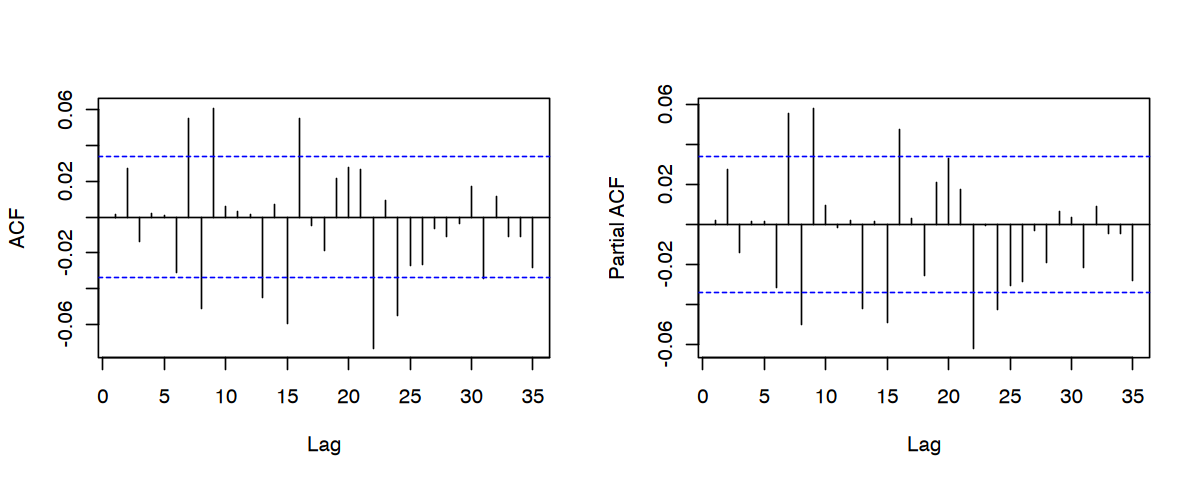

In [13]:
ar_10 <- arima(log_ret, order = c(1, 0, 0))
ar_10
ar_10$coef
par(mfrow=c(1,2))
Acf(ar_10$residuals, main = NA)
Pacf(ar_10$residuals, main = NA)

In [14]:
resid <- ar_10$residuals 
jarque.bera.test(resid)


	Jarque Bera Test

data:  resid
X-squared = 16851, df = 2, p-value < 2.2e-16



Call:
arima(x = log_ret, order = c(0, 0, 1))

Coefficients:
          ma1  intercept
      -0.0571      3e-04
s.e.   0.0169      3e-04

sigma^2 estimated as 0.0004357:  log likelihood = 8120.35,  aic = -16234.71

ma1     intercept 
-0.0570694371  0.0002892086

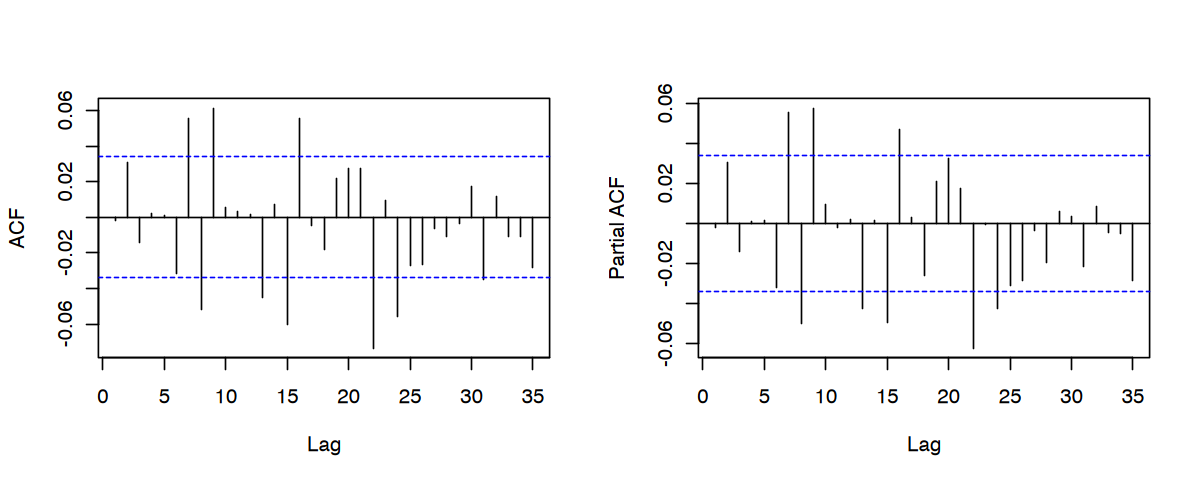

In [15]:
ar_01 <- arima(log_ret, order = c(0, 0, 1))
ar_01
ar_01$coef
par(mfrow=c(1,2))
Acf(ar_01$residuals, main = NA)
Pacf(ar_01$residuals, main = NA)

In [16]:
resid <- ar_01$residuals 
jarque.bera.test(resid)


	Jarque Bera Test

data:  resid
X-squared = 16890, df = 2, p-value < 2.2e-16


Series: log_ret 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
          ar1     ma1    ma2   mean
      -0.3785  0.3200  0.010  3e-04
s.e.   0.2490  0.2491  0.025  4e-04

sigma^2 = 0.0004358:  log likelihood = 8122.17
AIC=-16234.34   AICc=-16234.32   BIC=-16203.81

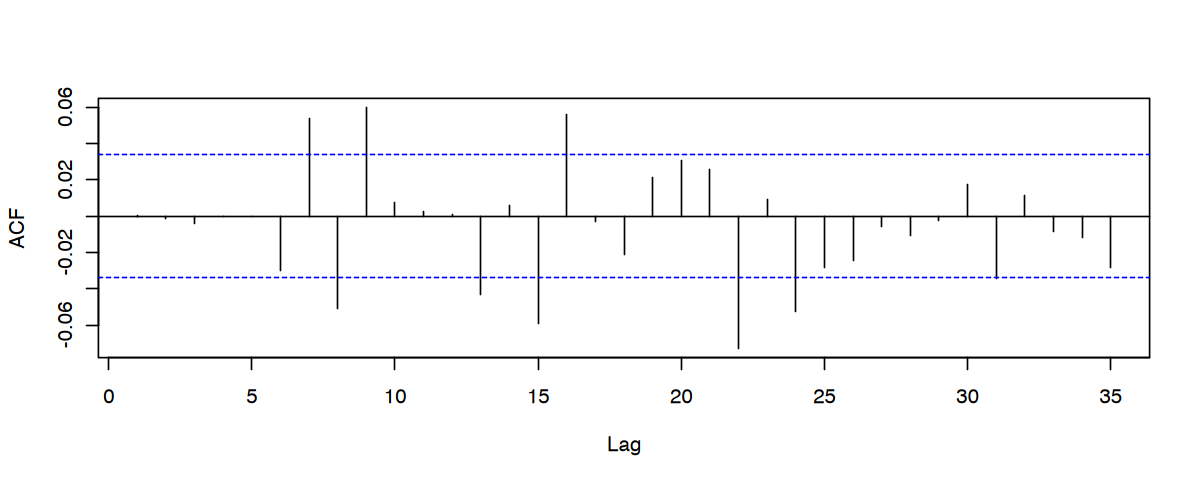

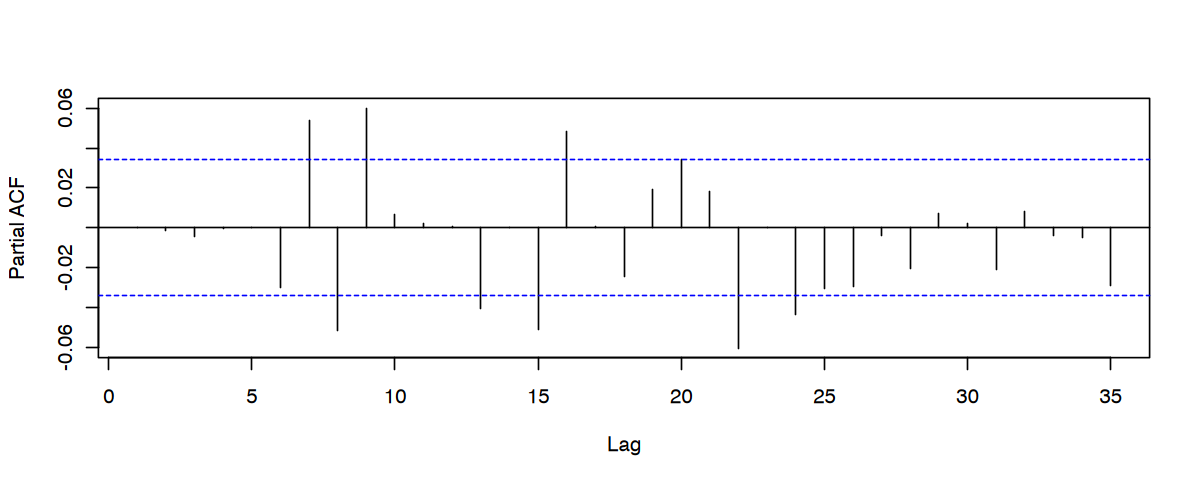

In [17]:
ar_12 <- Arima(log_ret, order = c(1, 0, 2))
ar_12
Acf(ar_12$residuals, main = NA)
Pacf(ar_12$residuals, main = NA)


Call:
arima(x = log_ret, order = c(1, 0, 1))

Coefficients:
          ar1     ma1  intercept
      -0.4404  0.3799      3e-04
s.e.   0.1532  0.1577      3e-04

sigma^2 estimated as 0.0004353:  log likelihood = 8122.05,  aic = -16236.09

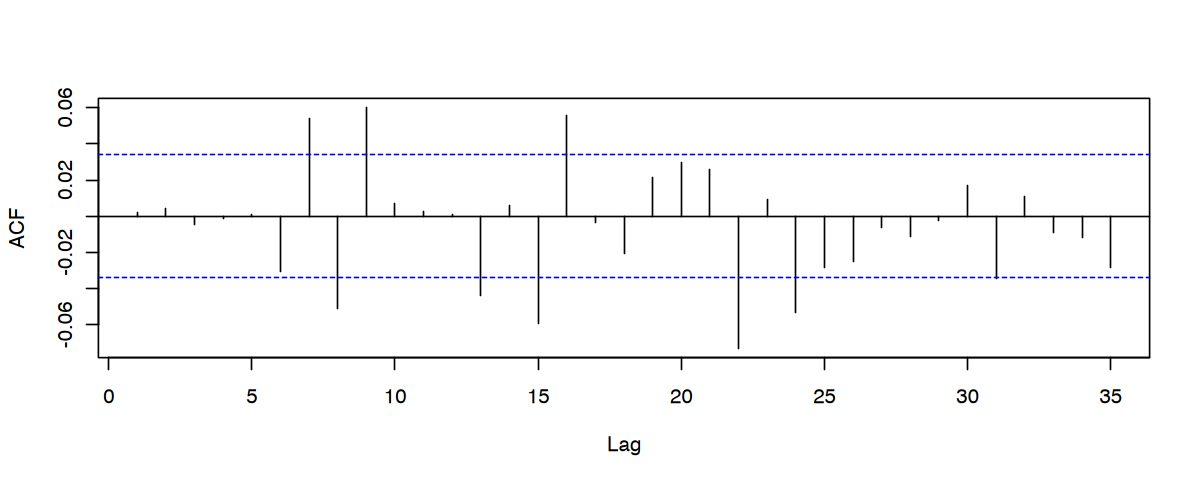

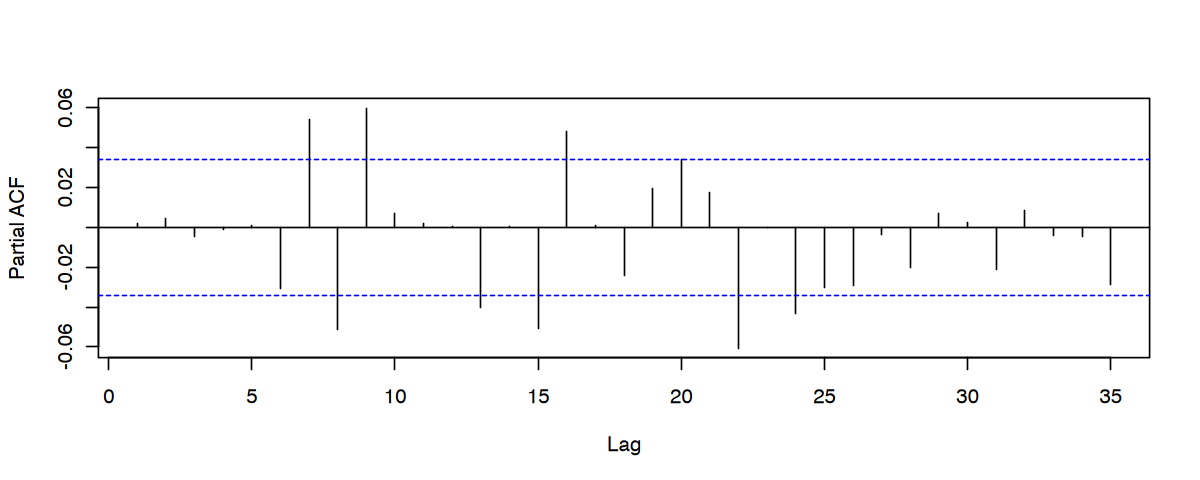

In [18]:
ar_11 <- arima(log_ret, order = c(1, 0, 1))
ar_11
Acf(ar_11$residuals, main = NA)
Pacf(ar_11$residuals, main = NA)

## Residuals Check

In [19]:
resid <- ar_00$residuals

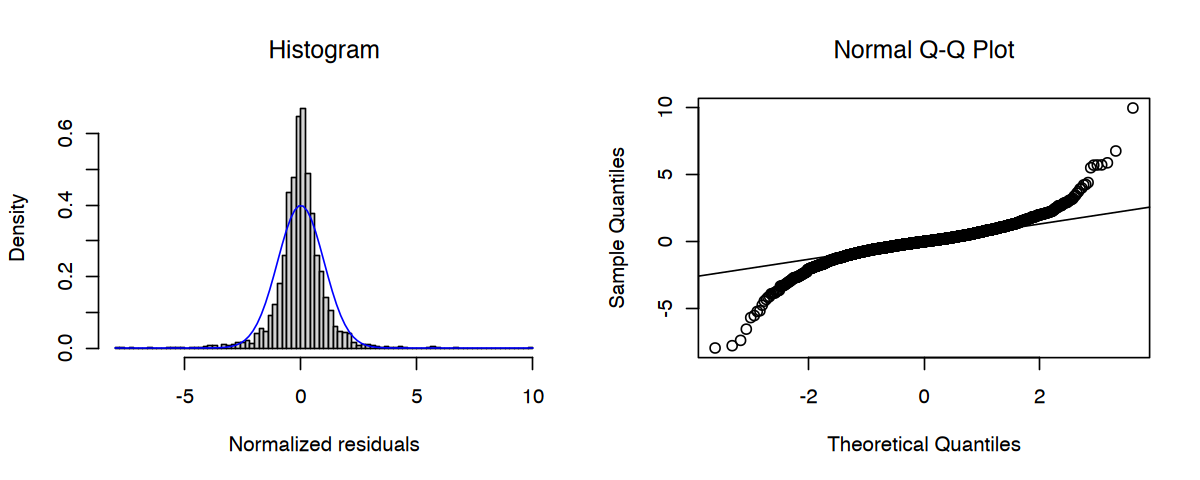

In [20]:
resid_norm <- resid/sqrt(ar_00$sigma2)

par(mfrow = c(1,2))
hist(resid_norm, prob = TRUE, breaks = 100, xlab = "Normalized residuals", main="Histogram") # clearly do not follow the normal
# this is because the residuals are just the returns
curve(dnorm(x, mean = 0, sd = 1), col="blue", lwd = 1, add = TRUE)
qqnorm(resid_norm)
qqline(resid_norm)

residuals not normal at all. let's test it formally

In [21]:
jarque.bera.test(resid)  # strongly rejecting normality, presumably fat tails


	Jarque Bera Test

data:  resid
X-squared = 16779, df = 2, p-value < 2.2e-16


In [22]:
kurtosis(resid)
skewness(resid)

[1] 14.01898

[1] -0.1523311

In [23]:
resid_sqrd <- resid^2

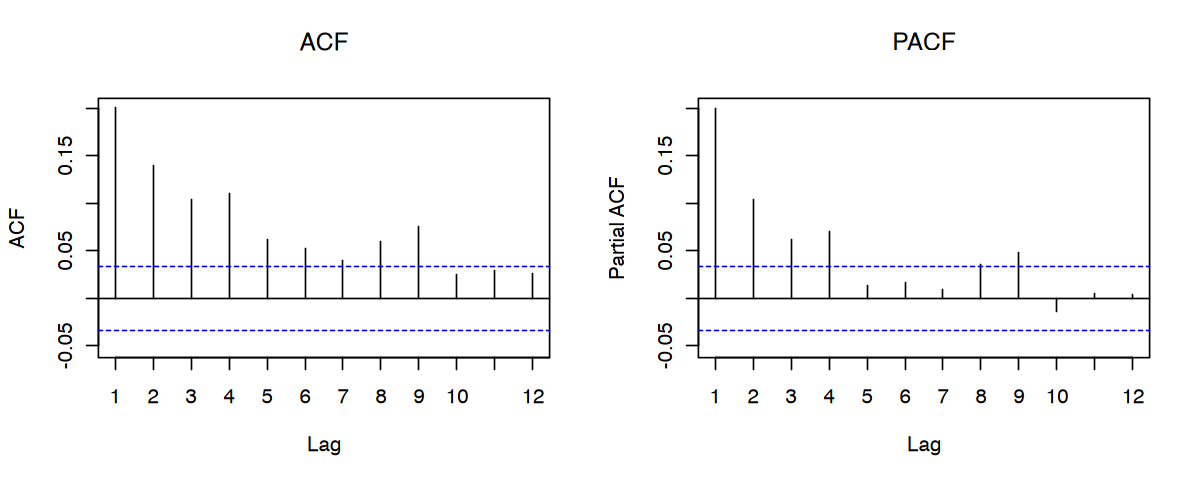

In [24]:
par(mfrow=c(1,2))
Acf(resid_sqrd, lag.max = 12, main="ACF")
Pacf(resid_sqrd, lag.max = 12, main="PACF")

Dependence in the squared residuals suggests that there is some serial structure in the second moment of the series - which was also suggested by the volatility clusters observed in the plot. Solution: employ volatility models (GARCH type of models, etc.) to properly model the associated risk.

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order  PQ p.value
[1,]     4 274       0
[2,]     8 313       0
[3,]    12 339       0
[4,]    16 355       0
[5,]    20 366       0
[6,]    24 382       0
Lagrange-Multiplier test: 
     order   LM p.value
[1,]     4 5493       0
[2,]     8 2617       0
[3,]    12 1688       0
[4,]    16 1255       0
[5,]    20  920       0
[6,]    24  756       0


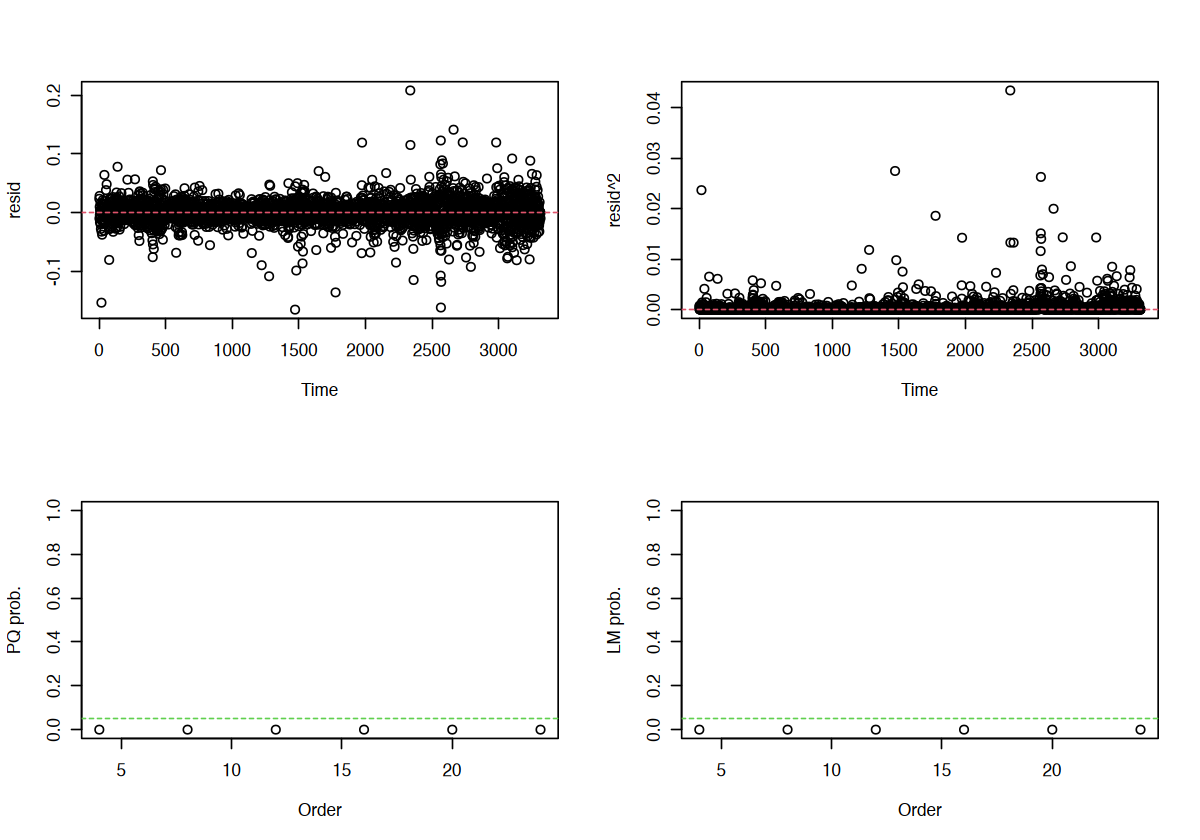

In [25]:
options(repr.plot.width=10, repr.plot.height=7)
# portmanteau-Q test (similar to Ljung-Box test) and ARCH-LM test:
arch.test(ar_00)

In [26]:
Box.test(resid^2,  lag = 12, type = c("Ljung-Box")) # reject H0 of no autocorrelations - correlation in volatility and ARCH effects
# ARCH effects = clustering of volatility


	Box-Ljung test

data:  resid^2
X-squared = 339.24, df = 12, p-value < 2.2e-16


## ARCH(1)

In [27]:
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), 
                     variance.model = list(garchOrder = c(3, 0)), distribution.model = "std")

# fit the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(3,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000577    0.000233   2.4719 0.013440
omega   0.000197    0.000019  10.1401 0.000000
alpha1  0.301121    0.055560   5.4197 0.000000
alpha2  0.314919    0.059852   5.2617 0.000000
alpha3  0.195895    0.047515   4.1228 0.000037
shape   3.243412    0.199333  16.2714 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000577    0.000211   2.7404 0.006137
omega   0.000197    0.000026   7.6069 0.000000
alpha1  0.301121    0.054839   5.4910 0.000000
alpha2  0.314919    0.062978   5.0005 0.000001
alpha3  0.195895    0.048849   4.0102 0.000061
shape   3.243412    0.212482  15.2644 0.000000

LogLikel

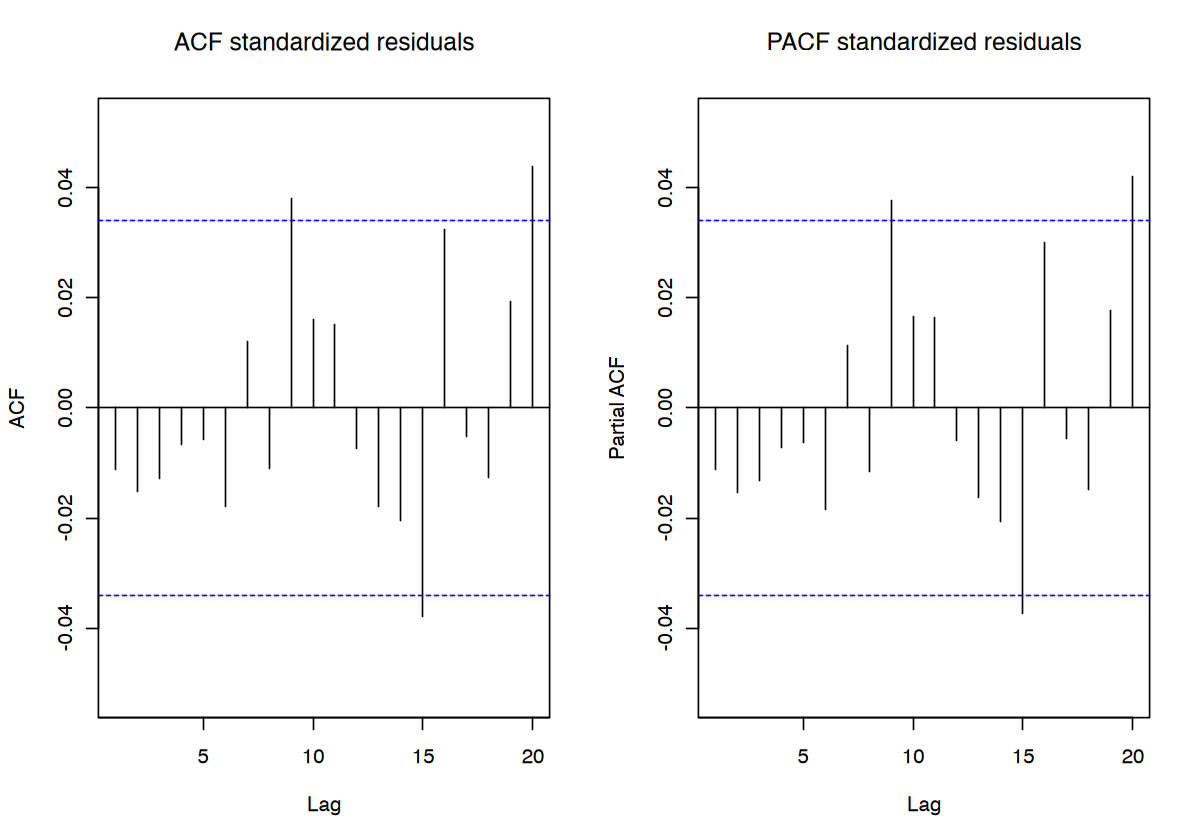

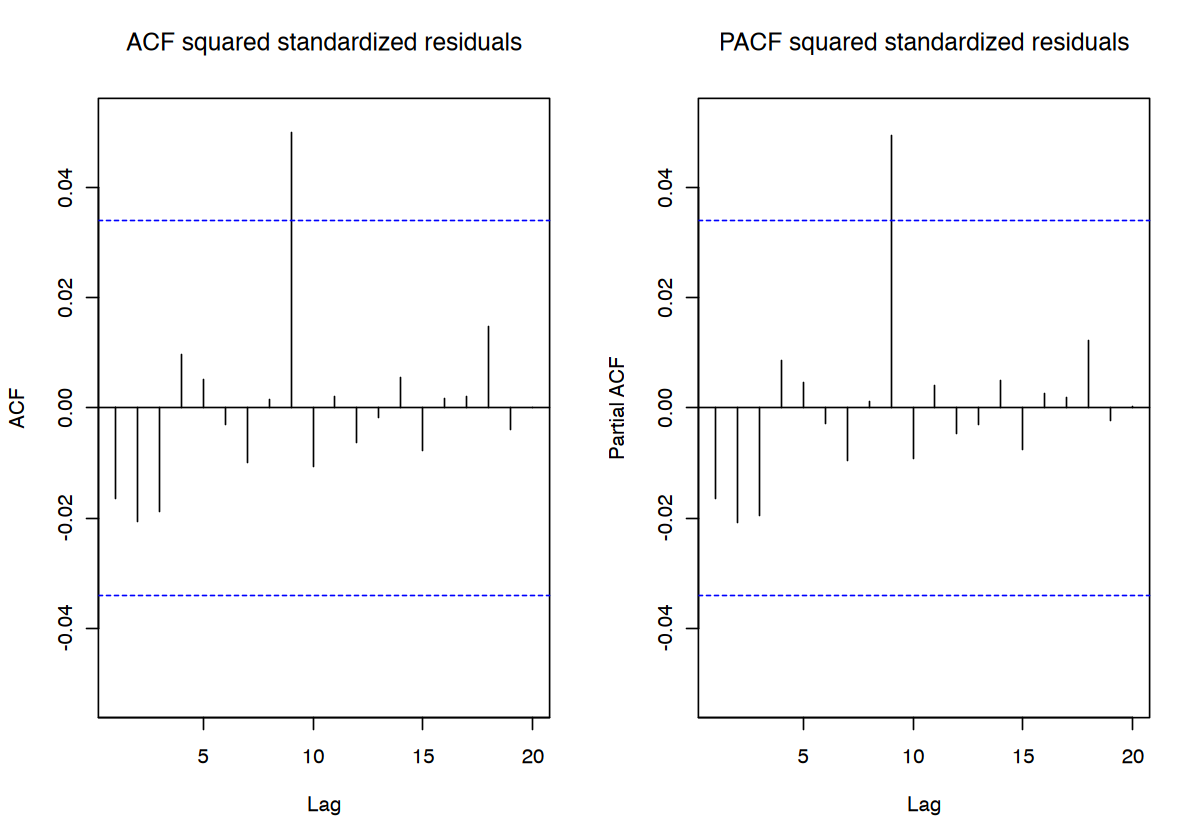

In [28]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

## * GARCH(1,1) - norm

In [29]:
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), 
                     variance.model = list(garchOrder = c(1, 1)))

# fit the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000327    0.000309   1.0604  0.28897
omega   0.000044    0.000007   6.5113  0.00000
alpha1  0.158843    0.024610   6.4544  0.00000
beta1   0.757643    0.030395  24.9264  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000327    0.000294   1.1144 0.265105
omega   0.000044    0.000020   2.1431 0.032103
alpha1  0.158843    0.062227   2.5526 0.010691
beta1   0.757643    0.079405   9.5414 0.000000

LogLikelihood : 8355.353 

Information Criteria
------------------------------------
                    
Akaike       -5.0400
Bayes        -5.0327
Shibata      -5.0400
Hannan-Quinn -5.0374

Weig

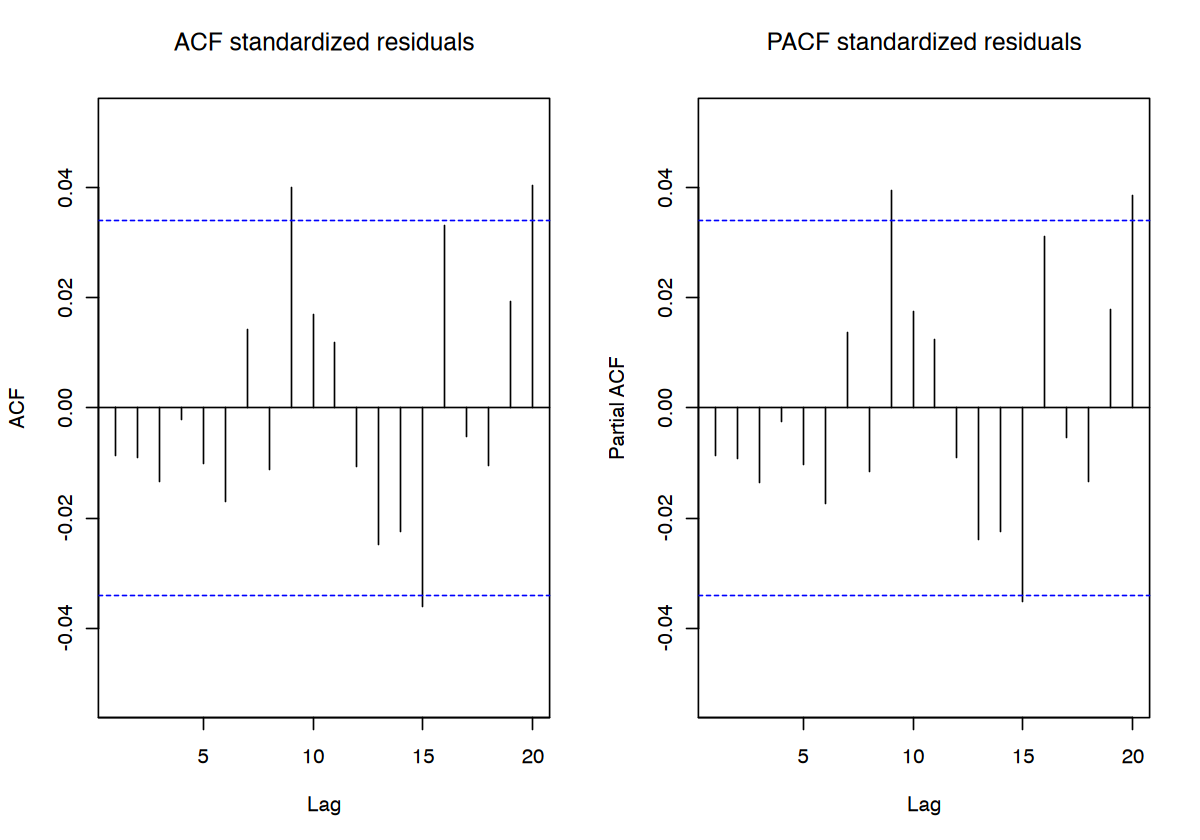

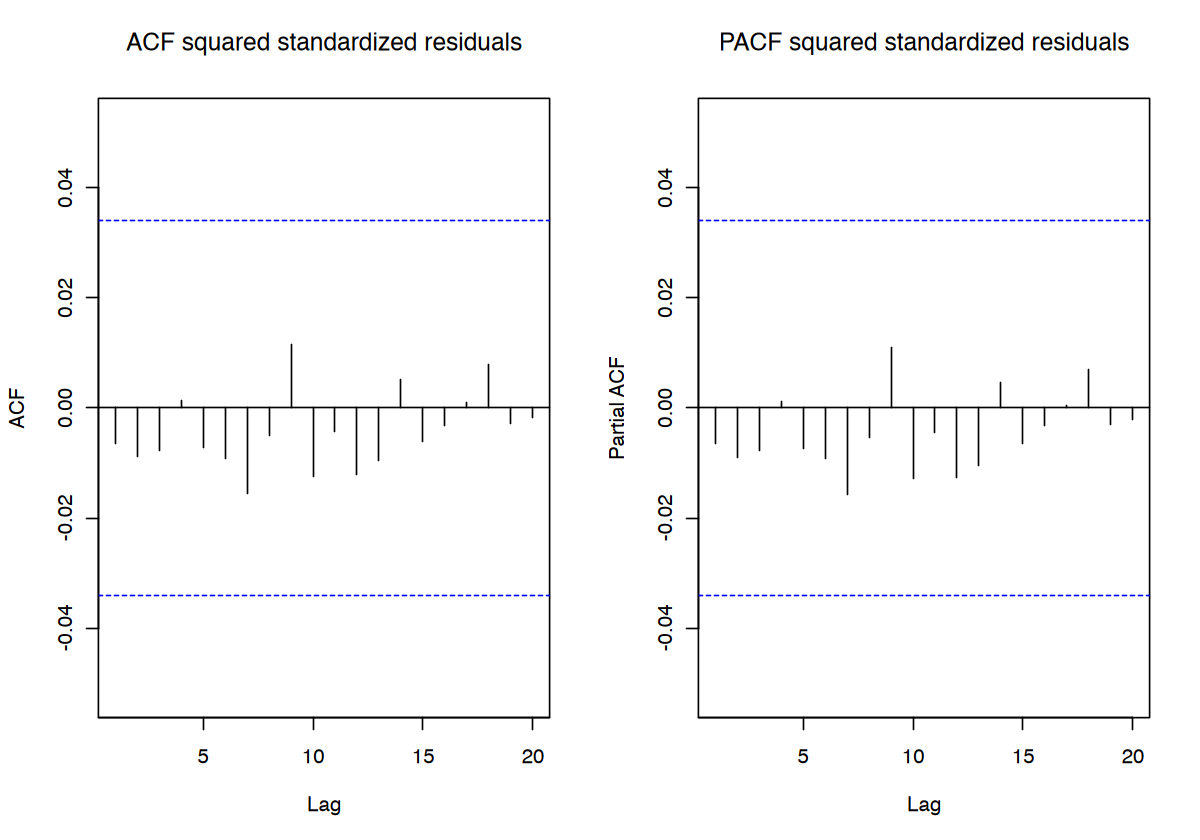

In [30]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

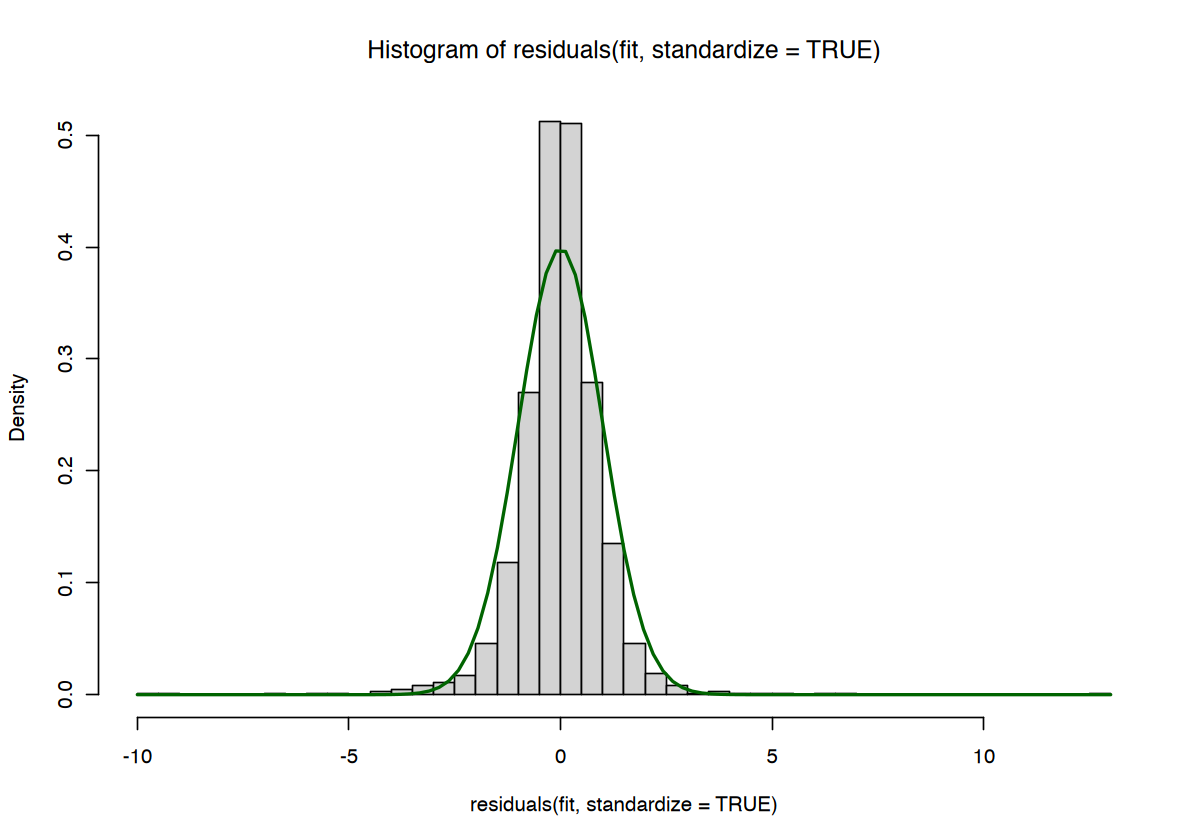

In [31]:
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

In [32]:
jarque.bera.test(residuals(fit, standardize = TRUE))


	Jarque Bera Test

data:  residuals(fit, standardize = TRUE)
X-squared = 41305, df = 2, p-value < 2.2e-16


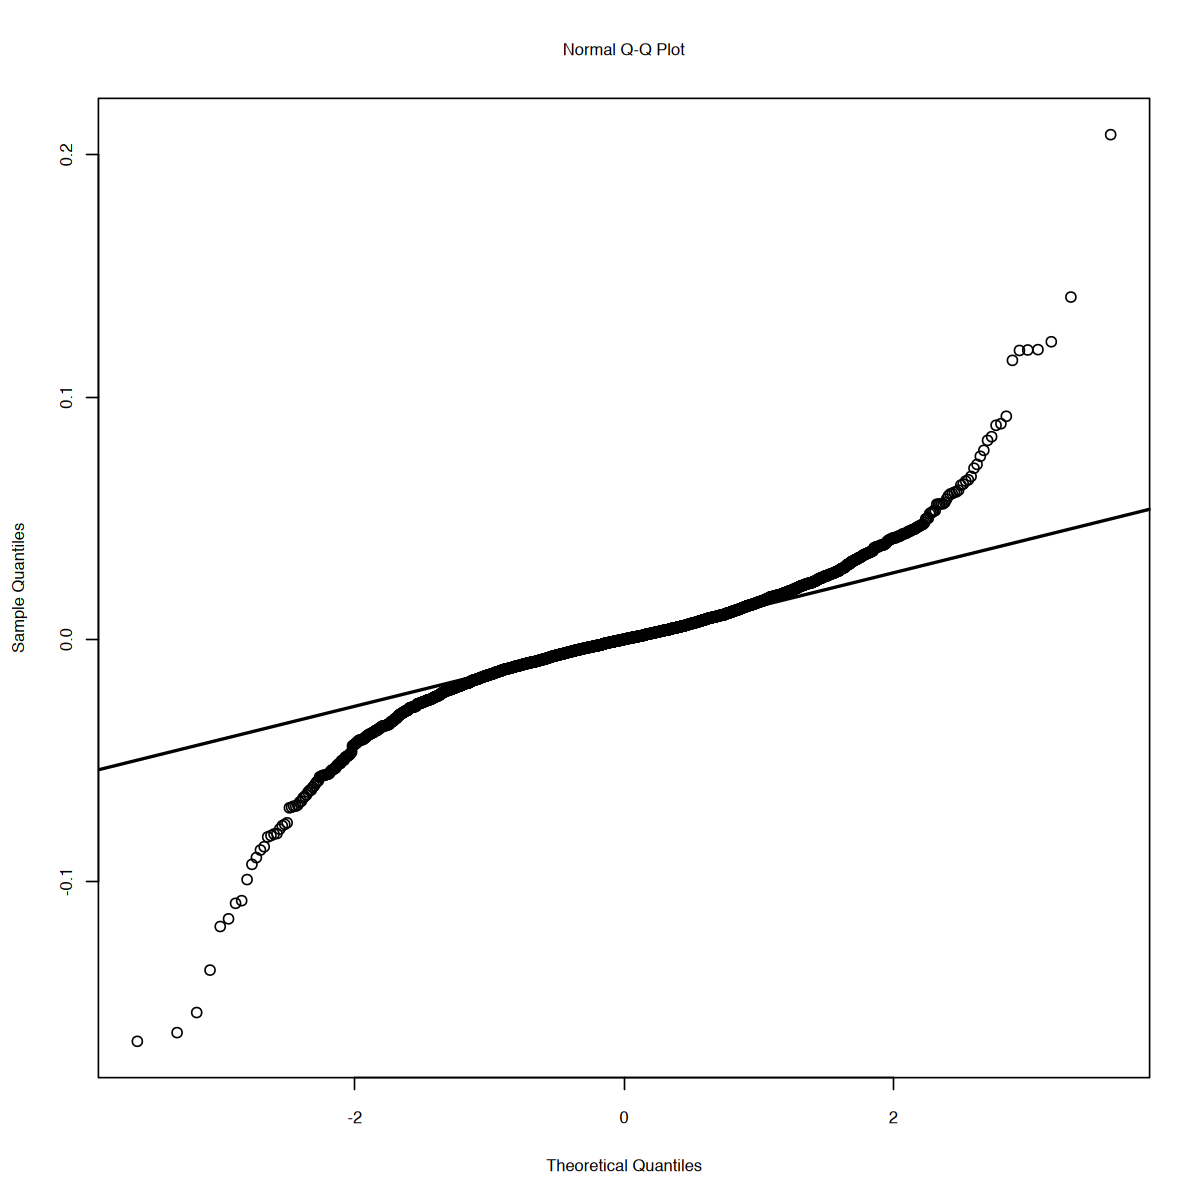

In [33]:
options(repr.plot.width=10, repr.plot.height=10)
qqnorm(residuals(fit), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8) 
qqline(residuals(fit), lwd = 2)

##  * GARCH(1,1) - t-dist

In [34]:
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), 
                     variance.model = list(garchOrder = c(1, 1)), distribution.model = "std")

# fit the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000232   2.3502 0.018765
omega   0.000012    0.000003   3.8171 0.000135
alpha1  0.122561    0.017206   7.1231 0.000000
beta1   0.867094    0.012514  69.2904 0.000000
shape   3.473609    0.101650  34.1721 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000211   2.5838 0.009771
omega   0.000012    0.000009   1.2838 0.199229
alpha1  0.122561    0.056487   2.1697 0.030029
beta1   0.867094    0.028945  29.9570 0.000000
shape   3.473609    0.730116   4.7576 0.000002

LogLikelihood : 8813.833 

Information Criteria
------------------------------------
                 

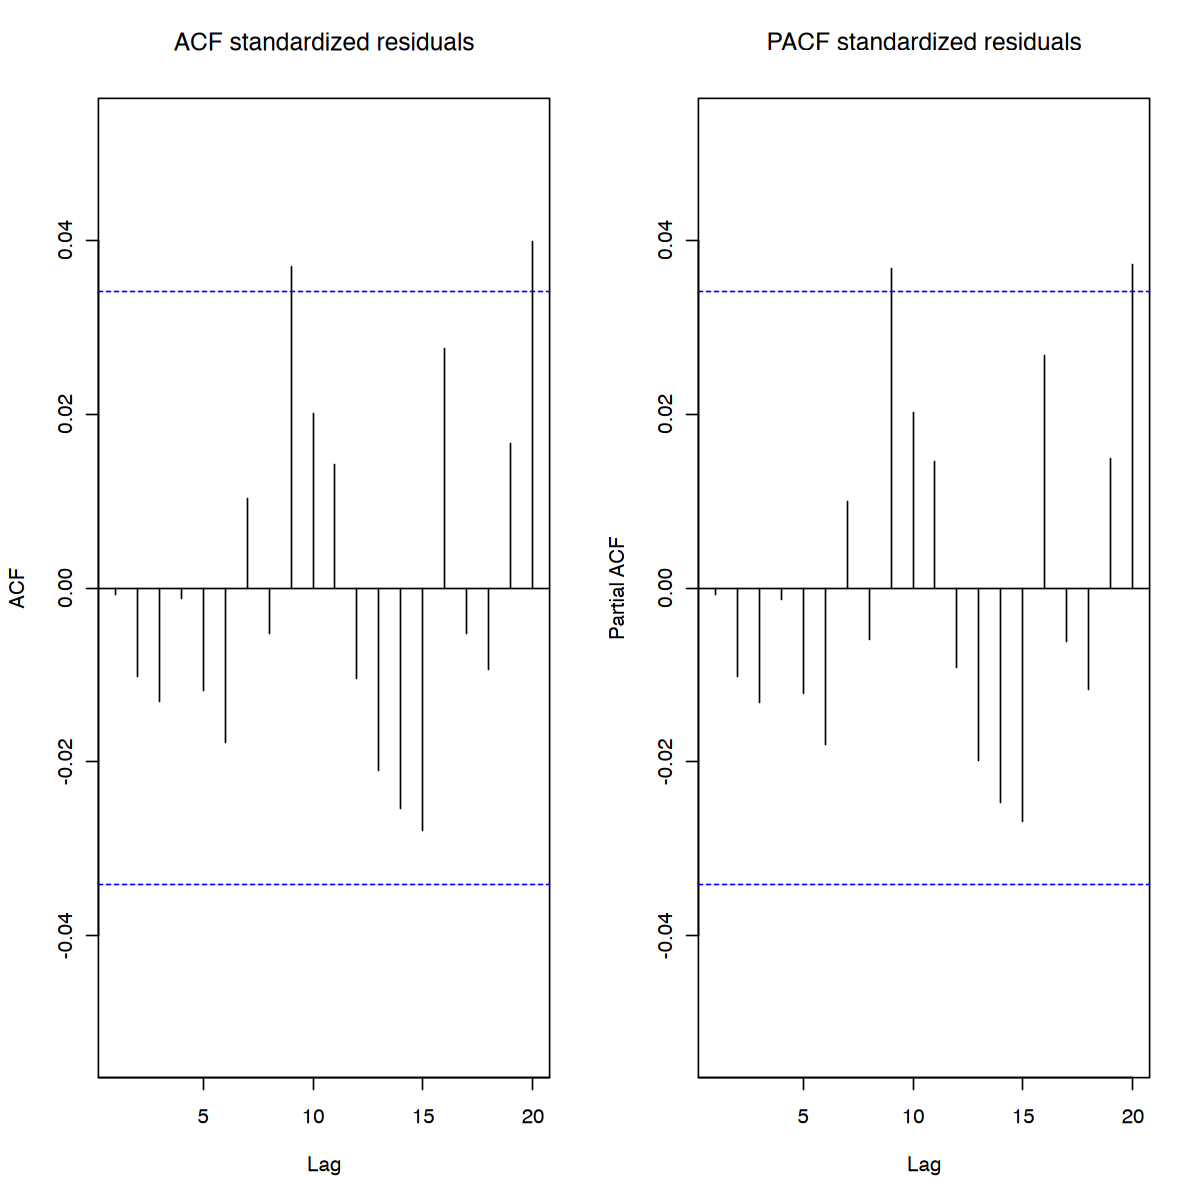

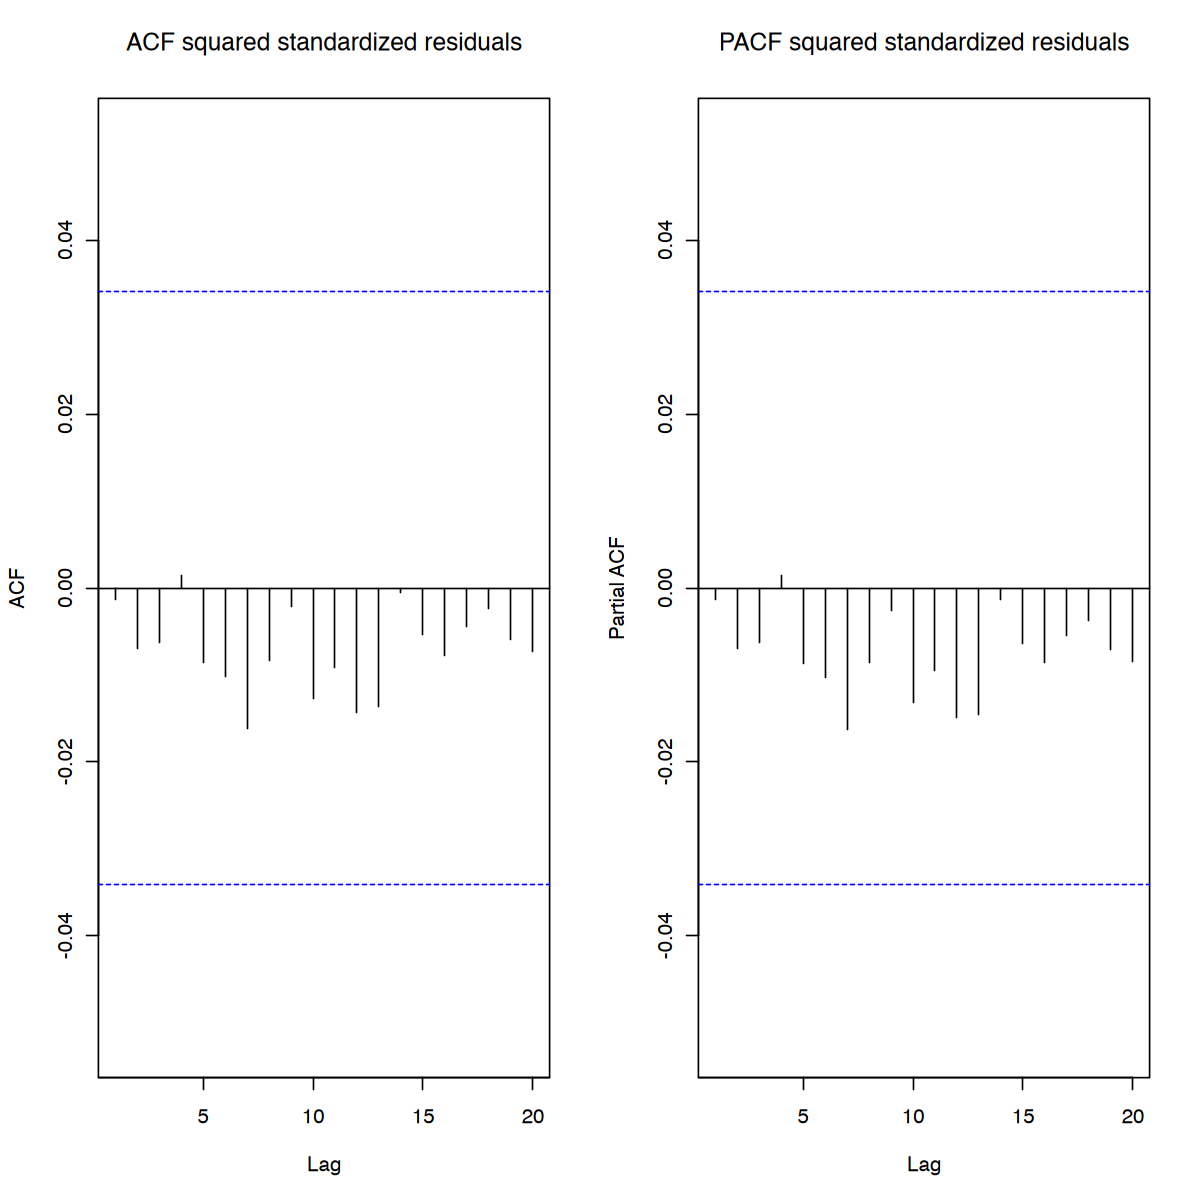

In [35]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

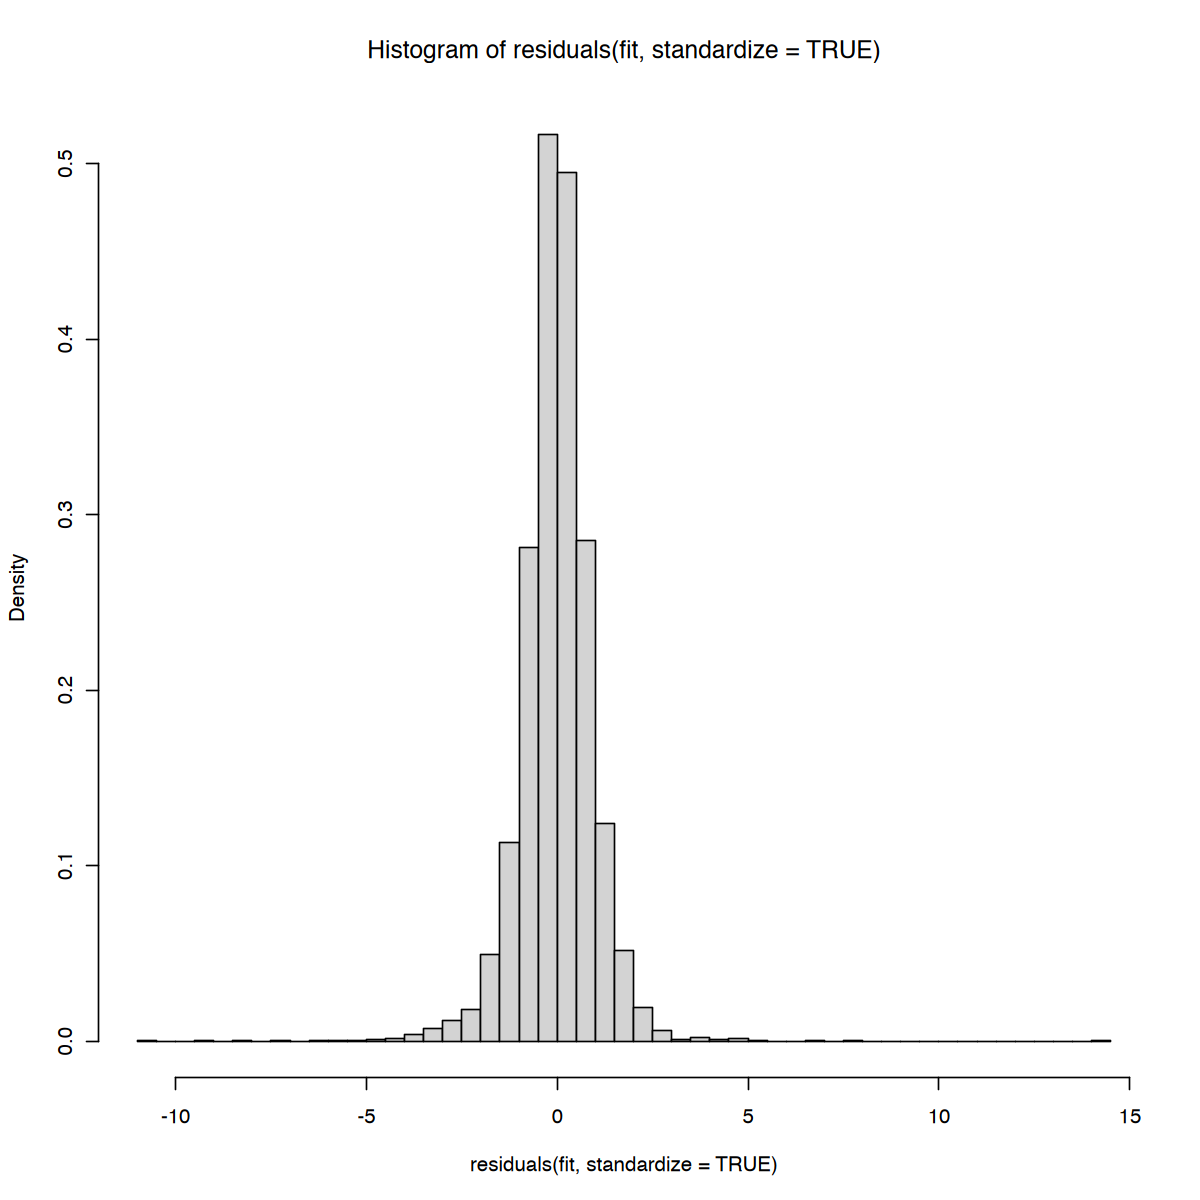

In [36]:
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)

In [37]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.473609 


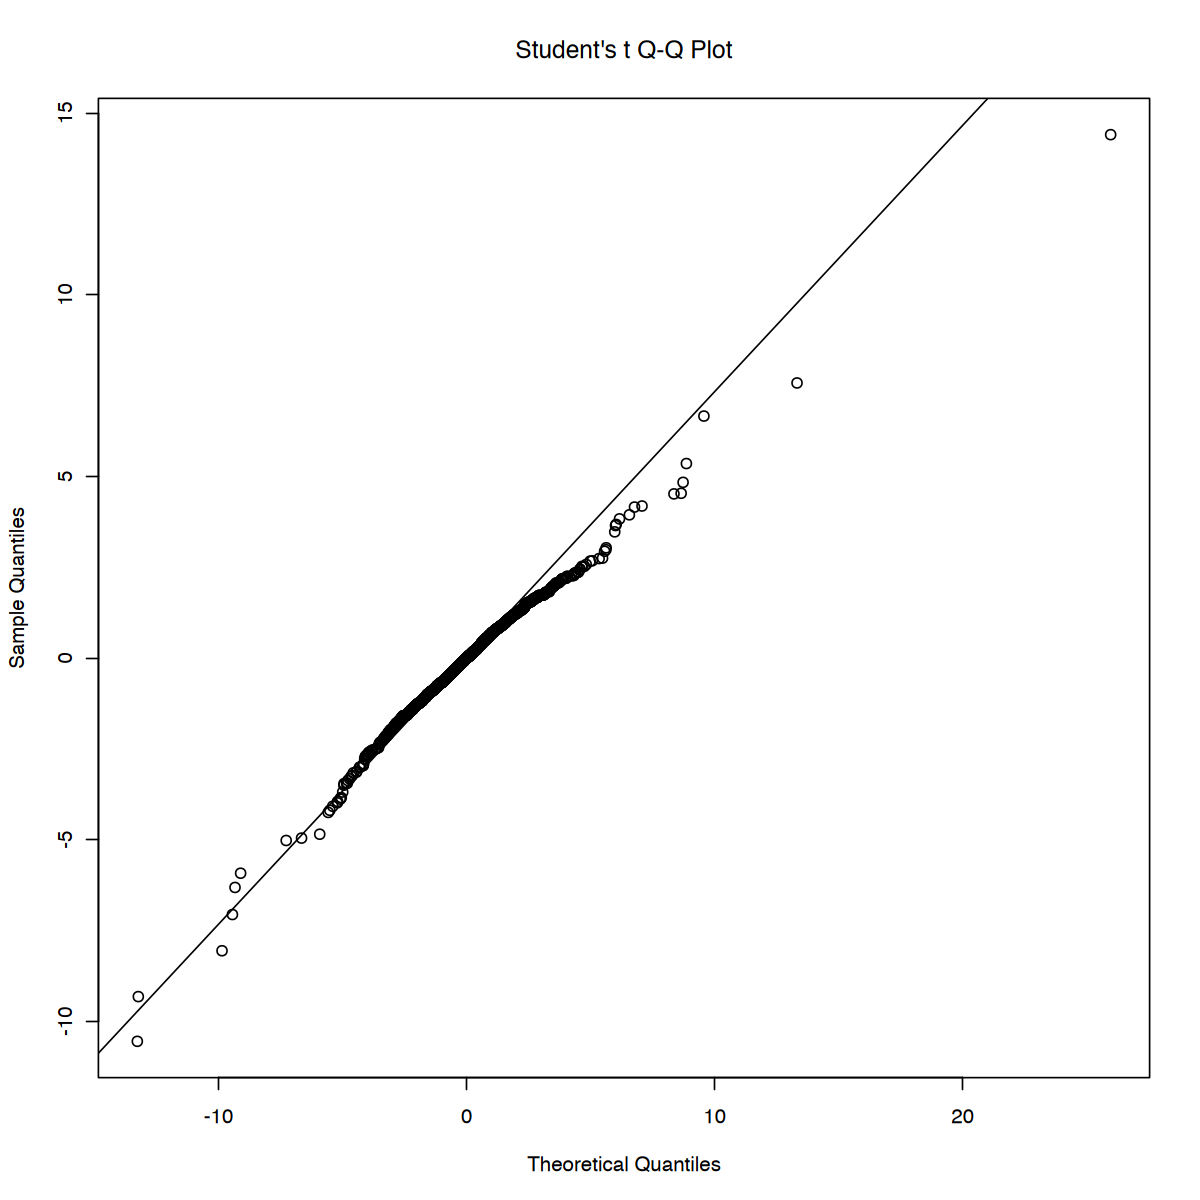

In [38]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

## GARCH(p,q) - norm

In [39]:
p_max <- 3
q_max <- 3
ic_min <- Inf
best_p <- 0
best_q <- 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        print(i1, i2)
        model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(i1, i2)))
        fit <- ugarchfit(spec = model_specification, data = log_ret)
        inf_crit <- infocriteria(fit)[1] # 1 for aic, 2 for bic, 3 Shibata, 4 Hannan-Quinn
        ic_min <- ifelse(inf_crit < ic_min, inf_crit, ic_min)
        
        best_p <- ifelse(inf_crit == ic_min, i1, best_p)
        best_q <- ifelse(inf_crit == ic_min, i2, best_q)
    }
}

c(best_p, best_q)

[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3


[1] 2 1

In [40]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(2, 1)))
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
coef(fit) # estimated parameters

show(fit)

mu        omega       alpha1       alpha2        beta1 
2.931995e-04 5.273101e-05 1.243123e-01 7.610365e-02 7.033263e-01


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000293    0.000307  0.95537  0.33939
omega   0.000053    0.000008  6.56662  0.00000
alpha1  0.124312    0.028186  4.41038  0.00001
alpha2  0.076104    0.039362  1.93345  0.05318
beta1   0.703326    0.038644 18.20006  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000293    0.000299  0.97901 0.327573
omega   0.000053    0.000028  1.91044 0.056077
alpha1  0.124312    0.057320  2.16876 0.030101
alpha2  0.076104    0.117163  0.64955 0.515982
beta1   0.703326    0.123417  5.69879 0.000000

LogLikelihood : 8357.101 

Information Criteria
------------------------------------
                

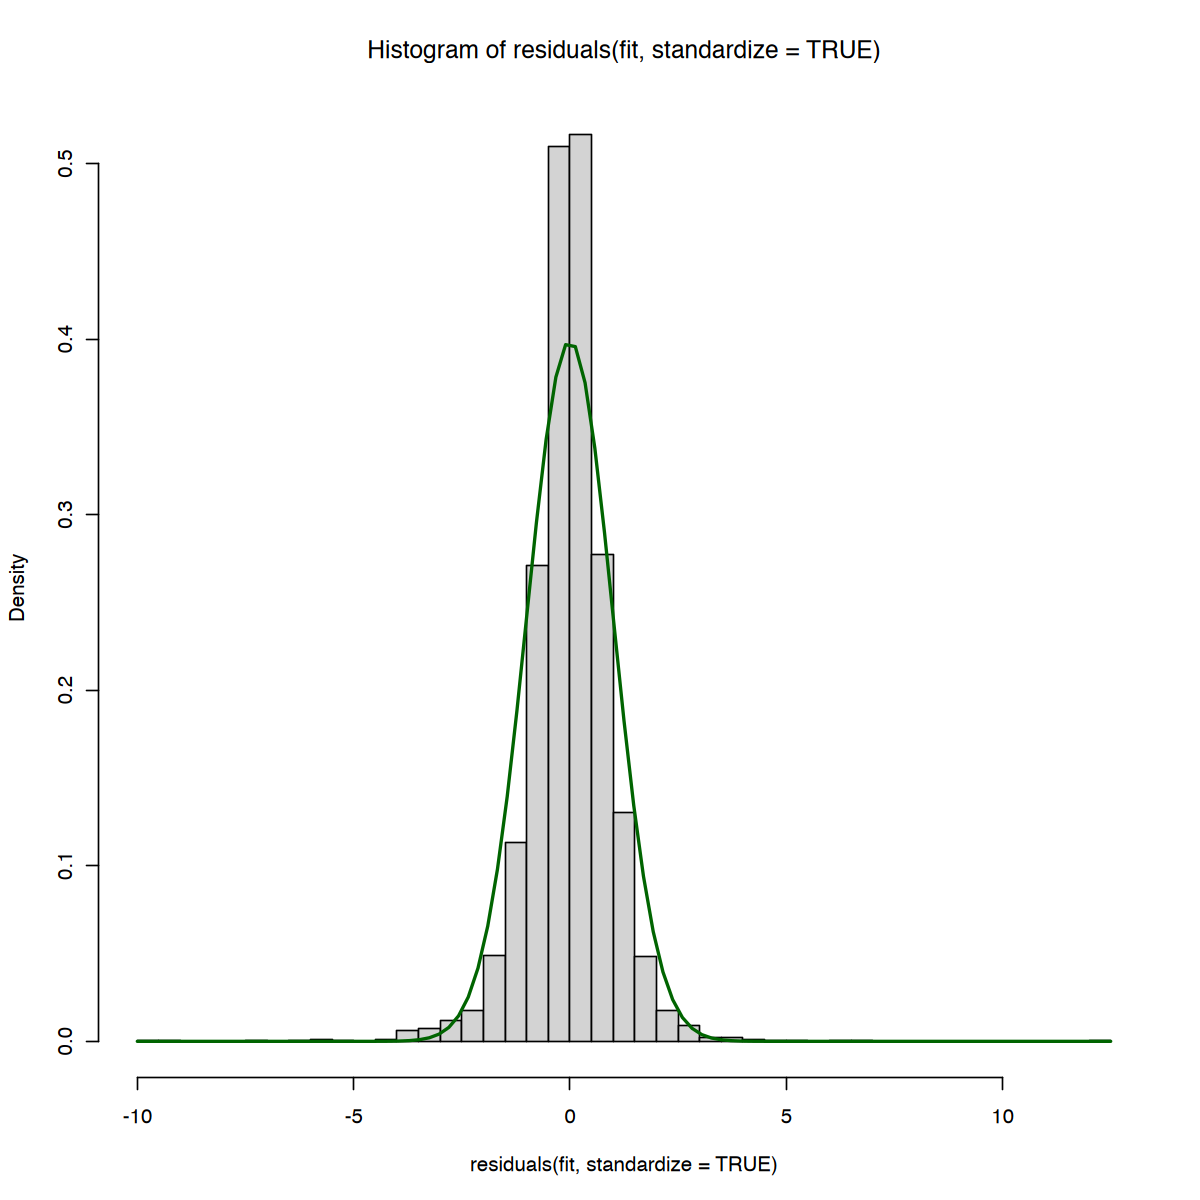

In [41]:
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

# furt hrozny!! musime 

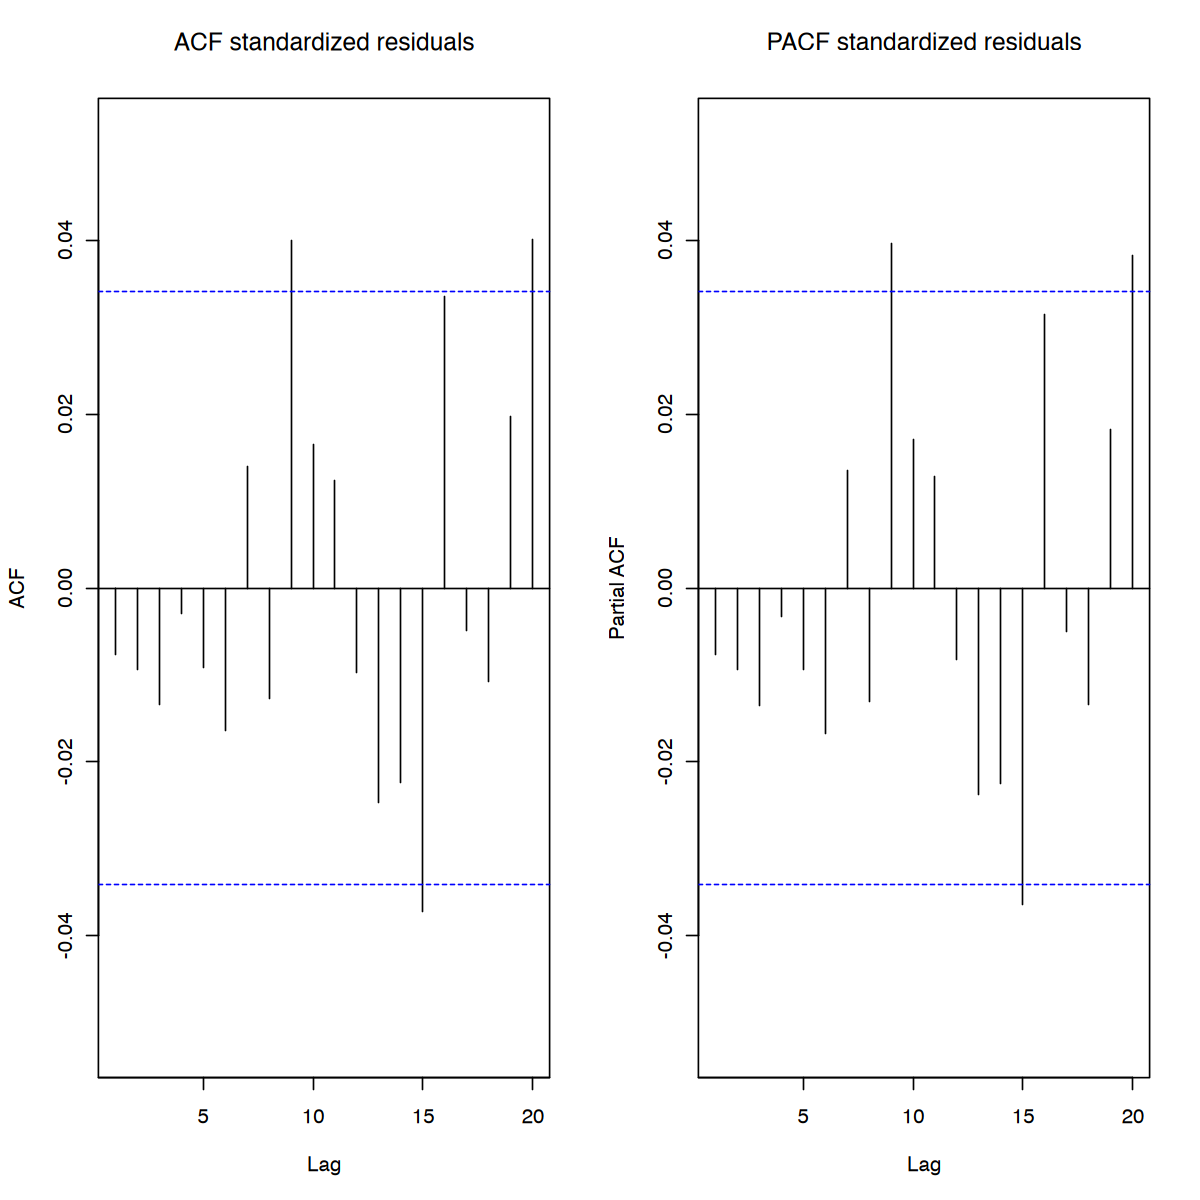

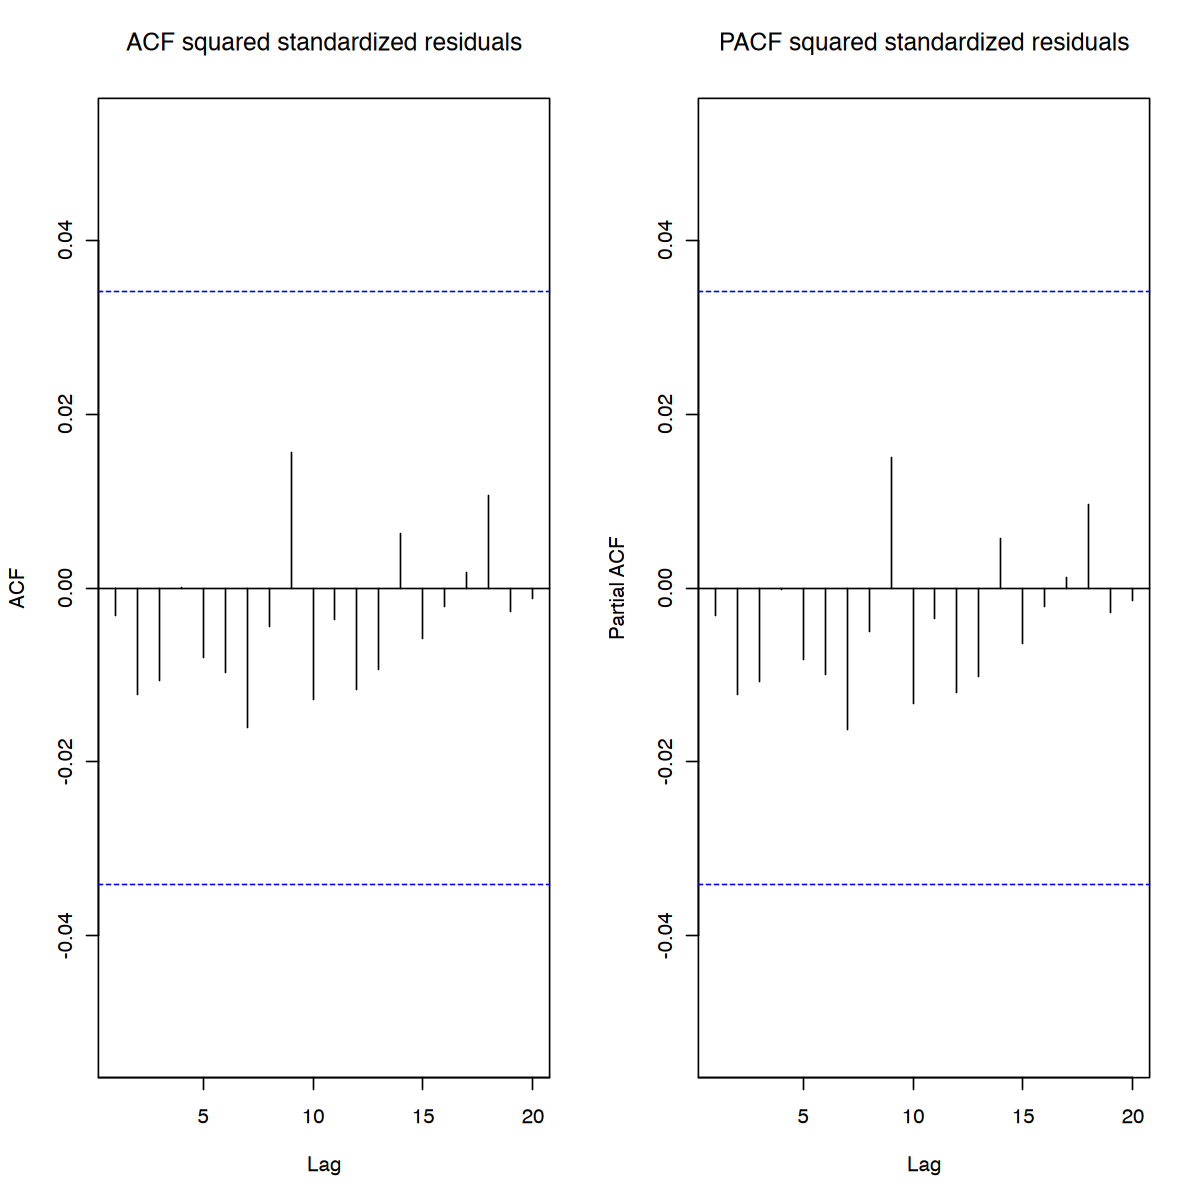

In [42]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

## GARCH(p,q) - t-dist

In [43]:
p_max <- 3
q_max <- 3
ic_min <- Inf
best_p <- 0
best_q <- 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        print(i1, i2)
        model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(i1, i2)), distribution.model = "sstd")
        fit <- ugarchfit(spec = model_specification, data = log_ret)
        inf_crit <- infocriteria(fit)[1] # 1 for aic, 2 for bic, 3 Shibata, 4 Hannan-Quinn
        ic_min <- ifelse(inf_crit < ic_min, inf_crit, ic_min)
        
        best_p <- ifelse(inf_crit == ic_min, i1, best_p)
        best_q <- ifelse(inf_crit == ic_min, i2, best_q)
    }
}

c(best_p, best_q)

[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3


[1] 1 3

In [44]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(1, 3)), distribution.model = "std")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
coef(fit) # estimated parameters

show(fit)

mu        omega       alpha1        beta1        beta2        beta3 
5.735481e-04 1.476892e-05 1.597542e-01 5.657337e-01 9.855539e-06 2.610753e-01 
       shape 
3.494576e+00


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,3)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000574    0.000233  2.459819 0.013901
omega   0.000015    0.000004  3.643984 0.000268
alpha1  0.159754    0.028289  5.647136 0.000000
beta1   0.565734    0.231505  2.443723 0.014537
beta2   0.000010    0.382826  0.000026 0.999979
beta3   0.261075    0.231734  1.126617 0.259904
shape   3.494576    0.241055 14.497034 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000574    0.000214 2.675983 0.007451
omega   0.000015    0.000009 1.643959 0.100185
alpha1  0.159754    0.051682 3.091121 0.001994
beta1   0.565734    0.376033 1.504479 0.132458
beta2   0.000010    0.573318 0.000017 0.999986
b

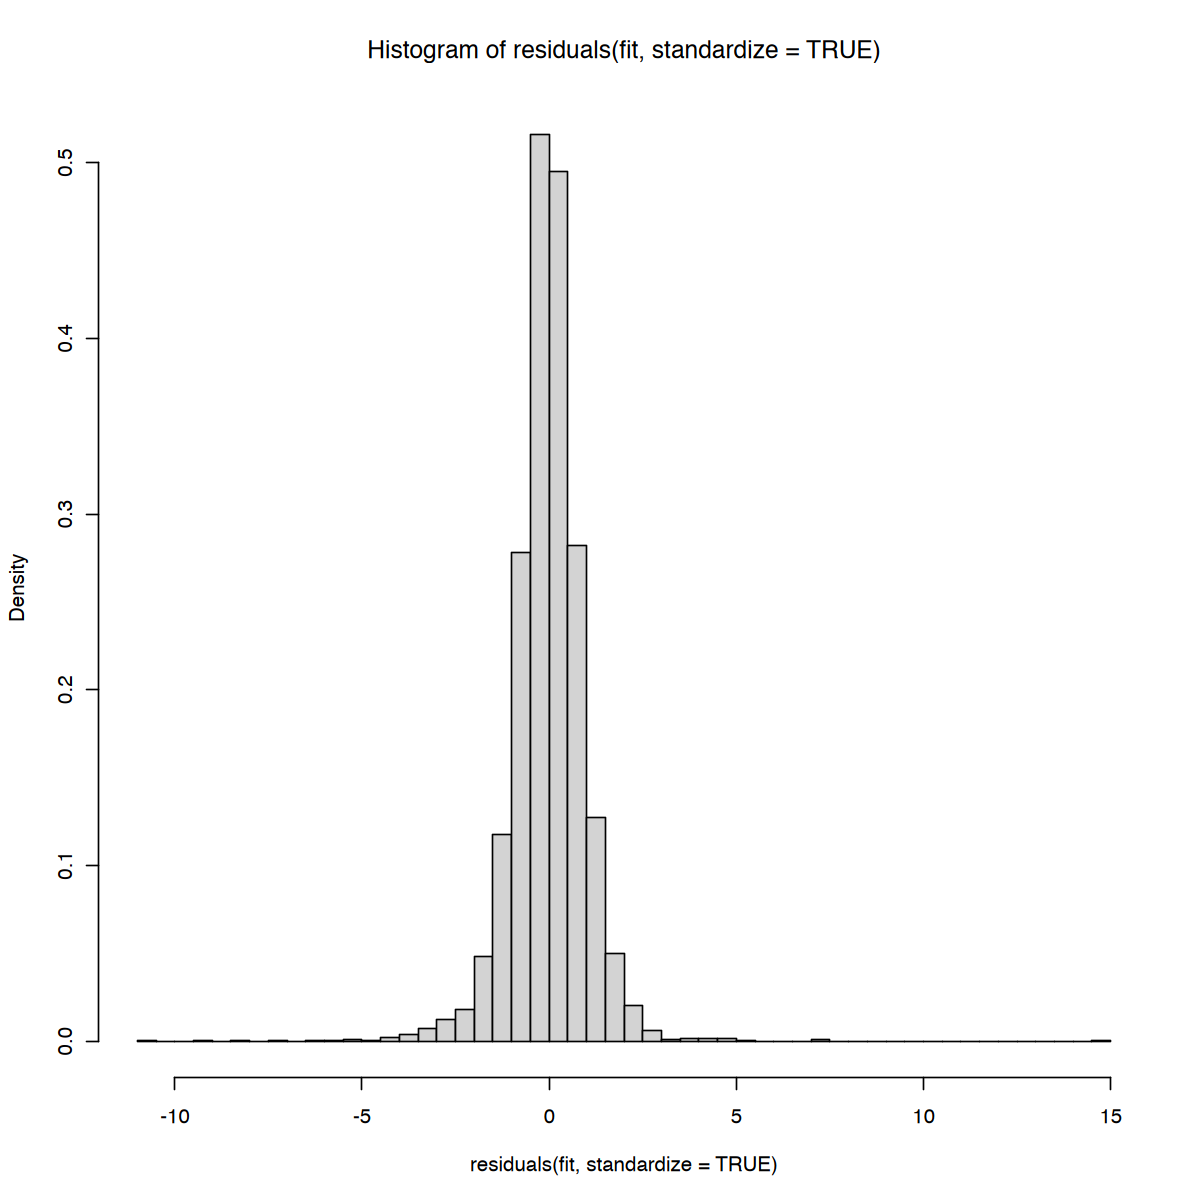

In [45]:
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)

In [46]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.494576 


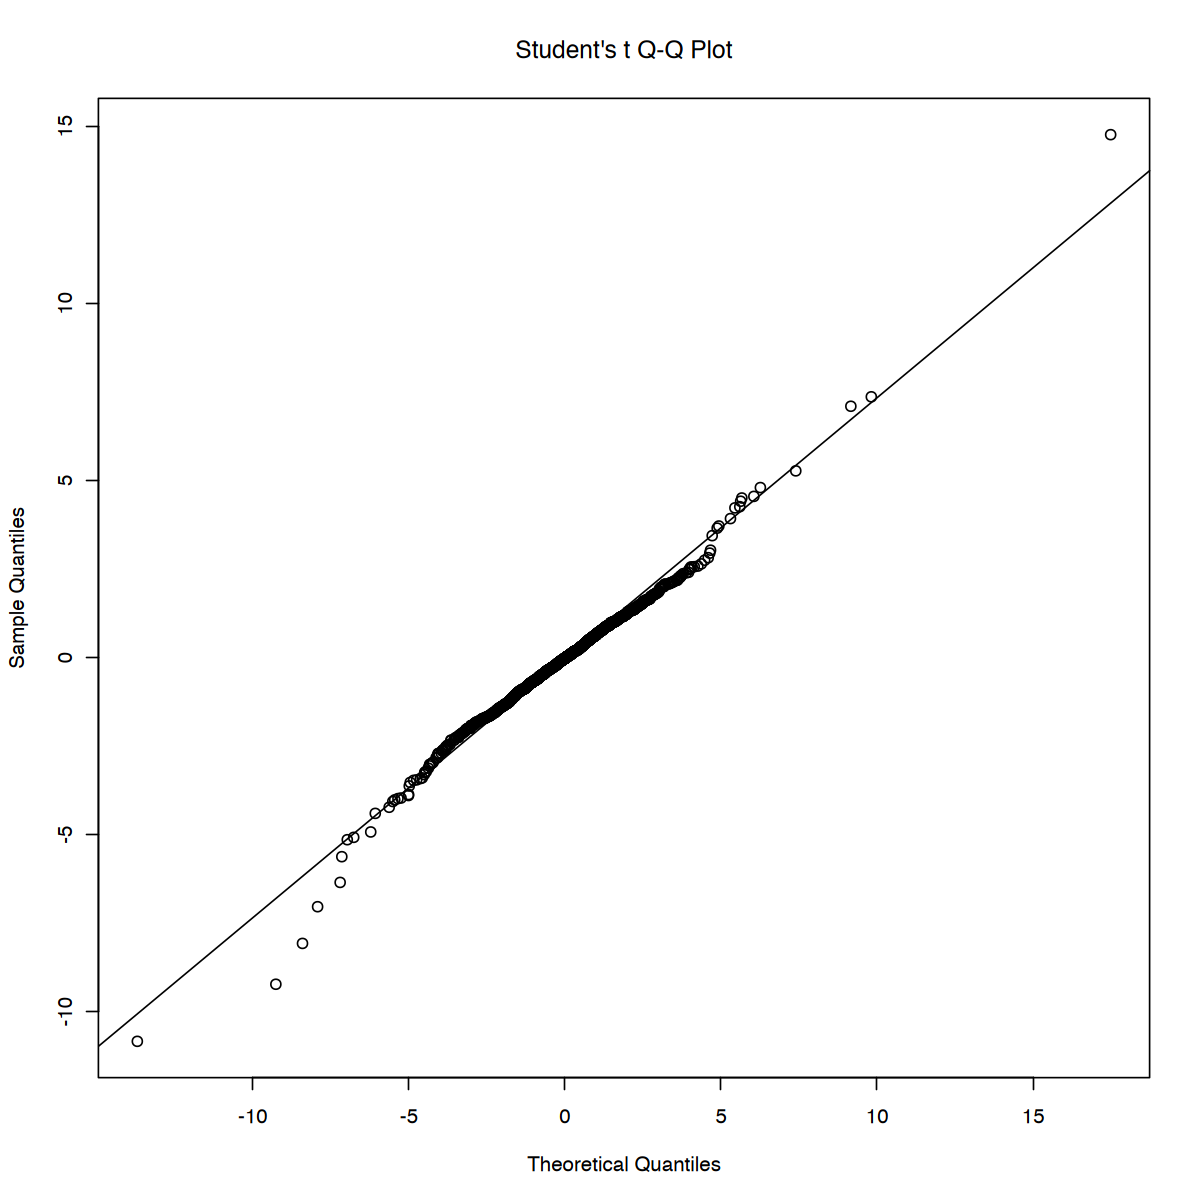

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

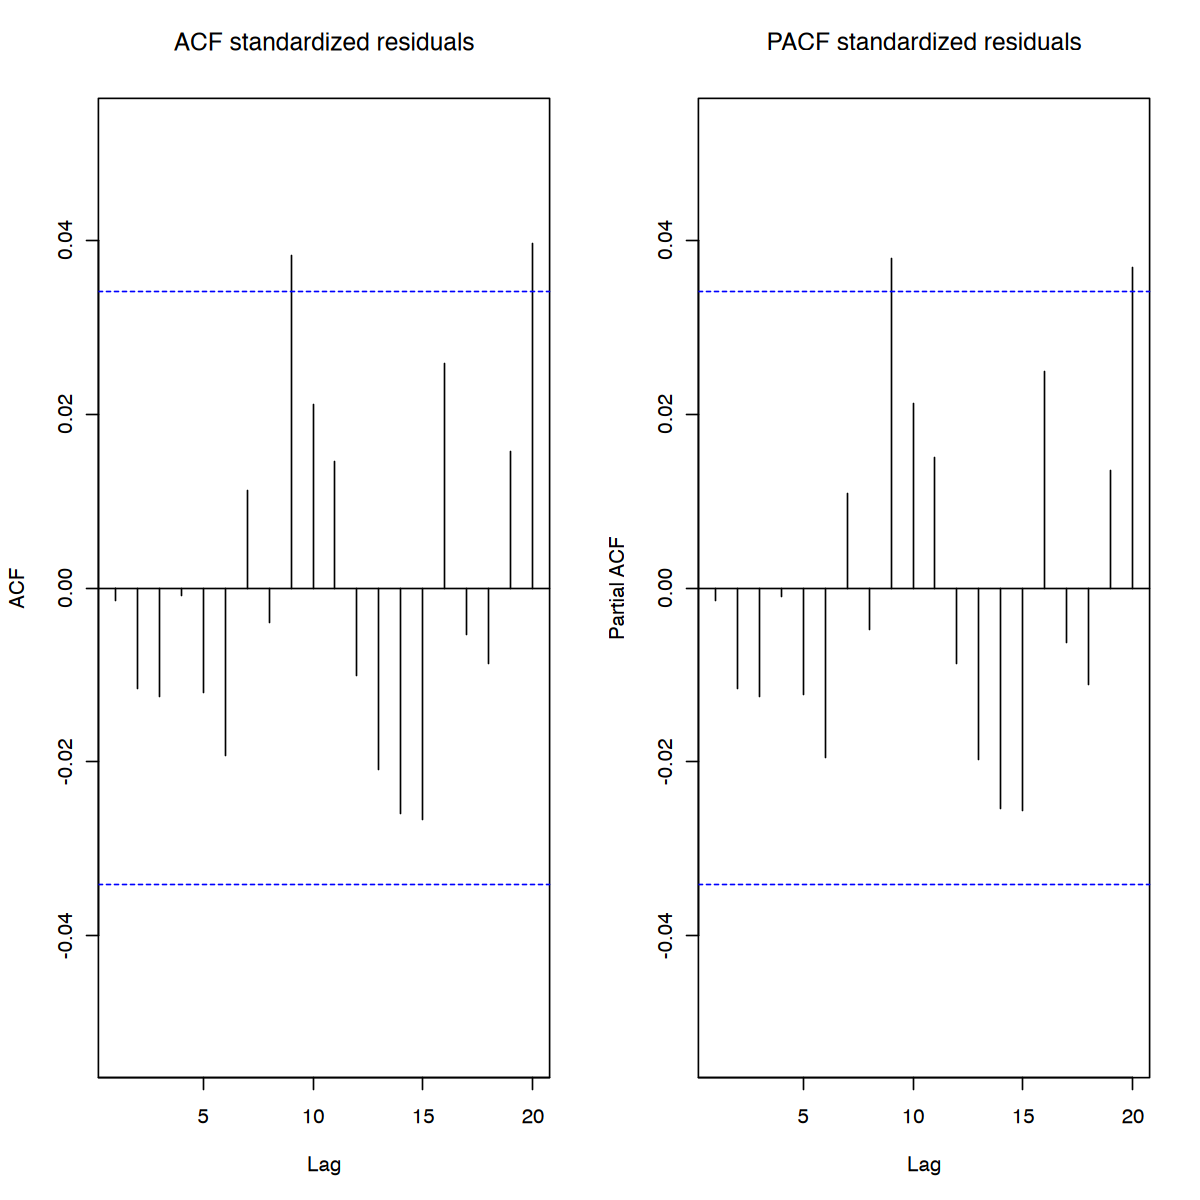

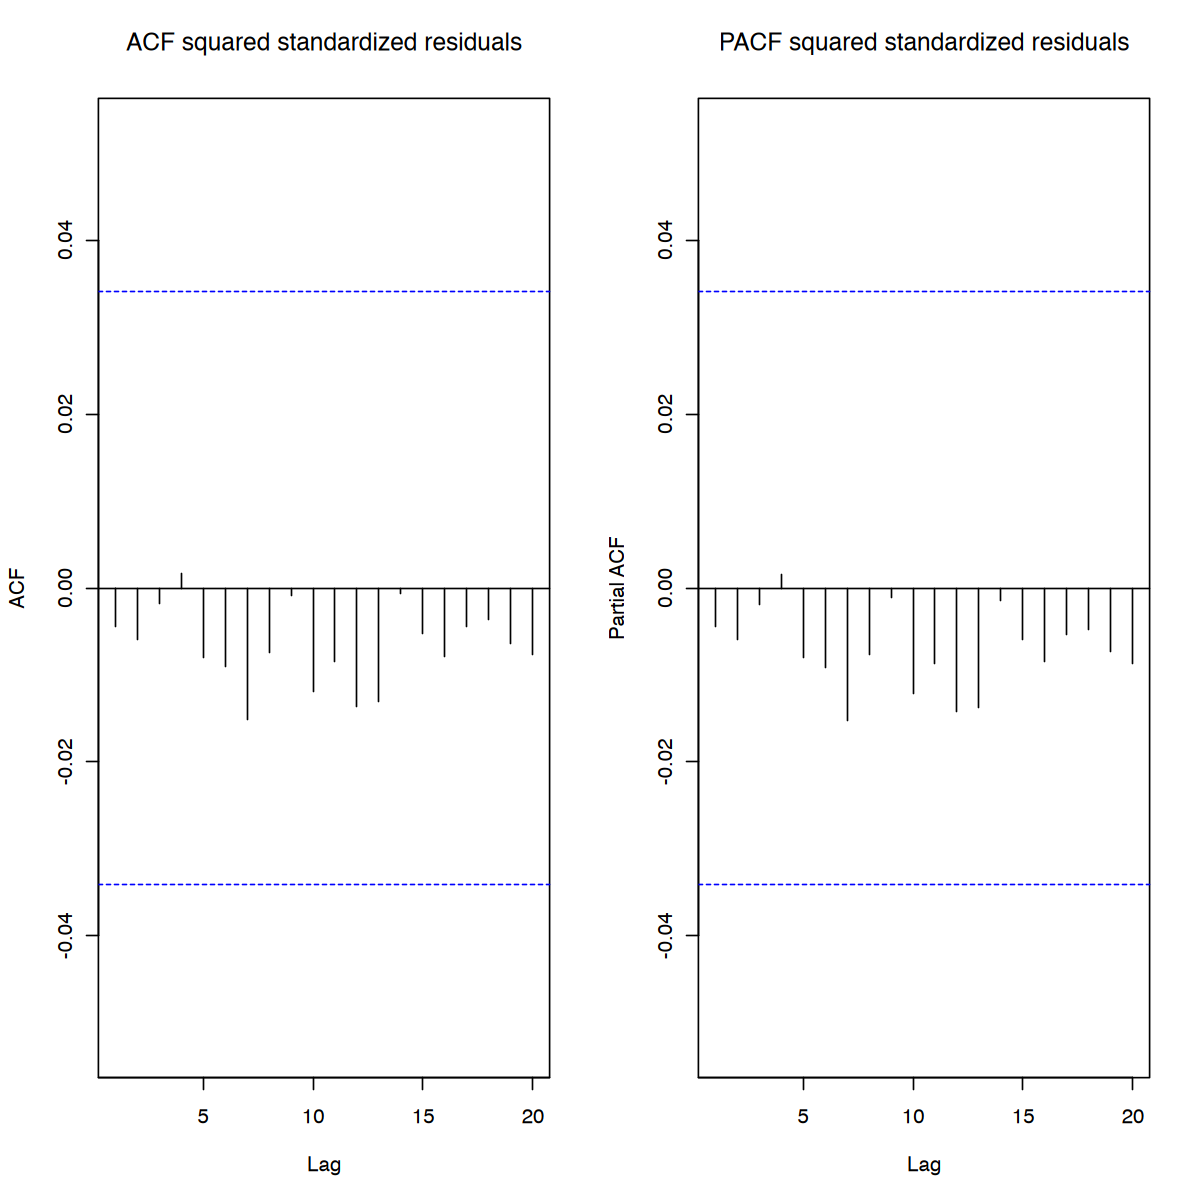

In [48]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

##  * GJR-GARCH - t

In [49]:
# you can specify some special GARCH models using ugarchspec function
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000442    0.000207   2.1376 0.032546
omega   0.000013    0.000005   2.5457 0.010907
alpha1  0.072265    0.030153   2.3966 0.016547
beta1   0.859246    0.008768  97.9937 0.000000
gamma1  0.111304    0.030076   3.7008 0.000215
shape   3.495154    0.262132  13.3336 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000442    0.000483  0.91488 0.360253
omega   0.000013    0.000022  0.60769 0.543392
alpha1  0.072265    0.136135  0.53083 0.595536
beta1   0.859246    0.051286 16.75393 0.000000
gamma1  0.111304    0.049409  2.25271 0.024278
shape   3.495154    1.397478  2.50104 0.012383

LogLik

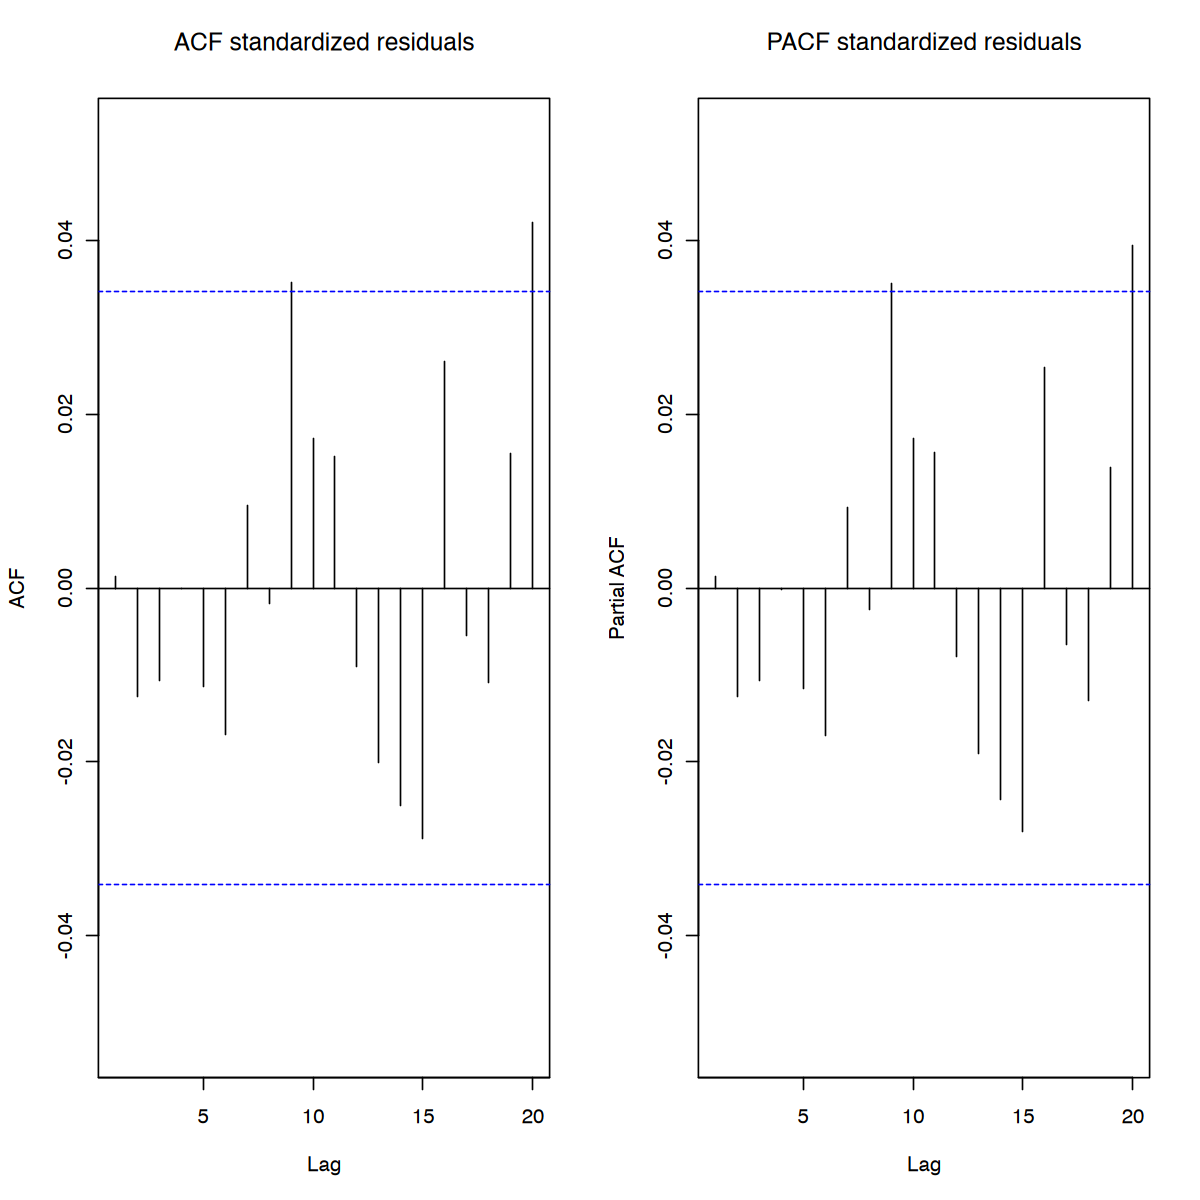

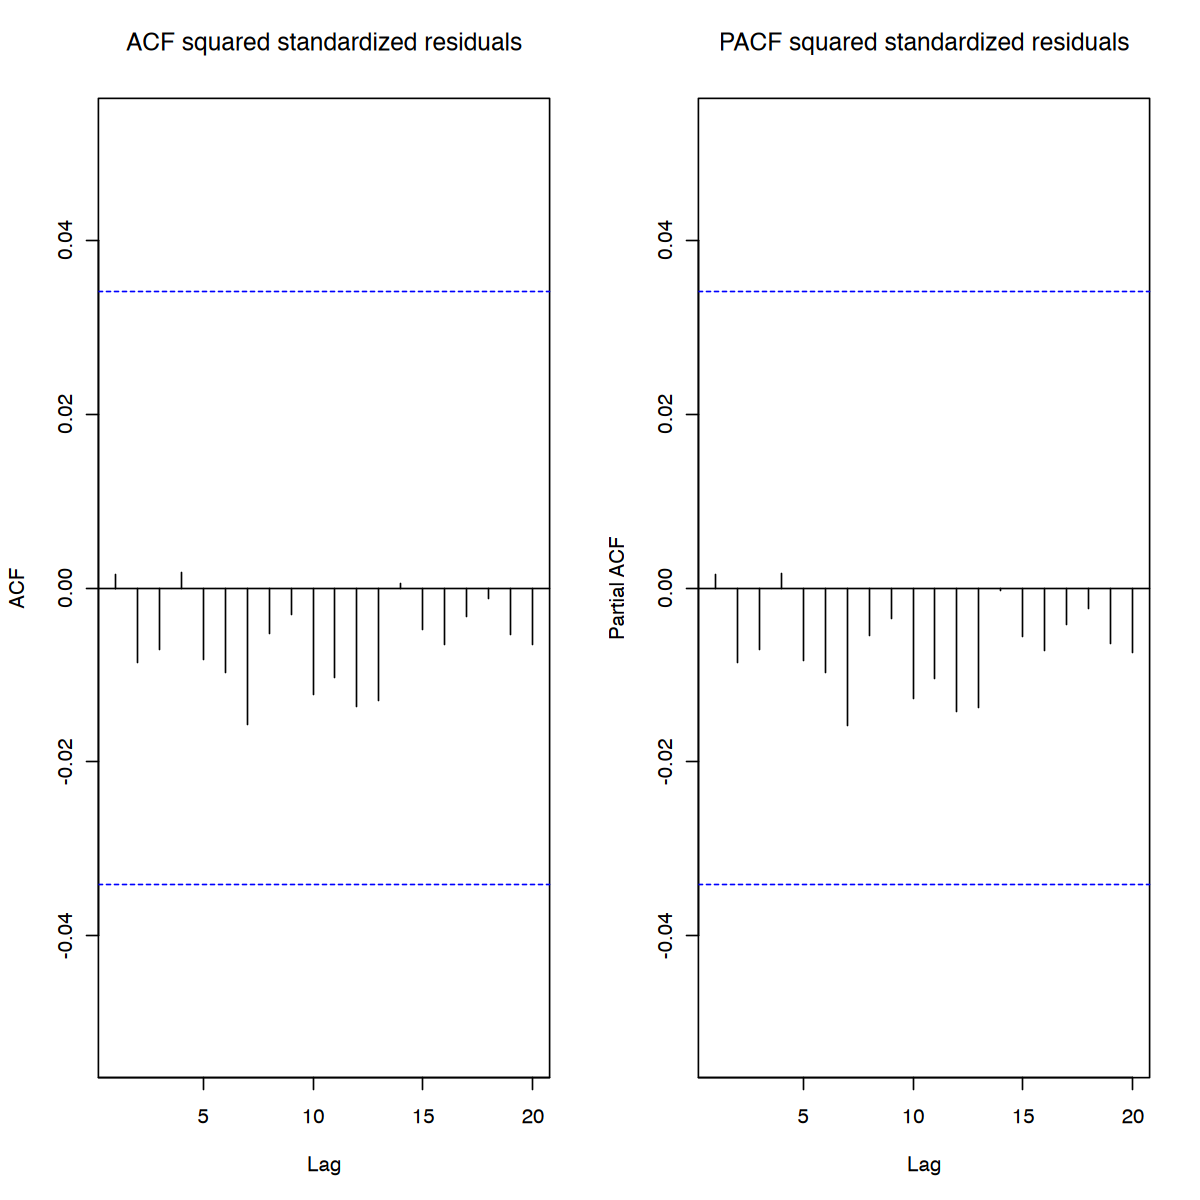

In [50]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

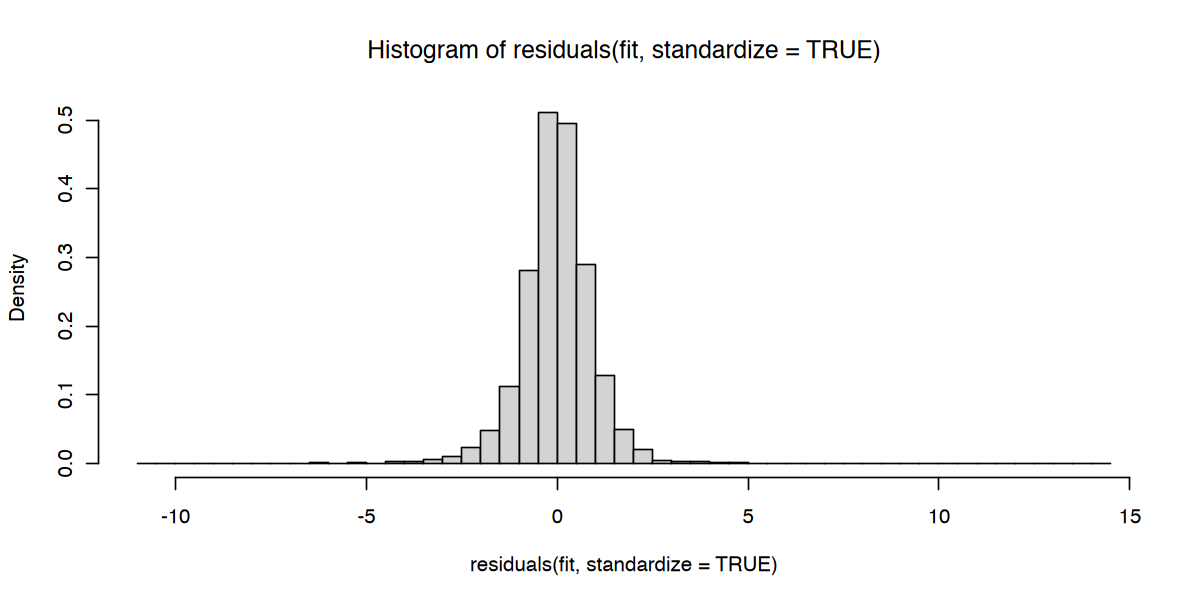

In [51]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)


In [52]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.495154 


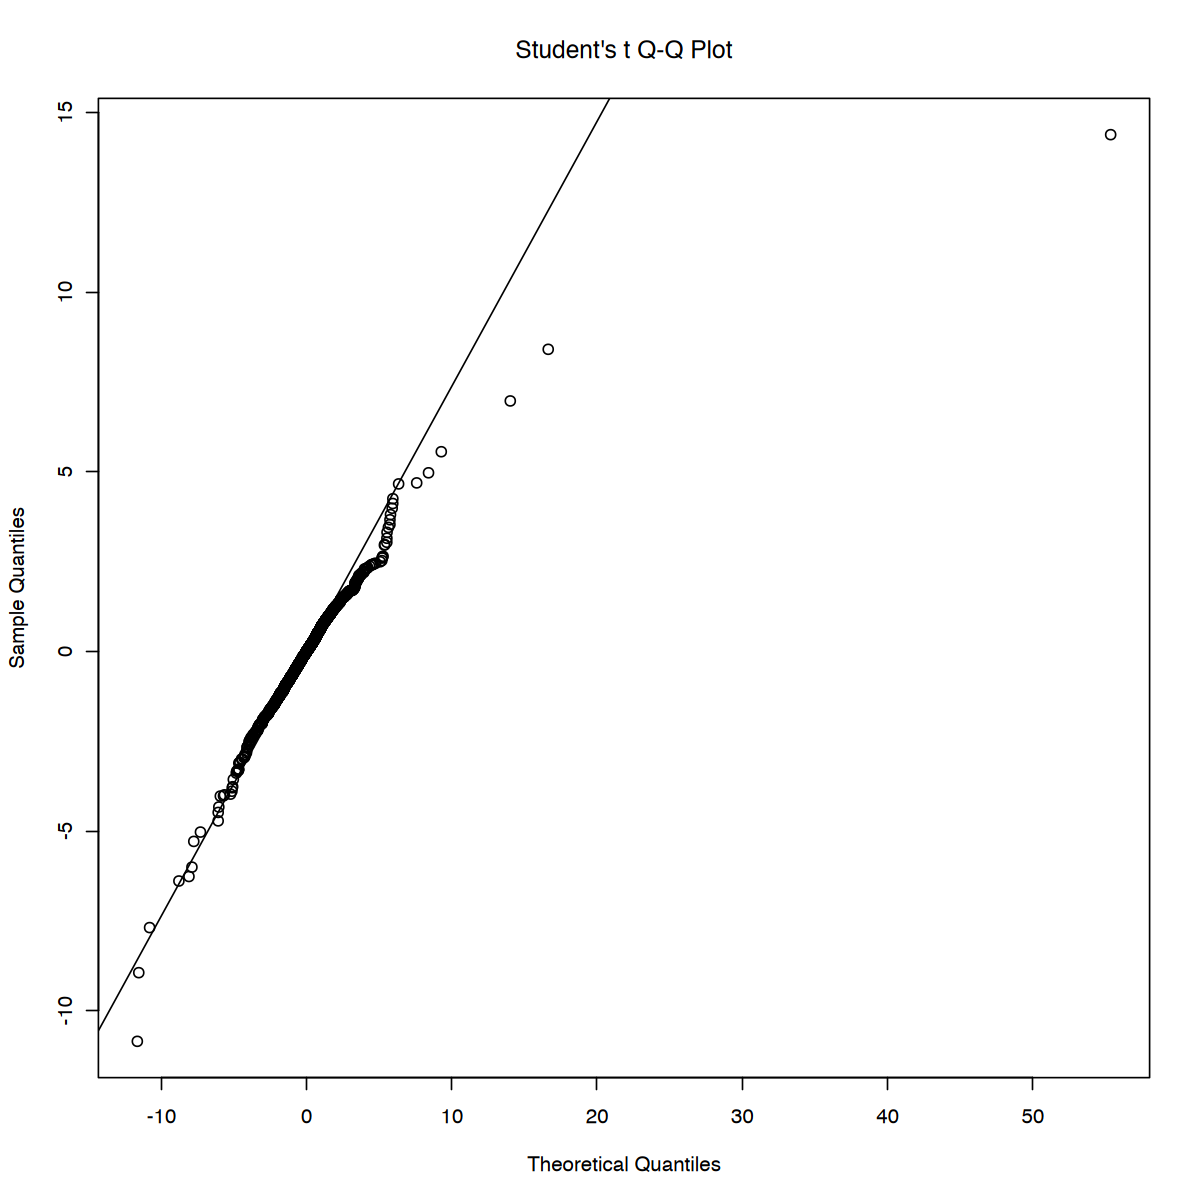

In [53]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

## GJR-GARCH - norm

In [54]:
# you can specify some special GARCH models using ugarchspec function
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "norm") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit) 




*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000219    0.000310  0.70774  0.47911
omega   0.000042    0.000006  6.87523  0.00000
alpha1  0.091011    0.023657  3.84704  0.00012
beta1   0.768640    0.027709 27.73994  0.00000
gamma1  0.116642    0.034861  3.34594  0.00082

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000219    0.000284  0.77124 0.440566
omega   0.000042    0.000017  2.44068 0.014660
alpha1  0.091011    0.055226  1.64796 0.099362
beta1   0.768640    0.063262 12.15002 0.000000
gamma1  0.116642    0.074769  1.56004 0.118751

LogLikelihood : 8361.196 

Information Criteria
------------------------------------
              

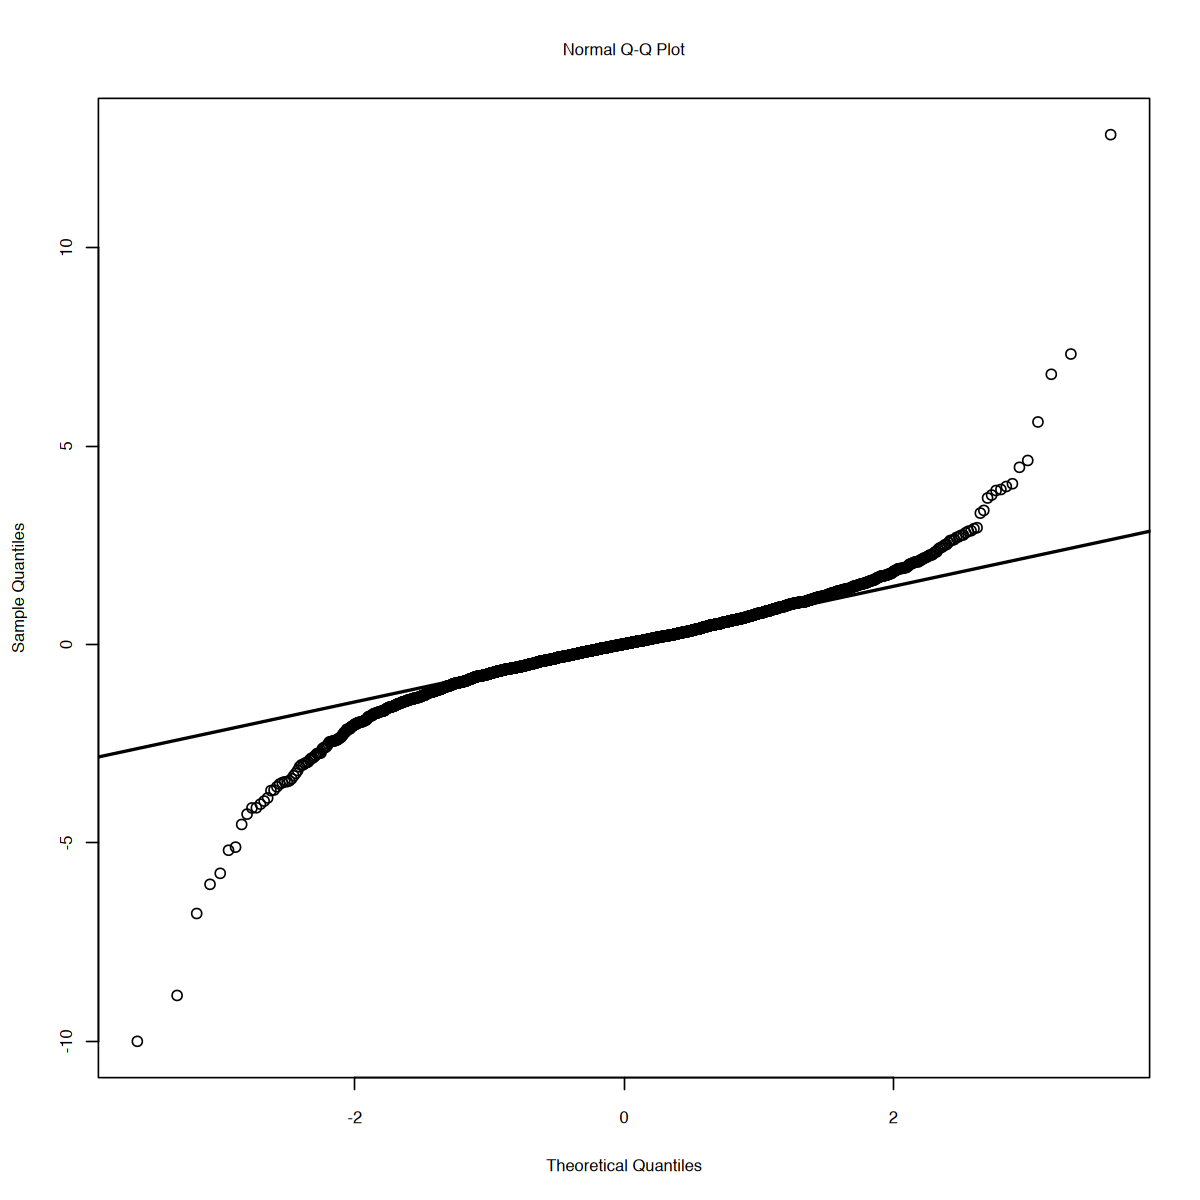

In [55]:
qqnorm(residuals(fit)/ sigma(fit), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8) 
qqline(residuals(fit)/ sigma(fit), lwd = 2)

## GJR-GARCH-t a norm(p,q)

In [56]:
p_max <- 4
q_max <- 4
ic_min <- Inf
best_p <- 0
best_q <- 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        print(i1, i2)
        model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)), distribution.model = "std")
        fit <- ugarchfit(spec = model_specification, data = log_ret)
        inf_crit <- infocriteria(fit)[1] # 1 for aic, 2 for bic, 3 Shibata, 4 Hannan-Quinn
        ic_min <- ifelse(inf_crit < ic_min, inf_crit, ic_min)
        
        best_p <- ifelse(inf_crit == ic_min, i1, best_p)
        best_q <- ifelse(inf_crit == ic_min, i2, best_q)
    }
}

c(best_p, best_q)

[1] 1
[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3
[1] 3
[1] 4
[1] 4
[1] 4
[1] 4


[1] 4 4

In [57]:
# you can specify some special GARCH models using ugarchspec function
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(4, 4)),
                     distribution.model = "norm") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(4,4)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000114    0.000317  3.5920e-01  0.71944
omega   0.000001    0.000001  2.4968e+00  0.01253
alpha1  0.008611    0.000771  1.1169e+01  0.00000
alpha2  0.000000    0.023957  0.0000e+00  1.00000
alpha3  0.000000    0.029279  0.0000e+00  1.00000
alpha4  0.000000    0.009949  0.0000e+00  1.00000
beta1   0.717722    0.000038  1.8750e+04  0.00000
beta2   0.269607    0.001018  2.6483e+02  0.00000
beta3   0.000007    0.001521  4.5800e-03  0.99635
beta4   0.000001    0.003349  2.7300e-04  0.99978
gamma1  0.177636    0.000013  1.3633e+04  0.00000
gamma2  0.032857    0.000177  1.8560e+02  0.00000
gamma3 -0.102048    0.001436 -7.1044e+0

In [58]:
# you can specify some special GARCH models using ugarchspec function
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(4, 4)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(4,4)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000464    0.000232    2.001263 0.045364
omega   0.000002    0.000000    8.157907 0.000000
alpha1  0.025336    0.014844    1.706847 0.087850
alpha2  0.000000    0.023820    0.000000 1.000000
alpha3  0.000000    0.031394    0.000000 1.000000
alpha4  0.000000    0.025065    0.000000 1.000000
beta1   0.814159    0.000305 2669.667545 0.000000
beta2   0.153497    0.022168    6.924294 0.000000
beta3   0.000000    0.103928    0.000001 0.999999
beta4   0.000000    0.080052    0.000001 1.000000
gamma1  0.213663    0.019027   11.229365 0.000000
gamma2  0.084647    0.040071    2.112423 0.034650
gamma3 -0.166453    0.052225   -3.187262

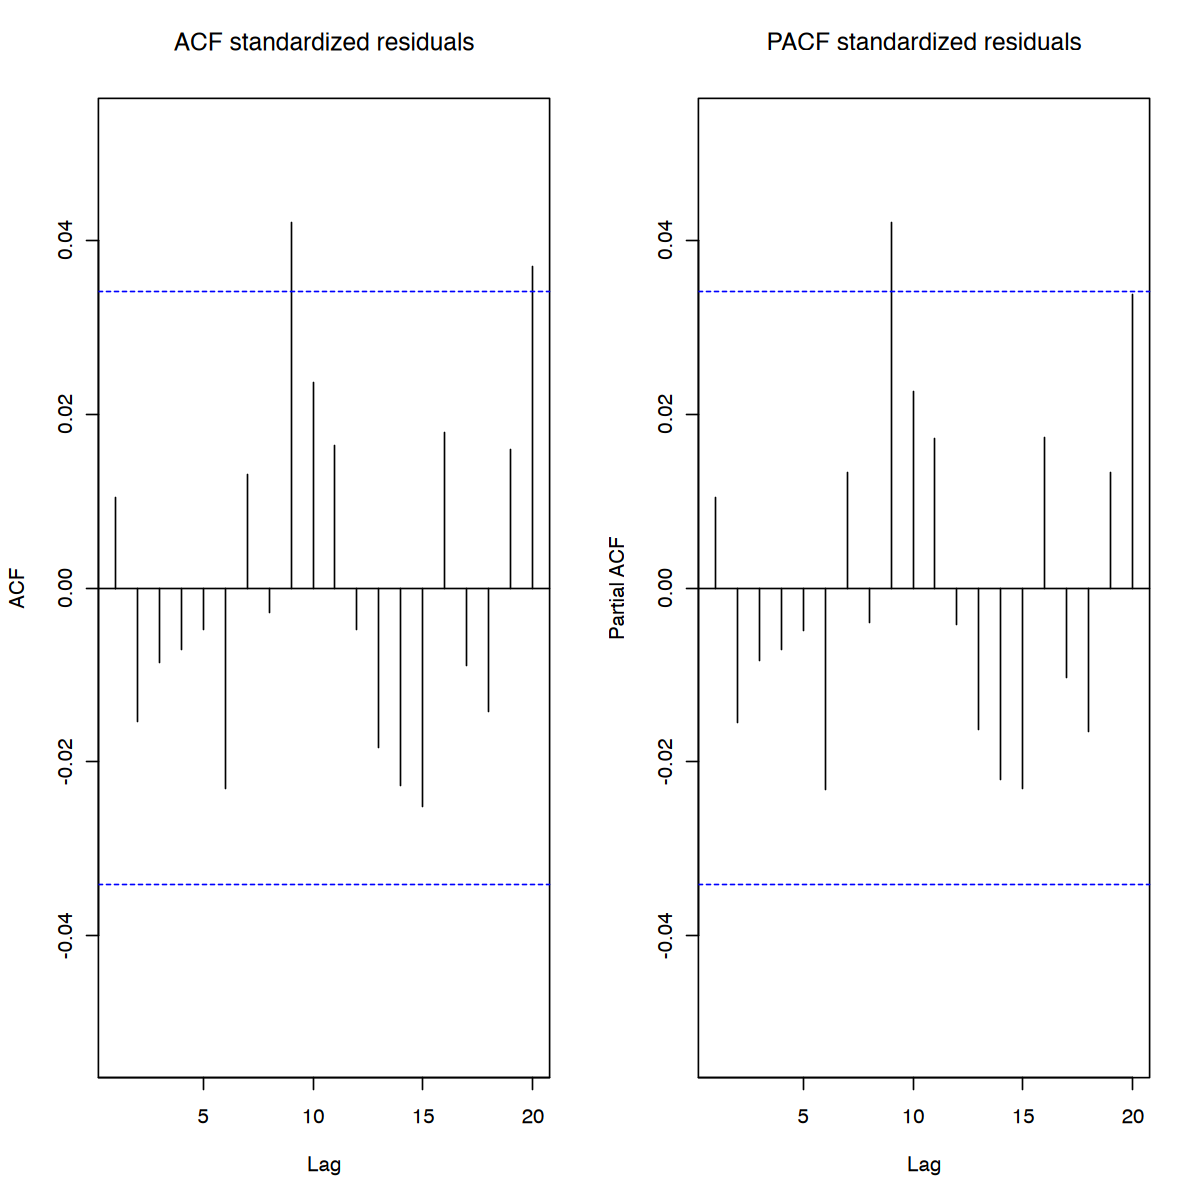

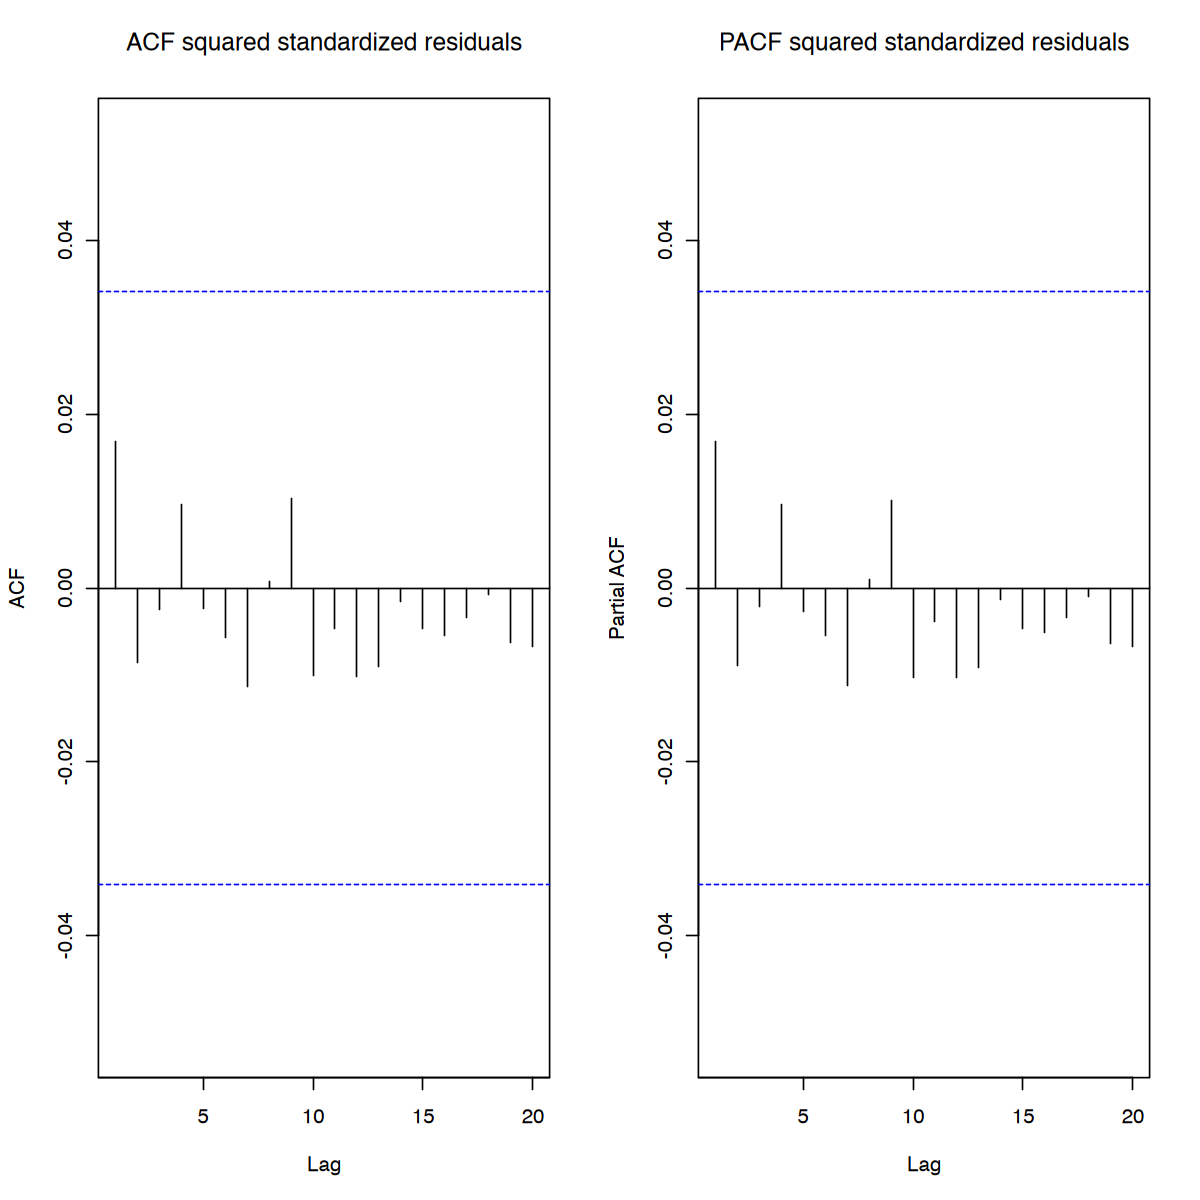

In [59]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

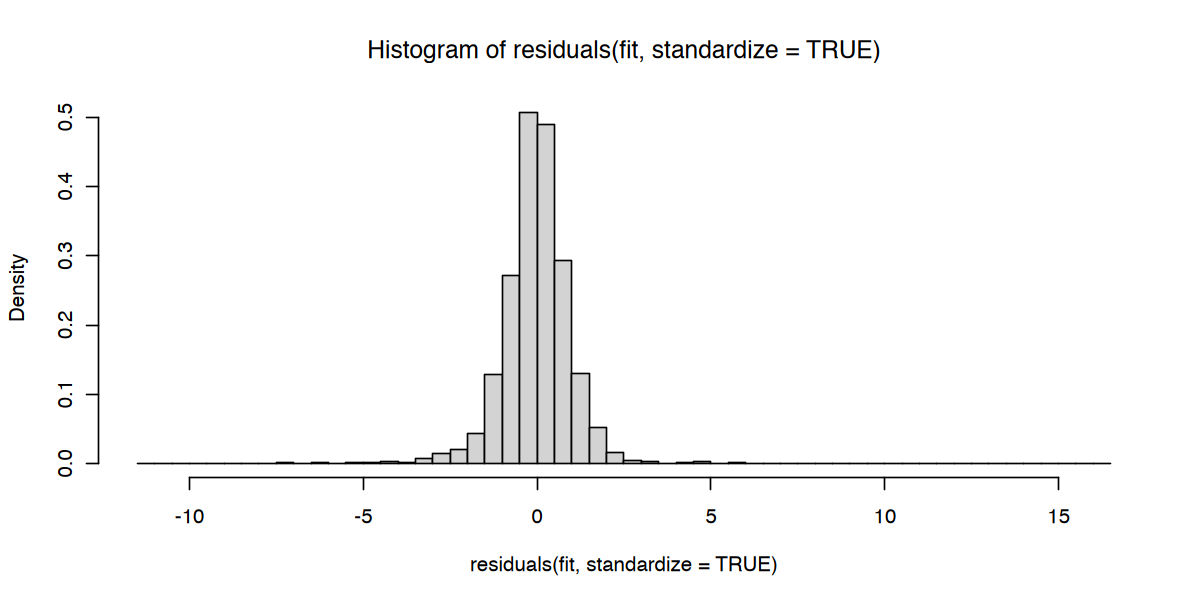

In [60]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)


In [61]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.548969 


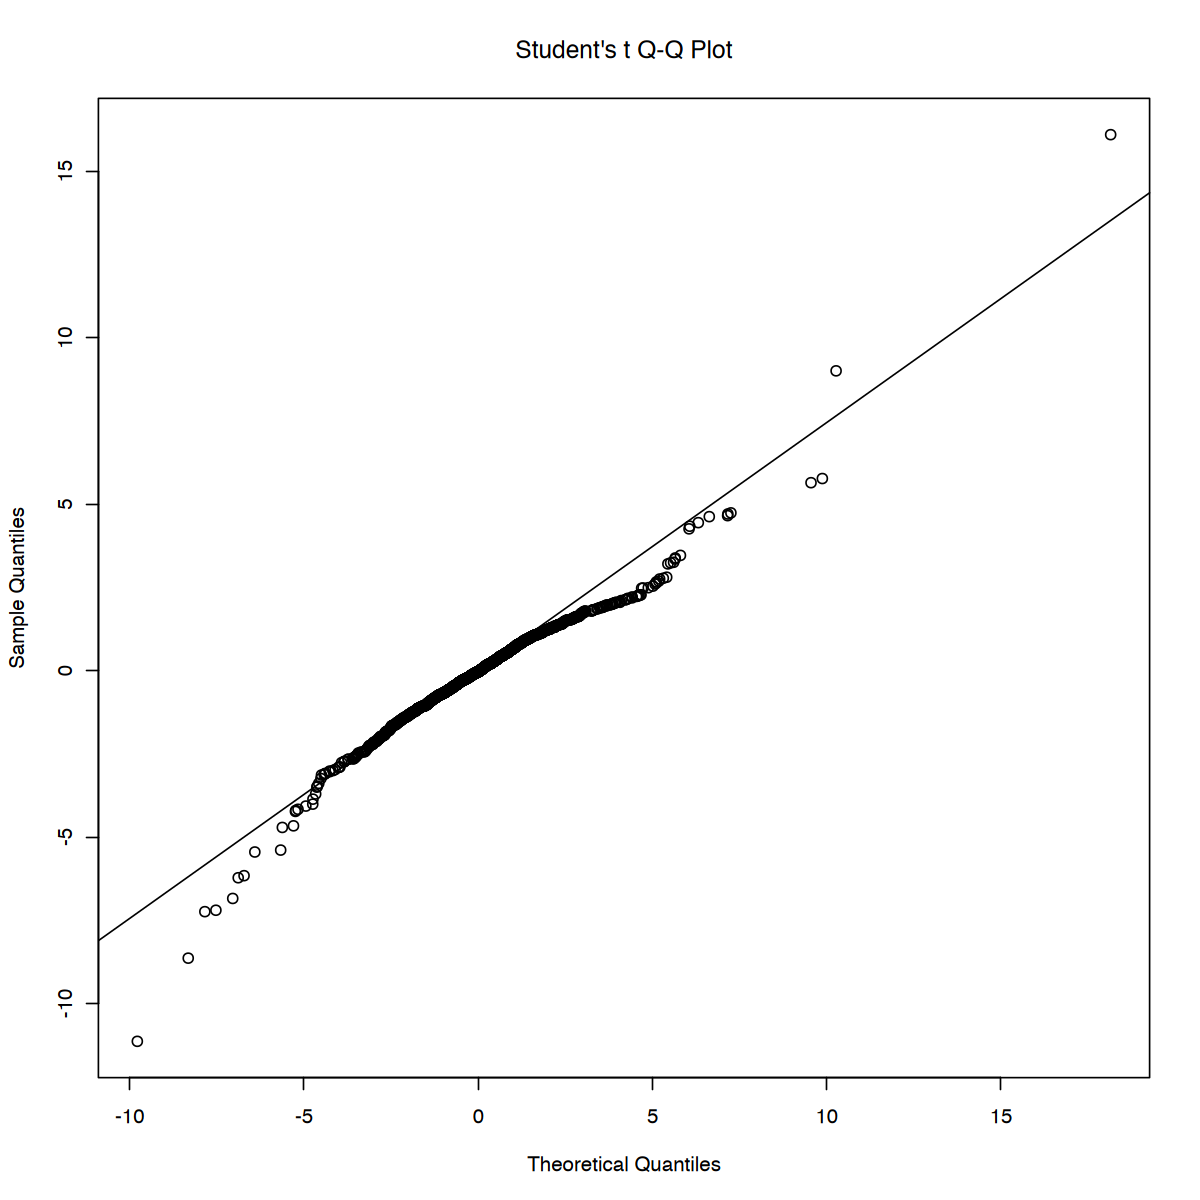

In [62]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

## EGARCH(1,1) - norm

In [63]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
                                 distribution.model = "norm")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# explore the results 
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000000    0.000134  0.000059 0.999953
omega  -0.651308    0.114227 -5.701889 0.000000
alpha1 -0.060462    0.016493 -3.665857 0.000247
beta1   0.913691    0.014699 62.161854 0.000000
gamma1  0.257882    0.026709  9.655161 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000000    0.000060  0.000132 0.999894
omega  -0.651308    0.343645 -1.895292 0.058054
alpha1 -0.060462    0.034223 -1.766708 0.077277
beta1   0.913691    0.045177 20.224578 0.000000
gamma1  0.257882    0.069642  3.702956 0.000213

LogLikelihood : 8400.756 

Information Criteria
------------------------------------
    

##  * EGARCH(1,1) - t

In [64]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
                                 distribution.model = "std")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# explore the results
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000426    0.000242   1.7587 0.078628
omega  -0.179307    0.019686  -9.1083 0.000000
alpha1 -0.057619    0.013578  -4.2436 0.000022
beta1   0.977662    0.002474 395.2135 0.000000
gamma1  0.188650    0.022593   8.3501 0.000000
shape   3.573976    0.228227  15.6598 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000426    0.000237   1.8018 0.071575
omega  -0.179307    0.013388 -13.3936 0.000000
alpha1 -0.057619    0.015735  -3.6618 0.000250
beta1   0.977662    0.001739 562.0934 0.000000
gamma1  0.188650    0.030056   6.2766 0.000000
shape   3.573976    0.262966  13.5910 0.000000

LogLikel

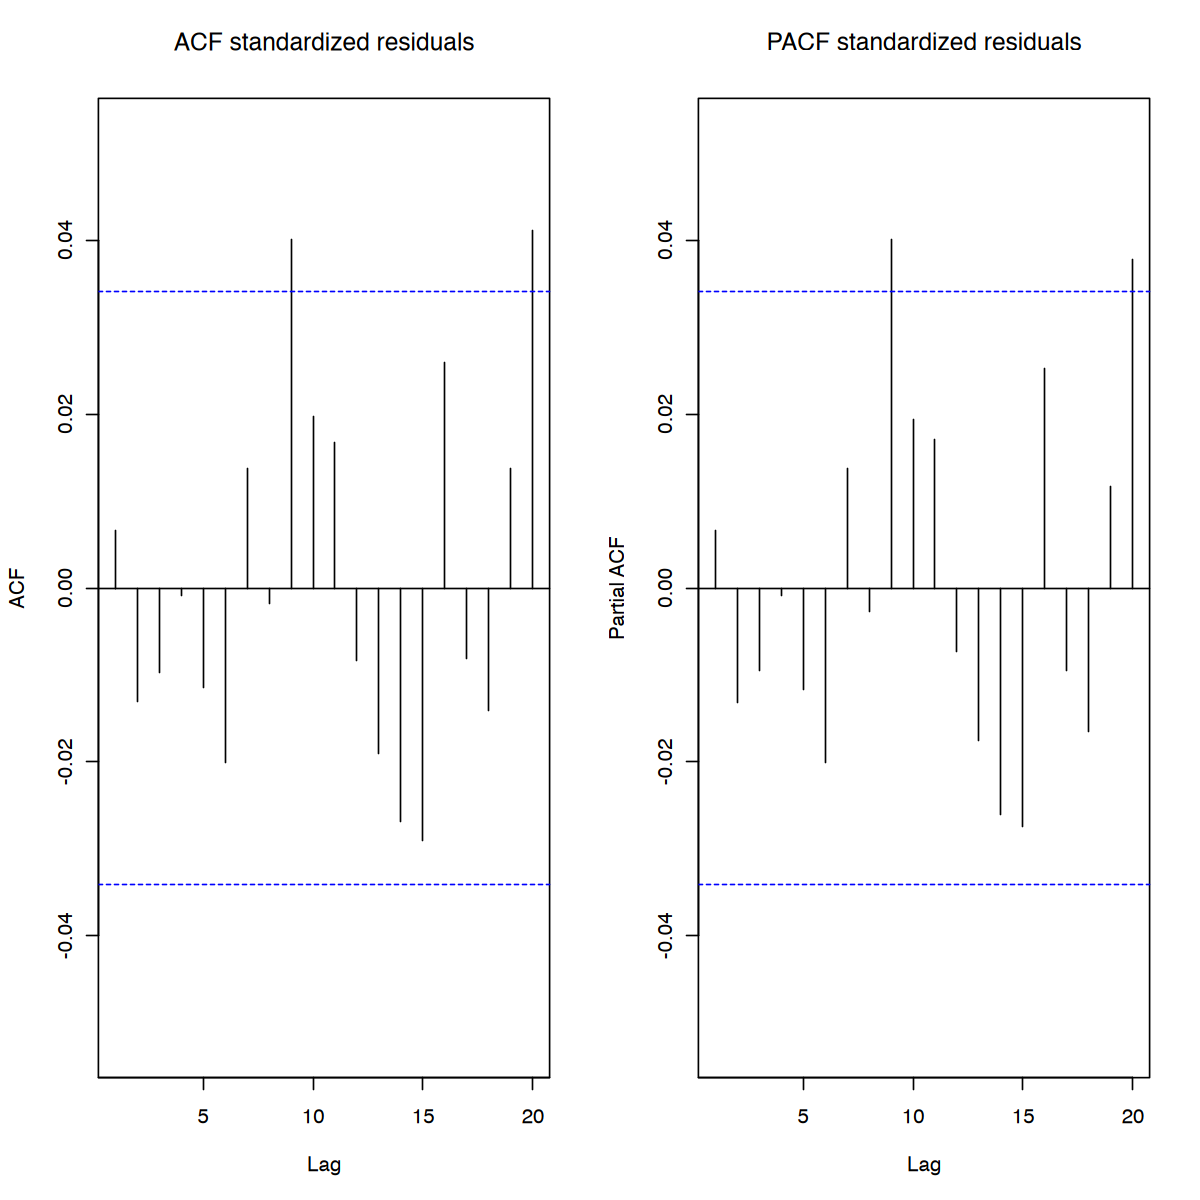

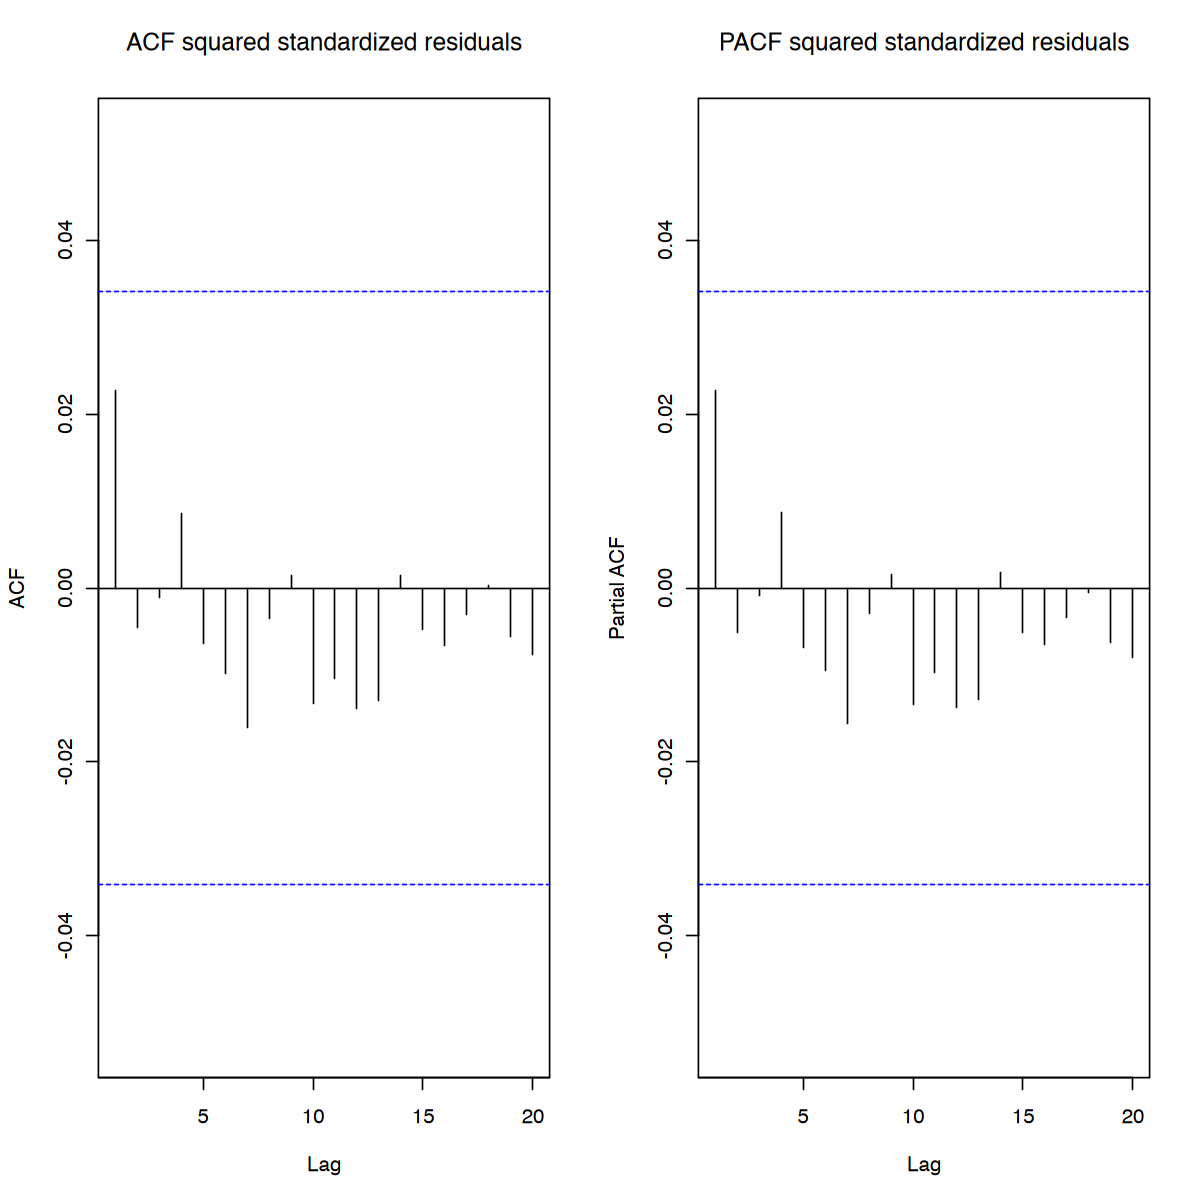

In [65]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

In [66]:
coef(fit)['shape']

shape 
3.573976

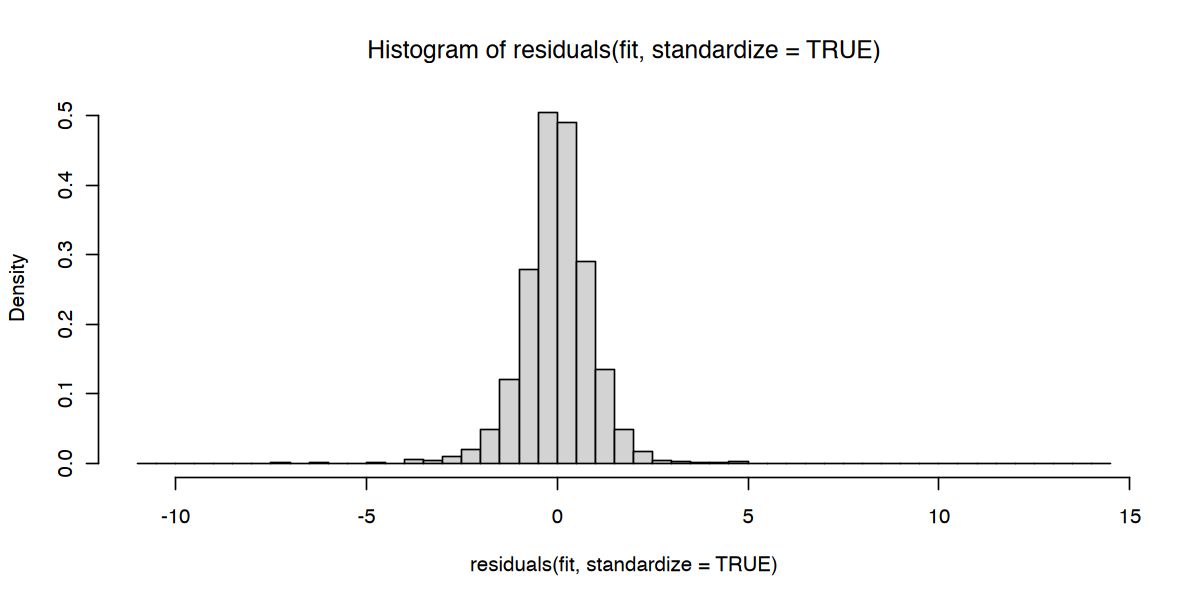

In [67]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)

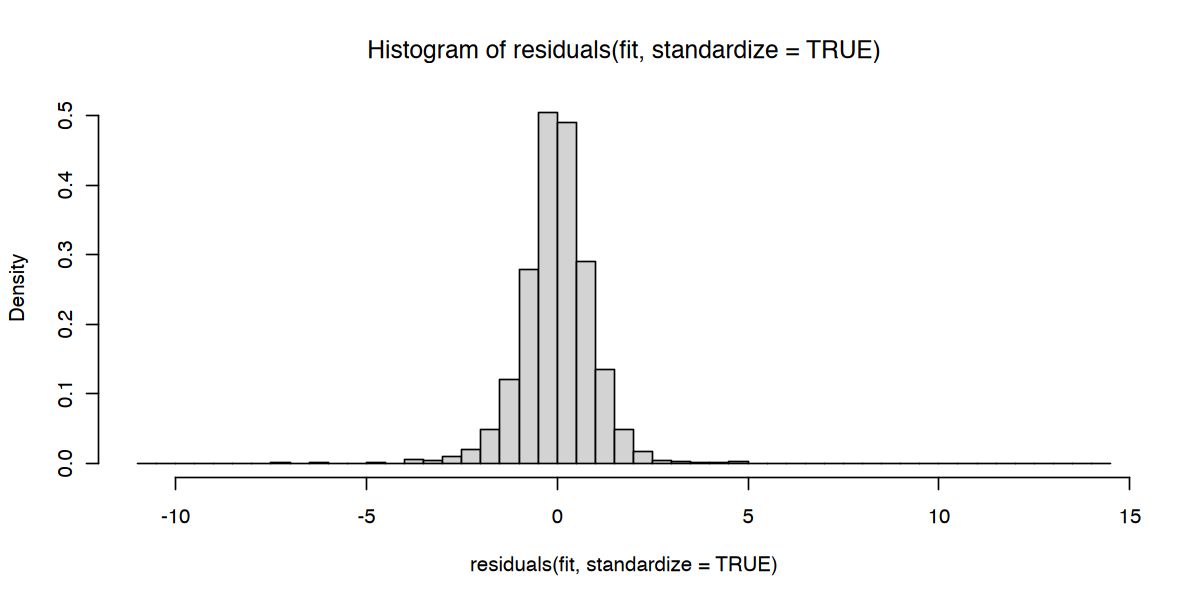

In [68]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)


In [69]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.573976 


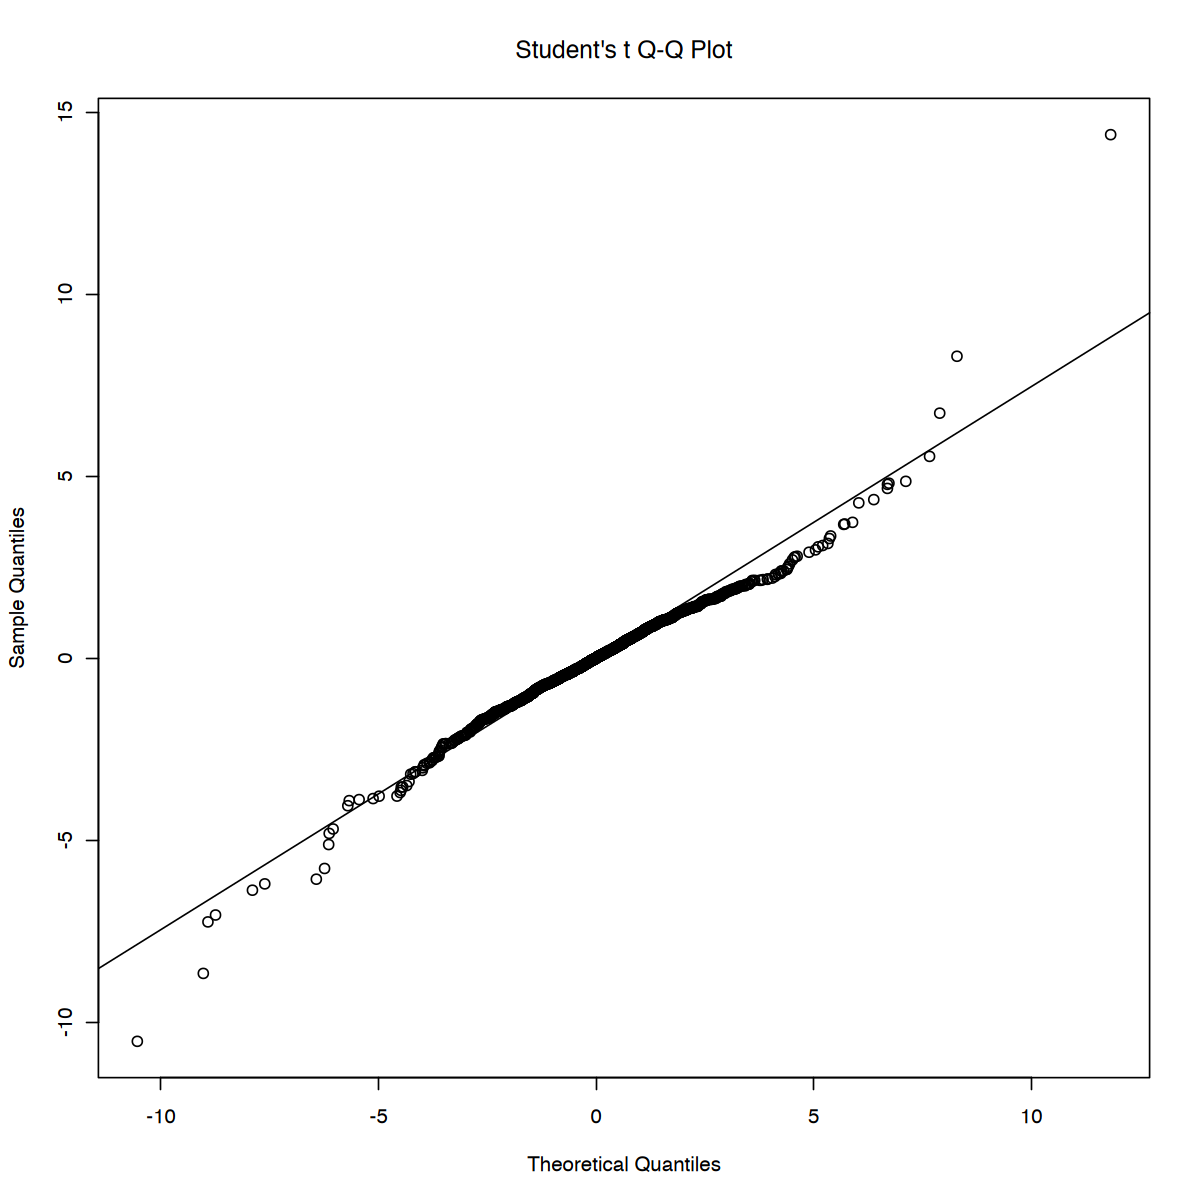

In [70]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

## eGARCH(p,q) - t-dist a norm

In [71]:
p_max <- 4
q_max <- 4
ic_min <- Inf
best_p <- 0
best_q <- 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        print(i1, i2)
        model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "eGARCH", garchOrder = c(1, 1)), distribution.model = "std")
        fit <- ugarchfit(spec = model_specification, data = log_ret)
        inf_crit <- infocriteria(fit)[1] # 1 for aic, 2 for bic, 3 Shibata, 4 Hannan-Quinn
        ic_min <- ifelse(inf_crit < ic_min, inf_crit, ic_min)
        
        best_p <- ifelse(inf_crit == ic_min, i1, best_p)
        best_q <- ifelse(inf_crit == ic_min, i2, best_q)
    }
}

c(best_p, best_q)

[1] 1
[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3
[1] 3
[1] 4
[1] 4
[1] 4
[1] 4


[1] 4 4

In [72]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "eGARCH", garchOrder = c(4, 4)),
                                 distribution.model = "std") # distribution.model = "norm")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# explore the results
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(4,4)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000400    0.000227  1.7665e+00 0.077314
omega  -0.005303    0.000354 -1.4992e+01 0.000000
alpha1 -0.088463    0.018827 -4.6987e+00 0.000003
alpha2 -0.019480    0.005263 -3.7014e+00 0.000214
alpha3 -0.001551    0.005491 -2.8242e-01 0.777621
alpha4  0.105079    0.019330  5.4362e+00 0.000000
beta1   0.585548    0.000001  7.0265e+05 0.000000
beta2   0.551408    0.000000  2.4968e+06 0.000000
beta3   0.727367    0.000000  5.1985e+06 0.000000
beta4  -0.864979    0.000001 -1.2319e+06 0.000000
gamma1  0.245972    0.009492  2.5913e+01 0.000000
gamma2  0.077057    0.006601  1.1673e+01 0.000000
gamma3 -0.061792    0.005942 -1.0399e+01 0

##  * iGARCH - note! structural breaks shoudld be tested

In [73]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), 
                      variance.model = list(model = "iGARCH", garchOrder = c(1, 1)),
                                 distribution.model = "norm")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000034    0.000005   7.1230        0
alpha1  0.267407    0.026932   9.9291        0
beta1   0.732593          NA       NA       NA

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000034    0.000016   2.2125 0.026931
alpha1  0.267407    0.072890   3.6686 0.000244
beta1   0.732593          NA       NA       NA

LogLikelihood : 8338.006 

Information Criteria
------------------------------------
                    
Akaike       -5.0308
Bayes        -5.0271
Shibata      -5.0308
Hannan-Quinn -5.0295

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
           

In [74]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "iGARCH", garchOrder = c(1, 1)),
                                 distribution.model = "std")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000231   2.3604 0.018256
omega   0.000012    0.000002   7.6841 0.000000
alpha1  0.133708    0.014613   9.1500 0.000000
beta1   0.866292          NA       NA       NA
shape   3.343974    0.151195  22.1170 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000230   2.3631 0.018124
omega   0.000012    0.000001  12.4604 0.000000
alpha1  0.133708    0.016790   7.9635 0.000000
beta1   0.866292          NA       NA       NA
shape   3.343974    0.169960  19.6751 0.000000

LogLikelihood : 8813.466 

Information Criteria
------------------------------------
                 

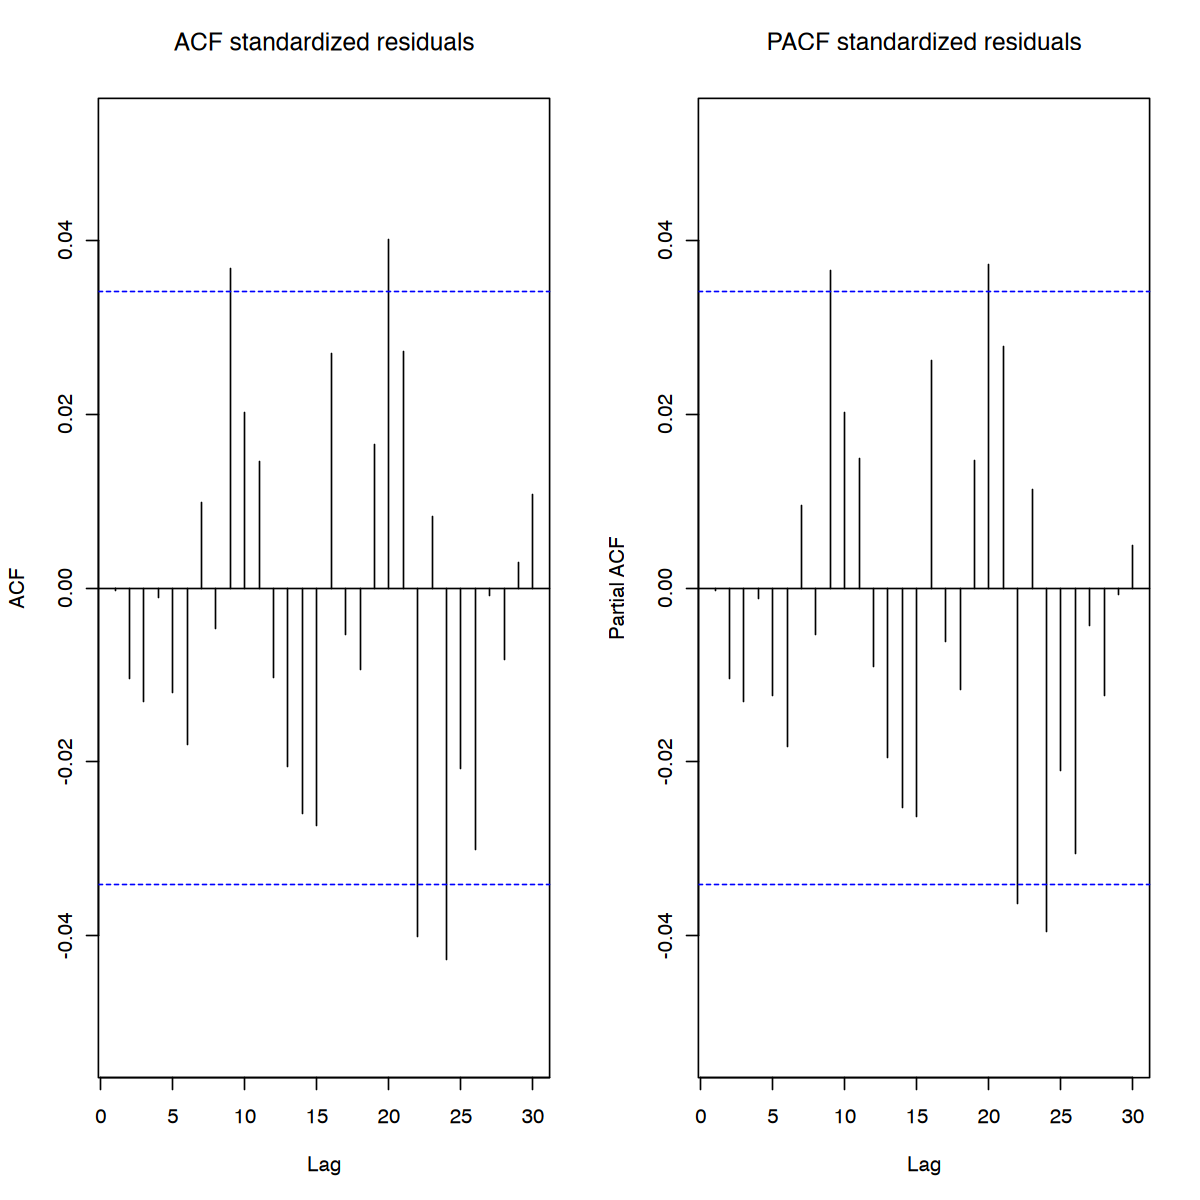

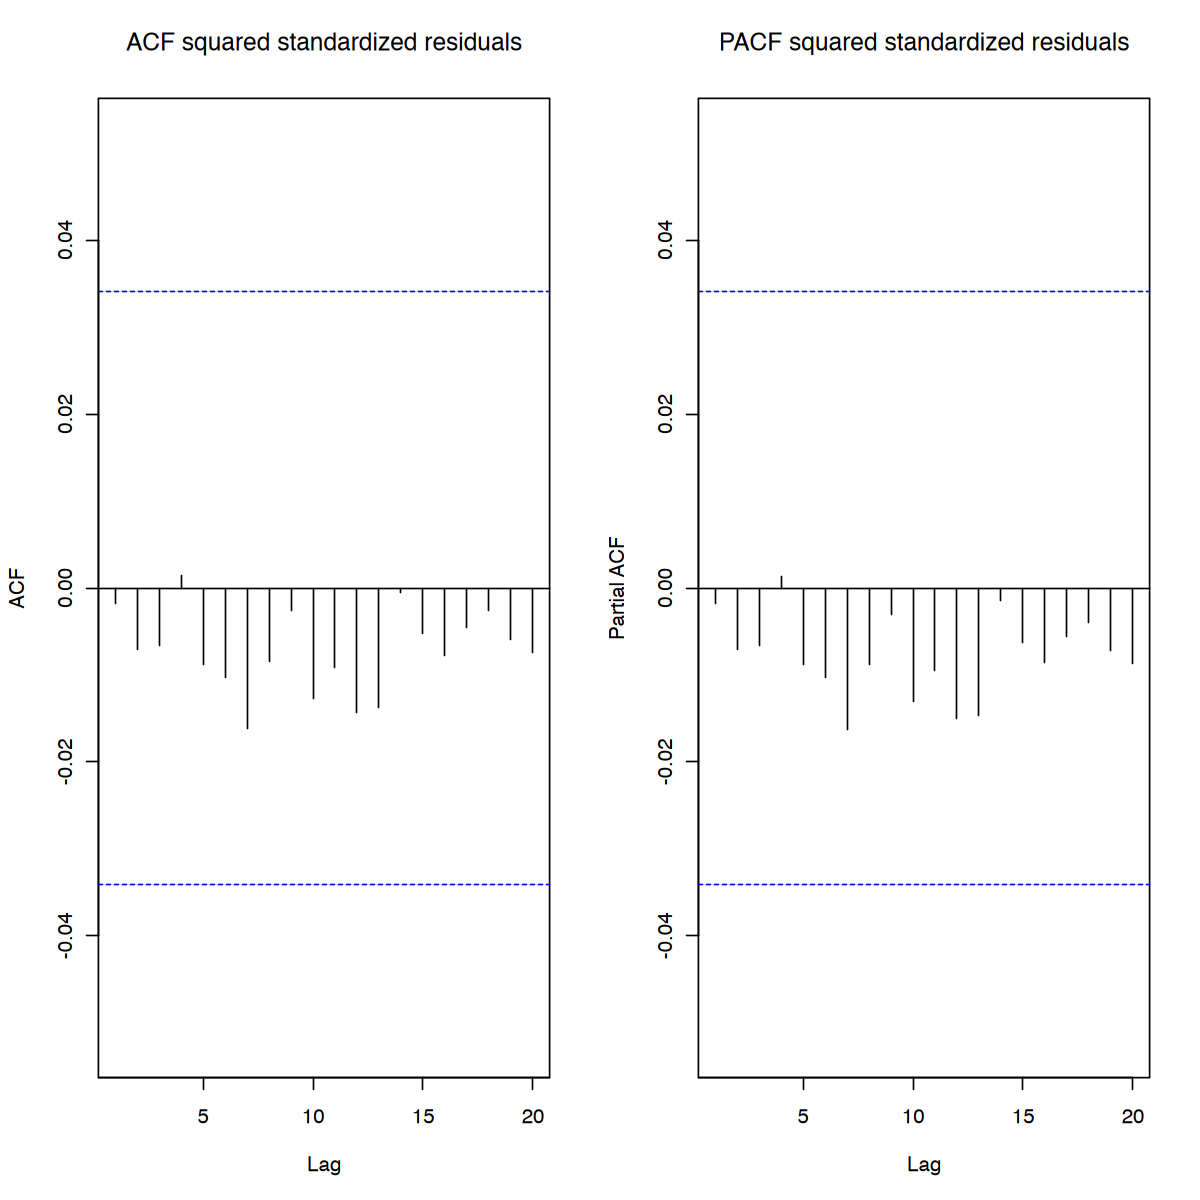

In [75]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 30, main="ACF standardized residuals")
Pacf(res, lag.max = 30, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

In [76]:
Box.test(res, type = "Ljung-Box", lag = 4) 
Box.test(res, type = "Ljung-Box", lag = 8)
Box.test(res, type = "Ljung-Box", lag = 25)


	Box-Ljung test

data:  res
X-squared = 0.92277, df = 4, p-value = 0.9213



	Box-Ljung test

data:  res
X-squared = 2.8679, df = 8, p-value = 0.9424



	Box-Ljung test

data:  res
X-squared = 40.539, df = 25, p-value = 0.02565


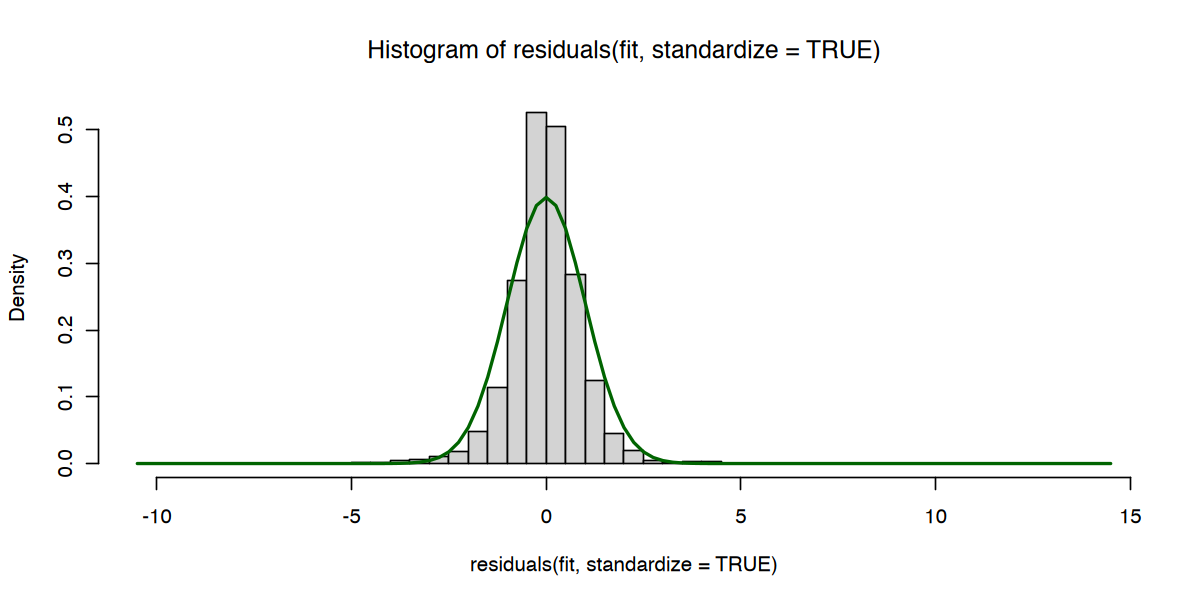

In [77]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

In [78]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.343974 


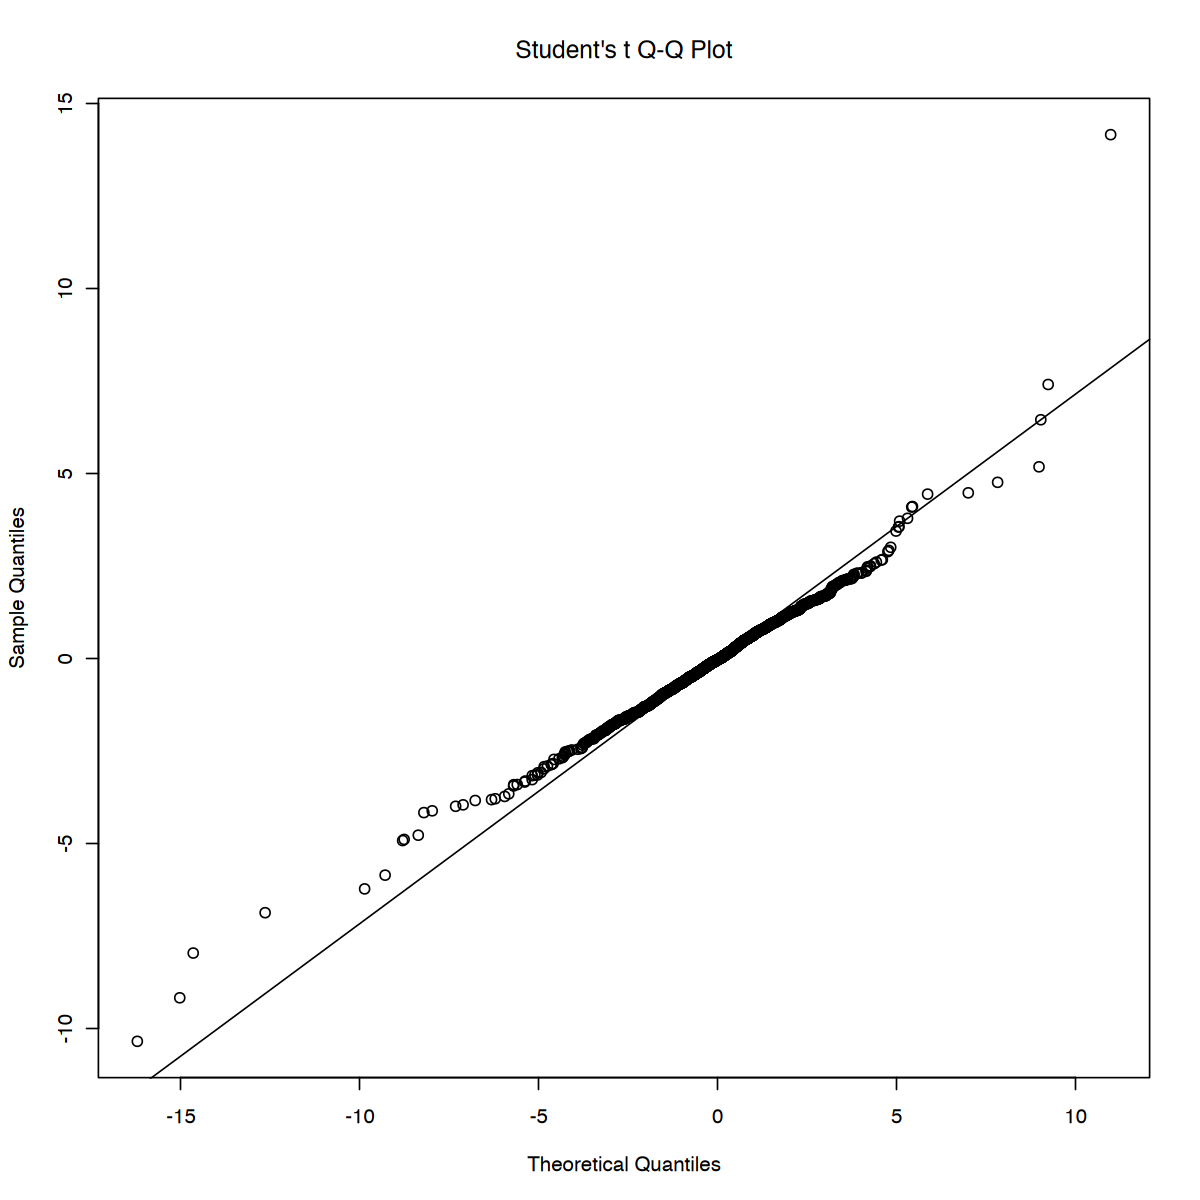

In [79]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

##  * apGARCH

In [80]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE), 
                      variance.model = list(model = "apARCH", garchOrder = c(1, 1)),
                                 distribution.model = "norm")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: apARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.007819    0.003457   2.2616 0.023725
alpha1  0.152332    0.014393  10.5840 0.000000
beta1   0.791964    0.020205  39.1967 0.000000
gamma1  0.239073    0.070033   3.4137 0.000641
delta   0.651212    0.101908   6.3902 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.007819    0.008201  0.95342 0.340375
alpha1  0.152332    0.029521  5.16009 0.000000
beta1   0.791964    0.051084 15.50319 0.000000
gamma1  0.239073    0.147187  1.62428 0.104316
delta   0.651212    0.216518  3.00766 0.002633

LogLikelihood : 8411.006 

Information Criteria
------------------------------------
                

In [81]:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                      variance.model = list(model = "apARCH", garchOrder = c(1, 1)),
                                 distribution.model = "std")
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: apARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000375    0.000116   3.2312 0.001233
omega   0.001376    0.000723   1.9038 0.056939
alpha1  0.117042    0.015854   7.3824 0.000000
beta1   0.893011    0.015868  56.2792 0.000000
gamma1  0.426996    0.084928   5.0278 0.000000
delta   0.754598    0.110793   6.8109 0.000000
shape   3.590783    0.228031  15.7469 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000375    0.000057   6.5980 0.000000
omega   0.001376    0.000661   2.0828 0.037268
alpha1  0.117042    0.021463   5.4531 0.000000
beta1   0.893011    0.021105  42.3121 0.000000
gamma1  0.426996    0.085843   4.9742 0.000001
delta   0

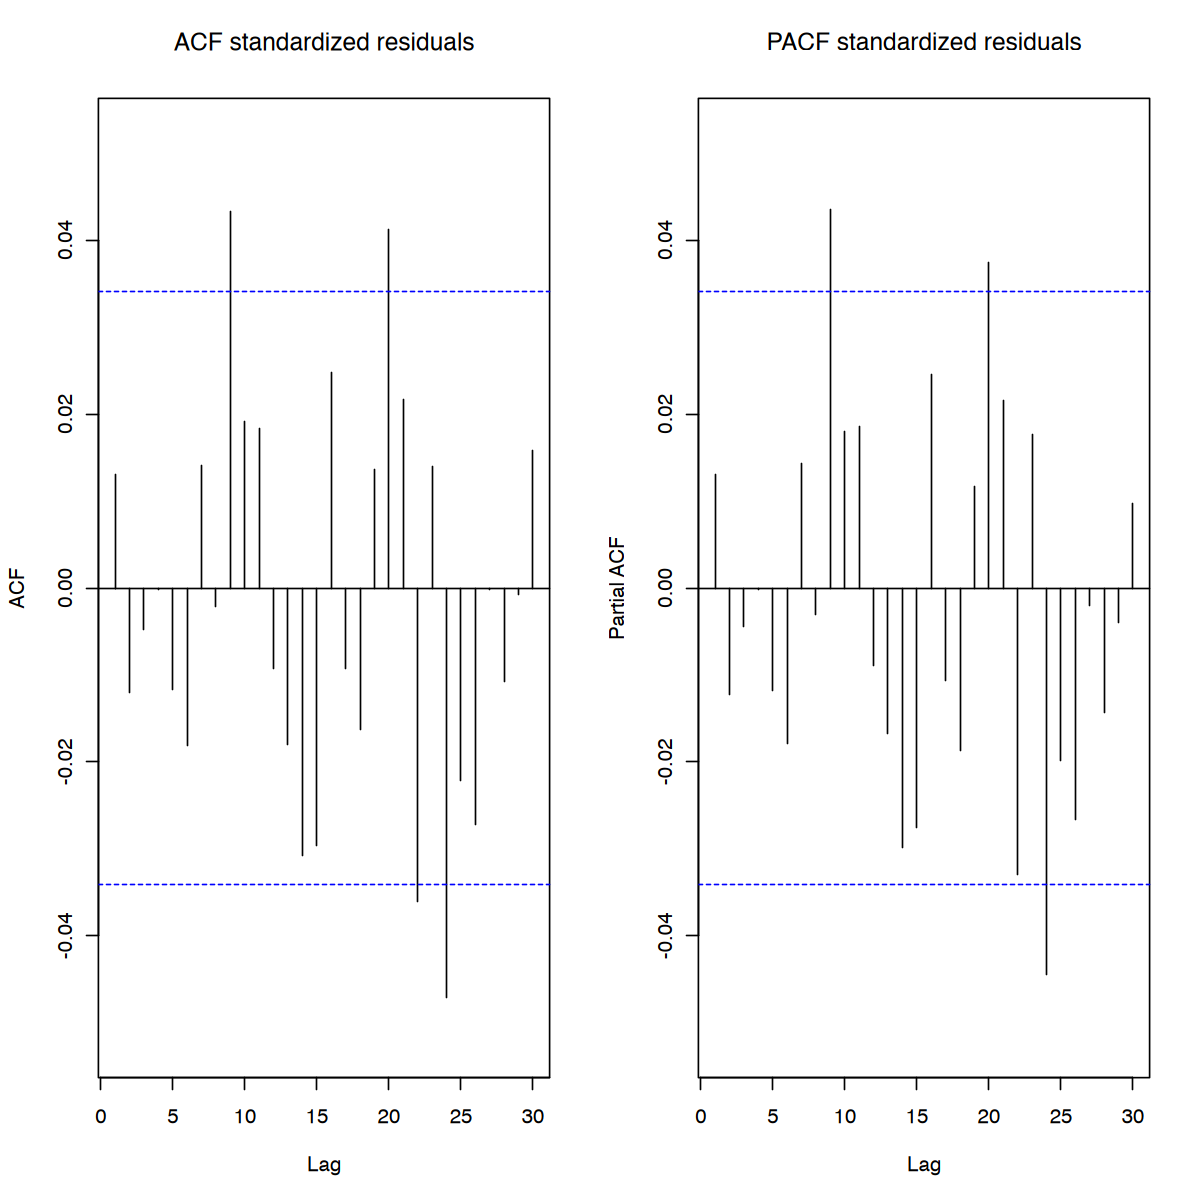

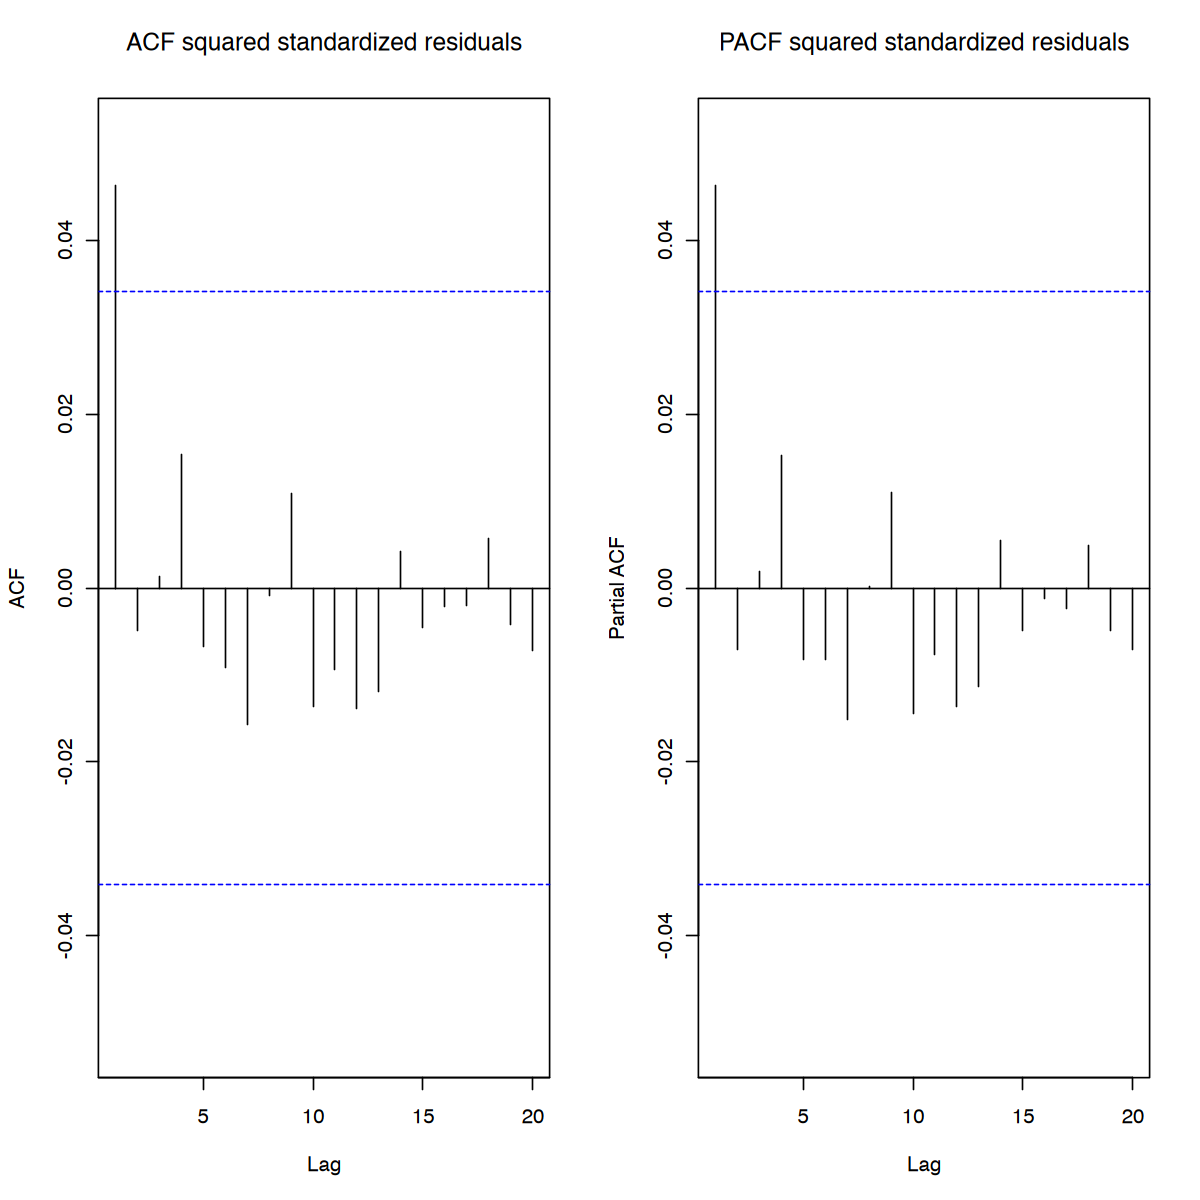

In [82]:
res <- residuals(fit, standardize = TRUE)
sqr_res <- residuals(fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 30, main="ACF standardized residuals")
Pacf(res, lag.max = 30, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

In [83]:
Box.test(res, type = "Ljung-Box", lag = 4) 
Box.test(res, type = "Ljung-Box", lag = 8)
Box.test(res, type = "Ljung-Box", lag = 25)


	Box-Ljung test

data:  res
X-squared = 1.1253, df = 4, p-value = 0.8902



	Box-Ljung test

data:  res
X-squared = 3.3487, df = 8, p-value = 0.9106



	Box-Ljung test

data:  res
X-squared = 44.451, df = 25, p-value = 0.00965


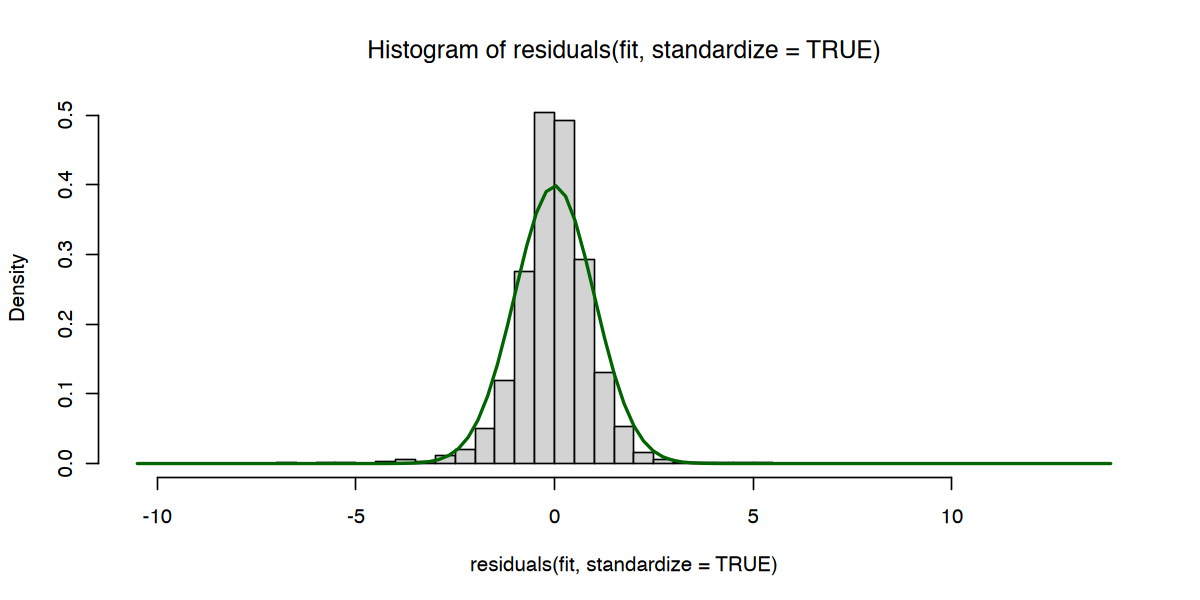

In [84]:
options(repr.plot.width=10, repr.plot.height=5)
hist(residuals(fit, standardize = TRUE),freq=FALSE, nclass=40)
curve(dnorm(x, mean=0, sd=1), 
      col="darkgreen", lwd=2, add=TRUE, yaxt="n")

In [85]:
shape_value <- coef(fit)["shape"]
print(shape_value)
n_resid <- length(residuals(fit)) 

   shape 
3.590783 


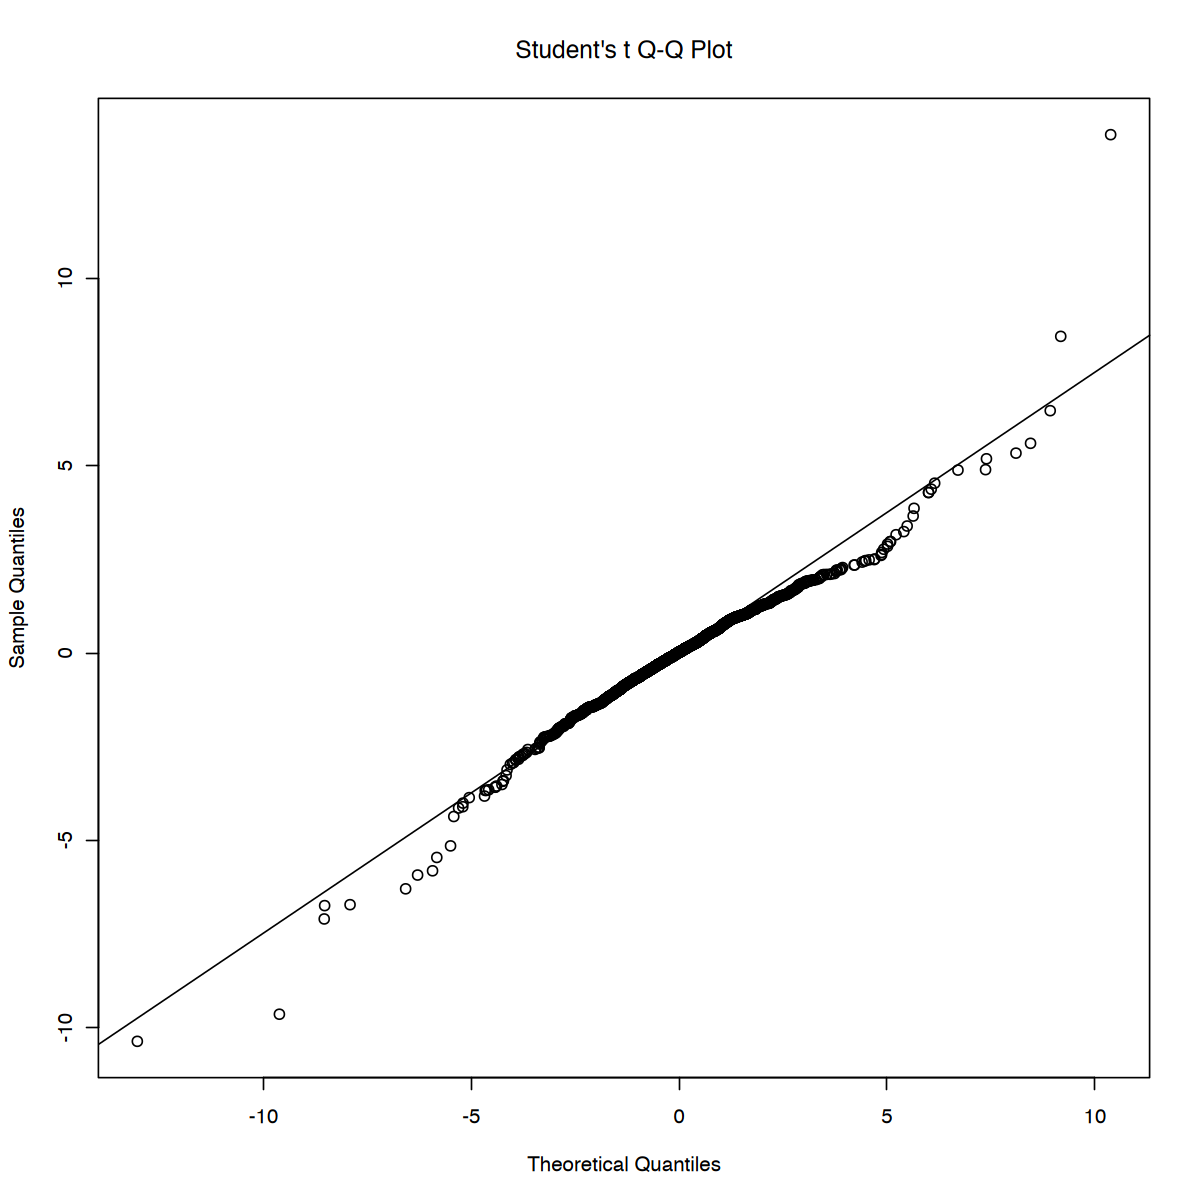

In [86]:
options(repr.plot.width=10, repr.plot.height=10)
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(fit) / sigma(fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(fit)/ sigma(fit)))

## simmulation - very slow!

In [87]:
Box.test(res, type = "Ljung-Box", lag = 25)$p.value
infocriteria(fit)[1]

[1] 0.009650409

[1] -5.341704

In [88]:
qcom_data <- cbind(qcom_data, rep(0, length(qcom_data[, 1])))
qcom_data[which(qcom_data[, 1] >= as.Date("2020-03-01")), 3] <- 1

In [89]:
garch_orders <- list(c(1,1), c(1,2), c(2,1), c(2,2), c(1,3), c(3,1), c(3,3))
arma_orders <- list(c(0,0), c(1,0), c(0,1), c(1,1))
distributions <- c("ged", "sstd", "norm", "snorm", "std", "sged")
models <- c("sGARCH", "eGARCH", "gjrGARCH", "iGARCH", "apARCH")
external_regressors = list(NULL, as.matrix(qcom_data[, 3]))


In [90]:
# results_df <- data.frame(Model = character(), P_Value = numeric(), AIC = numeric(), BIC = numeric(), stringsAsFactors = FALSE)

# for(model in models) {
#   for(garch_order in garch_orders) {
#     for(arma_order in arma_orders) {
#       for(dist in distributions) {
#         for(ext_reg in external_regressors) { 
    
#           spec <- ugarchspec(mean.model = list(armaOrder = arma_order, include.mean = TRUE, external.regressors = ext_reg),
#                              variance.model = list(model = model, garchOrder = garch_order),
#                              distribution.model = dist)
#           fit_result <- tryCatch({
#             fit <- ugarchfit(spec = spec, data = log_ret)
#             res <- residuals(fit, standardize = TRUE)
#             if (length(res) > 25) {
#               lb_test <- Box.test(res, type = "Ljung-Box", lag = 25)
#               p_value <- lb_test$p.value
#               aic_value <- infocriteria(fit)[1]
#               bic_value <- infocriteria(fit)[2]
#               c(p_value, aic_value, bic_value)
#             } else {
#               c(NA, NA, NA)
#             }
#           }, error = function(e) {
#             c(NA, NA, NA)
#           })

#           reg_suffix <- ifelse(is.null(ext_reg), "", "-ext")
#           results_df <- results_df %>% 
#             add_row(Model = paste(model, garch_order, arma_order, dist, reg_suffix, sep = "-")[1], 
#                     P_Value = fit_result[1], AIC = fit_result[2], BIC = fit_result[3])
#         }
#       }
#     }
#   }
# }

In [91]:
results_df = readRDS(file = "results_df.rds")

In [92]:
summary(results_df)

    Model              P_Value              AIC              BIC        
 Length:1680        Min.   :0.000000   Min.   :-5.344   Min.   :-5.329  
 Class :character   1st Qu.:0.005065   1st Qu.:-5.316   1st Qu.:-5.300  
 Mode  :character   Median :0.010700   Median :-5.288   Median :-5.272  
                    Mean   :0.012530   Mean   :-5.222   Mean   :-5.205  
                    3rd Qu.:0.019027   3rd Qu.:-5.067   3rd Qu.:-5.050  
                    Max.   :0.038267   Max.   :-4.676   Max.   :-4.650  
                    NA's   :16         NA's   :16       NA's   :16      

In [93]:
saveRDS(results_df, file = "results_df.rds")

In [94]:
head(results_df[order(-results_df$P_Value, na.last = TRUE), ])

,Model,P_Value,AIC,BIC
,<chr>,<dbl>,<dbl>,<dbl>
916,gjrGARCH-3-0-sstd--ext,0.03826706,-5.322023,-5.299913
964,gjrGARCH-3-0-sstd--ext,0.03823775,-5.320816,-5.295022
915,gjrGARCH-3-0-sstd-,0.03818952,-5.322624,-5.302357
963,gjrGARCH-3-0-sstd-,0.03818251,-5.321417,-5.297465
970,gjrGARCH-3-0-std--ext,0.03800186,-5.321066,-5.297114
921,gjrGARCH-3-0-std-,0.03799367,-5.322876,-5.304451


In [95]:
head(results_df[order(results_df$AIC, na.last = TRUE), ], 10)

,Model,P_Value,AIC,BIC
,<chr>,<dbl>,<dbl>,<dbl>
663,eGARCH-3-1-sstd-,0.005986913,-5.343759,-5.316122
669,eGARCH-3-1-std-,0.006747137,-5.343548,-5.317753
664,eGARCH-3-1-sstd--ext,0.005979917,-5.343187,-5.313708
670,eGARCH-3-1-std--ext,0.006797723,-5.342961,-5.315324
1575,apARCH-1-1-sstd-,0.004708608,-5.342892,-5.320782
1569,apARCH-1-0-std-,0.004099267,-5.342354,-5.323929
1563,apARCH-1-0-sstd-,0.003724013,-5.342330,-5.322063
1557,apARCH-1-1-std-,0.004408713,-5.342185,-5.323760
1539,apARCH-1-0-sstd-,0.011160535,-5.342133,-5.323708


In [96]:
head(results_df[order(results_df$BIC, na.last = TRUE), ], 20)

,Model,P_Value,AIC,BIC
,<chr>,<dbl>,<dbl>,<dbl>
1353,apARCH-1-0-std-,0.009650409,-5.341704,-5.328807
1347,apARCH-1-0-sstd-,0.009604278,-5.341792,-5.327052
1377,apARCH-1-0-std-,0.003527146,-5.341772,-5.327032
1365,apARCH-1-1-std-,0.003469437,-5.341735,-5.326995
1401,apARCH-1-0-std-,0.009627024,-5.341559,-5.326819
1354,apARCH-1-0-std--ext,0.009186333,-5.341203,-5.326464
1545,apARCH-1-0-std-,0.011298755,-5.342119,-5.325537
1371,apARCH-1-0-sstd-,0.003857534,-5.341840,-5.325258
1359,apARCH-1-1-sstd-,0.004220666,-5.341814,-5.325232


## GARCH in mean

In [97]:
spec <- ugarchspec(variance.model=list(model = "sGARCH", garchOrder = c(1, 1)),
    mean.model = list(armaOrder=c(0, 0), include.mean = TRUE, archm = TRUE, archpow = 1))

fit <- ugarchfit(spec, log_ret)

fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.001480    0.001332  -1.1111  0.26654
archm   0.101214    0.072439   1.3972  0.16235
omega   0.000043    0.000007   6.5102  0.00000
alpha1  0.157572    0.024466   6.4405  0.00000
beta1   0.759240    0.030247  25.1013  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.001480    0.001248  -1.1867 0.235365
archm   0.101214    0.064493   1.5694 0.116558
omega   0.000043    0.000020   2.1425 0.032154
alpha1  0.157572    0.061906   2.5453 0.010917
beta1   0.759240    0.078821   9.6324 0.000000

LogLikelihood : 8356.34 

Information Criteria
------------------------------------
                 

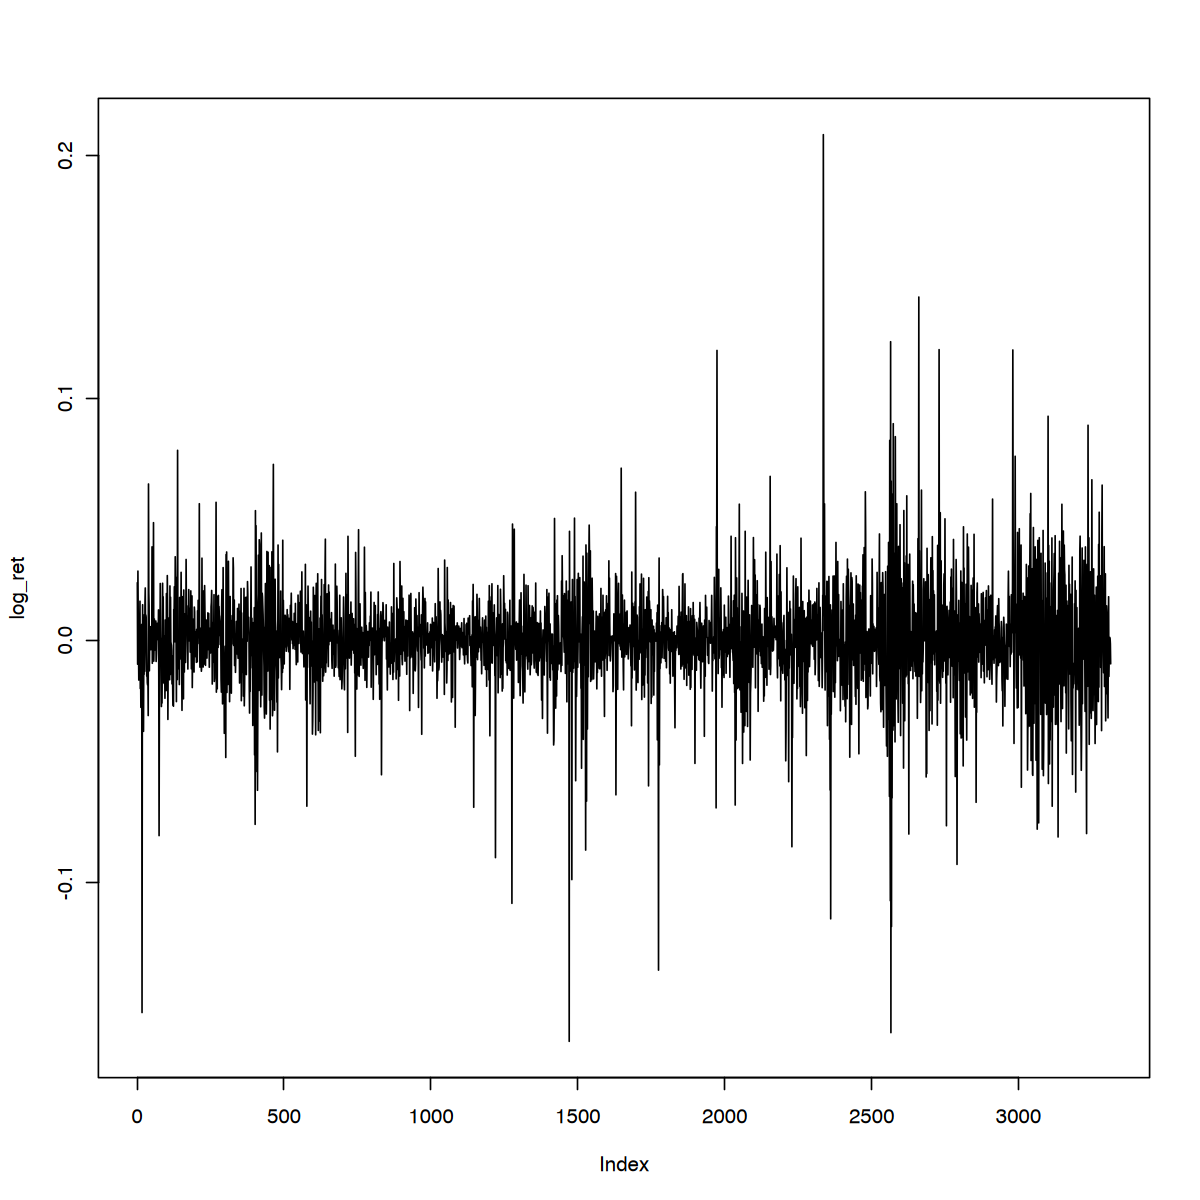

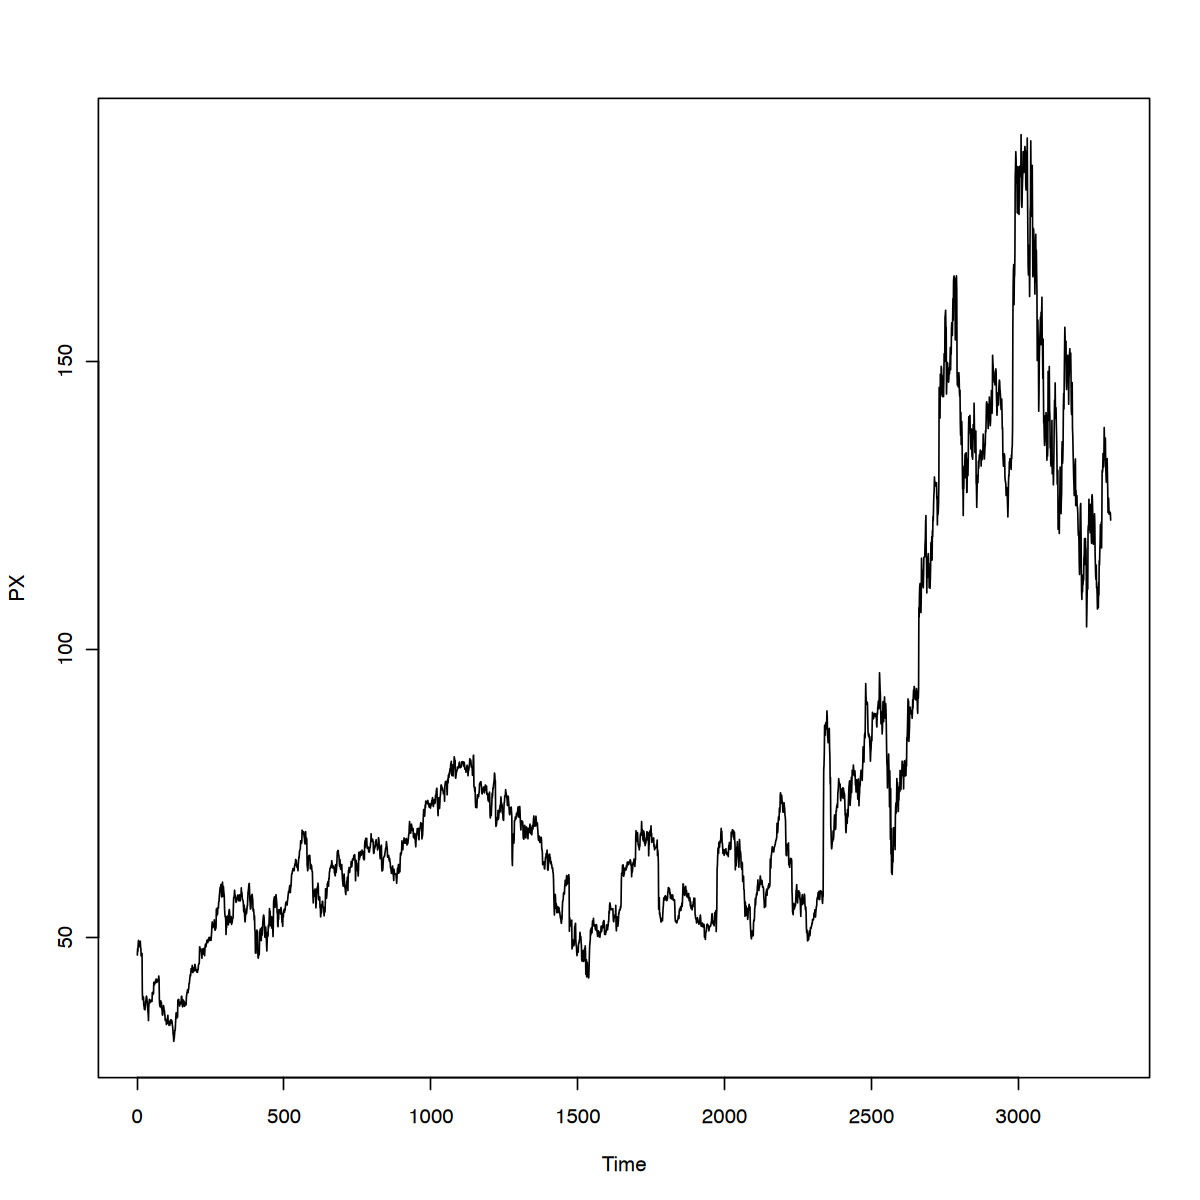

In [98]:
plot(log_ret, type = 'l')
plot.ts(price, ylab = "PX")

In [99]:
head(qcom_data)
tail(qcom_data)
qcom_data <- cbind(qcom_data, Covid_crisis = rep(0, length(qcom_data[, 1])))

,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))"
,<chr>,<dbl>,<dbl>
1,2010-01-04,46.94,0
2,2010-01-05,48.07,0
3,2010-01-06,47.60,0
4,2010-01-07,48.98,0
5,2010-01-08,49.47,0
6,2010-01-11,49.29,0


,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))"
,<chr>,<dbl>,<dbl>
3310,2023-02-27,123.42,1
3311,2023-02-28,123.53,1
3312,2023-03-01,123.68,1
3313,2023-03-02,123.78,1
3314,2023-03-03,123.60,1
3315,2023-03-06,122.41,1


In [100]:
qcom_data$Covid_crisis = as.integer(qcom_data$Index >= as.Date("2020-01-31") & qcom_data$Index <= as.Date("2023-05-11"))

In [101]:
head(qcom_data)

,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis
,<chr>,<dbl>,<dbl>,<int>
1,2010-01-04,46.94,0,0
2,2010-01-05,48.07,0,0
3,2010-01-06,47.60,0,0
4,2010-01-07,48.98,0,0
5,2010-01-08,49.47,0,0
6,2010-01-11,49.29,0,0


In [102]:
gspec5 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1), 
                     external.regressors = as.matrix(qcom_data[, 3])), distribution.model = "sstd") # dummy var

gfit5 <- ugarchfit(gspec5, log_ret)
gfit5


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000267    0.000271   0.9867 0.323791
omega   0.000021    0.000005   4.2022 0.000026
alpha1  0.063112    0.020135   3.1344 0.001722
beta1   0.812311    0.030478  26.6522 0.000000
gamma1  0.143319    0.038496   3.7229 0.000197
vxreg1  0.000049    0.000015   3.3013 0.000962
skew    0.971178    0.022411  43.3358 0.000000
shape   3.574304    0.230924  15.4783 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000267    0.000256   1.0435 0.296740
omega   0.000021    0.000007   2.9152 0.003555
alpha1  0.063112    0.023008   2.7430 0.006088
beta1   0.812311    0.045563  17.8281 0.000000
gamma1

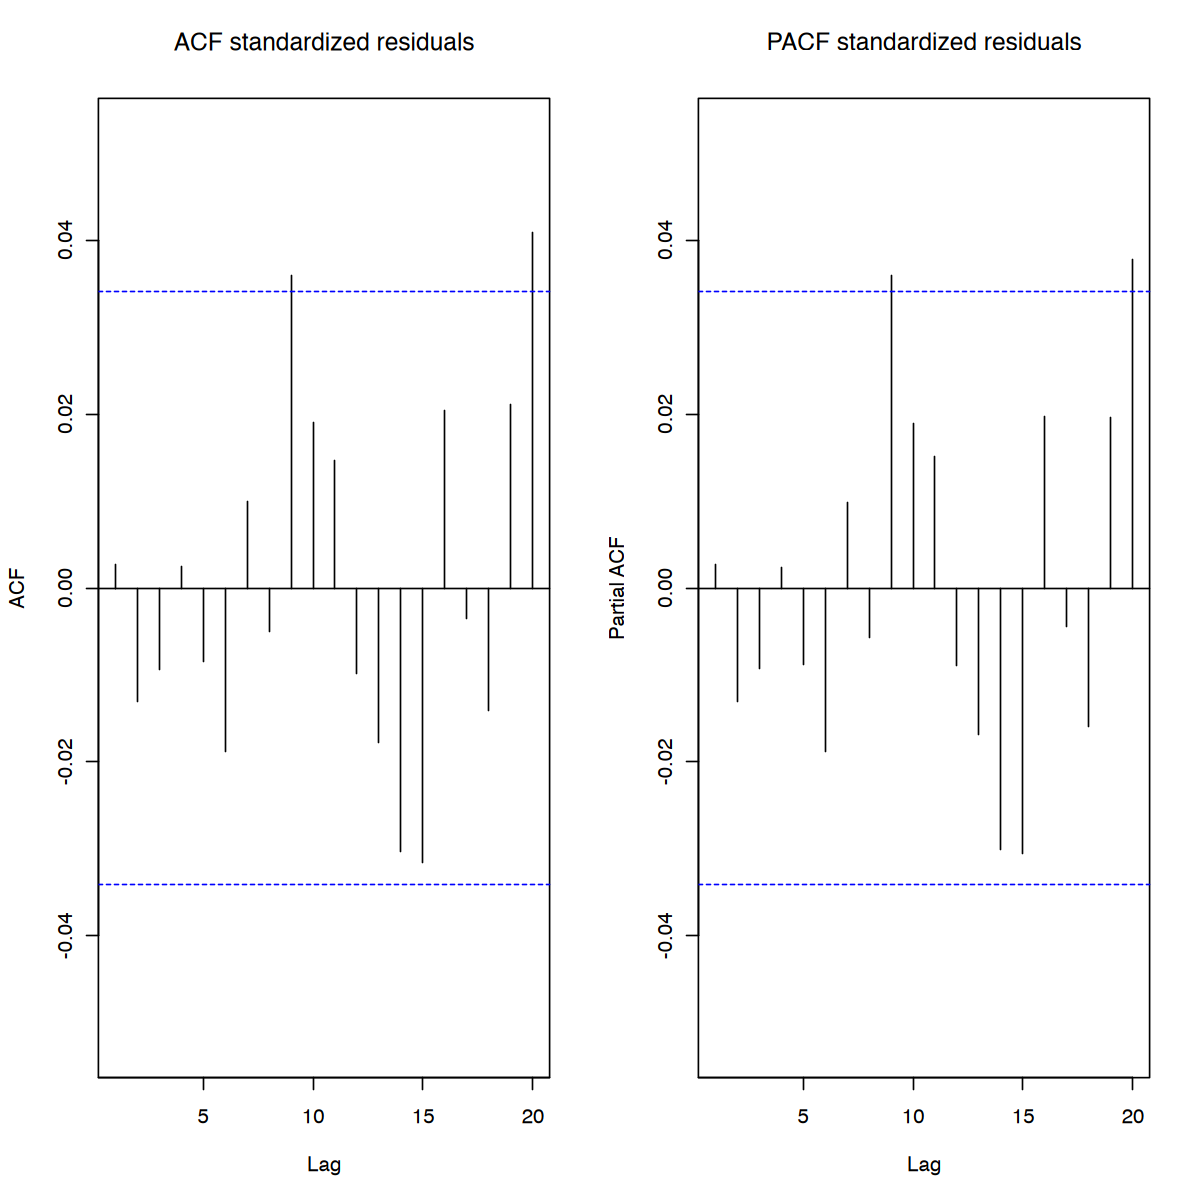

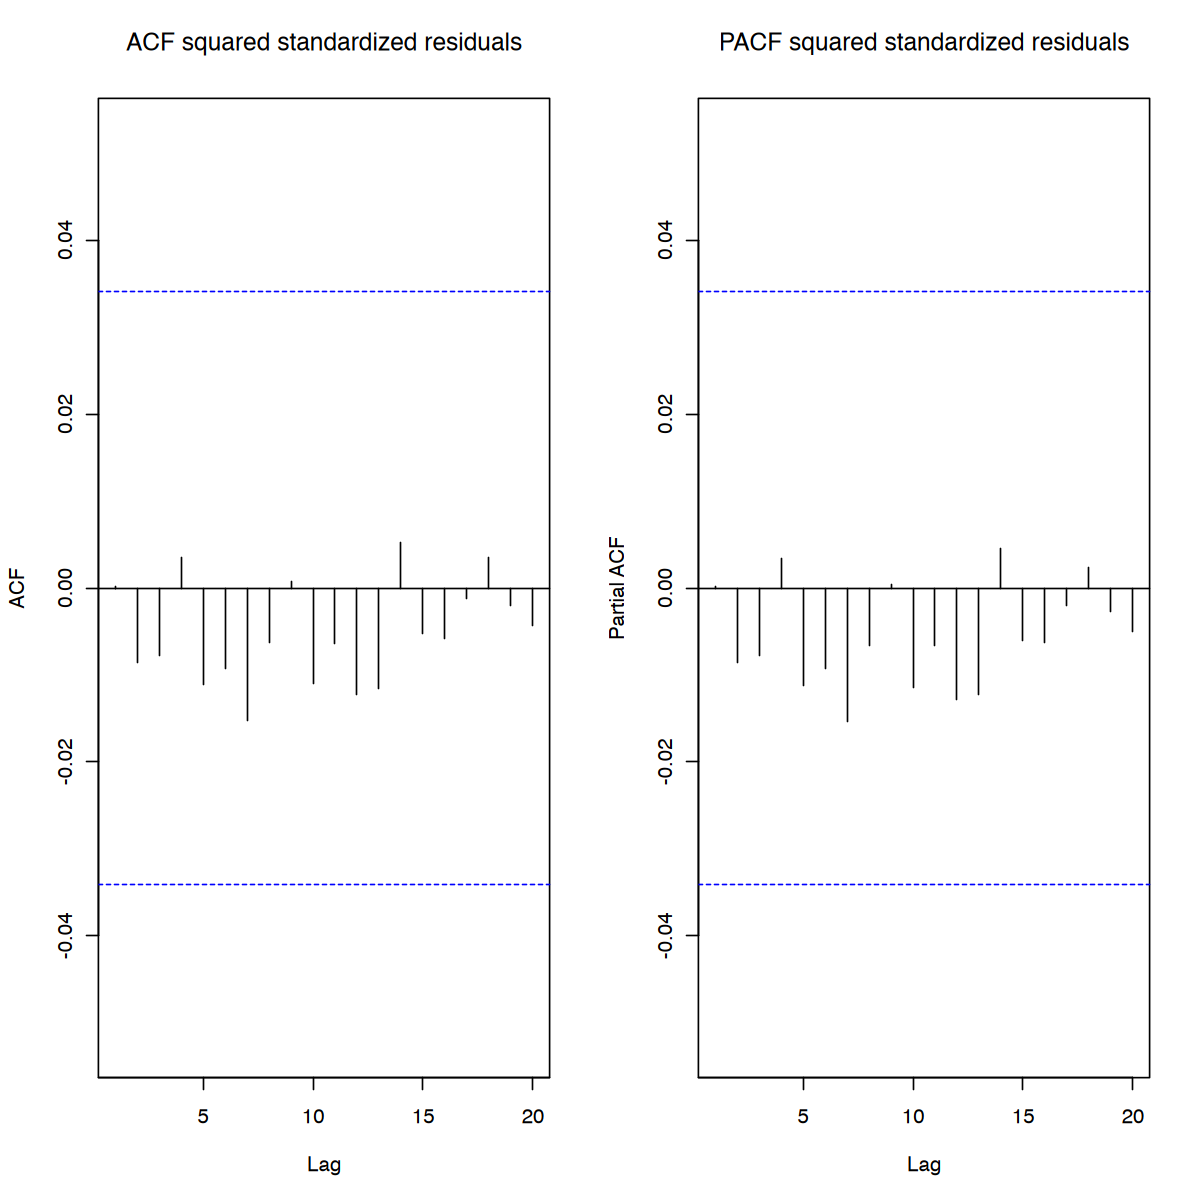

In [103]:
res <- residuals(gfit5, standardize = TRUE)
sqr_res <- residuals(gfit5, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

## Volatility Forecast

In [104]:

qcom_data$log_ret <- c(NA, diff(log(price)))

head(qcom_data)

,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis,log_ret
,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,2010-01-04,46.94,0,0,NA
2,2010-01-05,48.07,0,0,0.023788113
3,2010-01-06,47.60,0,0,-0.009825563
4,2010-01-07,48.98,0,0,0.028579332
5,2010-01-08,49.47,0,0,0.009954394
6,2010-01-11,49.29,0,0,-0.003645204


In [105]:
qcom_data_ret = subset(qcom_data, select = c(Index, log_ret))

In [106]:
qcom_data_ret$Index = as.Date(qcom_data_ret$Index)

In [107]:
# you can specify some special GARCH models using ugarchspec function
daxspec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
daxfit8 <- ugarchfit(spec = daxspec, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(daxfit8)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000232   2.3502 0.018765
omega   0.000012    0.000003   3.8171 0.000135
alpha1  0.122561    0.017206   7.1231 0.000000
beta1   0.867094    0.012514  69.2904 0.000000
shape   3.473609    0.101650  34.1721 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000544    0.000211   2.5838 0.009771
omega   0.000012    0.000009   1.2838 0.199229
alpha1  0.122561    0.056487   2.1697 0.030029
beta1   0.867094    0.028945  29.9570 0.000000
shape   3.473609    0.730116   4.7576 0.000002

LogLikelihood : 8813.833 

Information Criteria
------------------------------------
                 

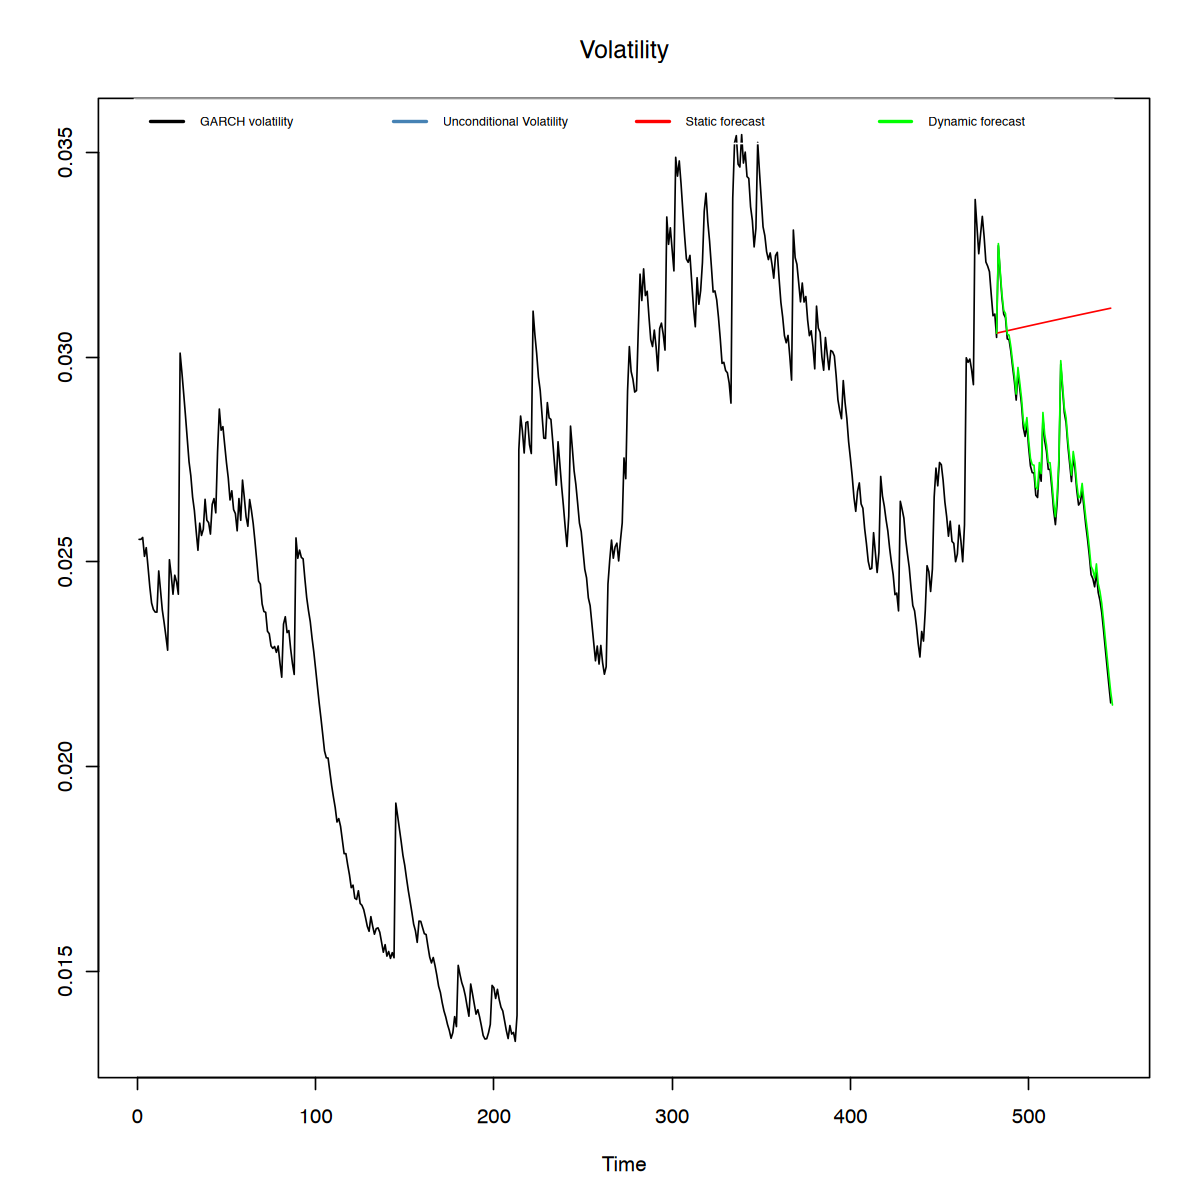

In [108]:
rdax8 <- qcom_data_ret[qcom_data_ret[ ,1] >= as.Date("2021-01-01"),]
rdax <- qcom_data_ret

horizon8 <- 65
l8 <- length(rdax8[, 2])

daxfit8 <- ugarchfit(daxspec, rdax8[, 2], out.sample = horizon8)
daxfit9 <- ugarchfit(daxspec, rdax8[, 2])

UncVol8 <- sqrt(uncvariance(daxfit8))

FGar8 <- ugarchforecast(daxfit8, n.ahead = horizon8)
FDyn8 <- ugarchforecast(daxfit8, n.ahead = 1, n.roll = horizon8)

plot.ts(daxfit9@fit$sigma, ylab = NA, xlim = c(0, l8), main = 'Volatility')
lines(rep(UncVol8, l8), col = 'steelblue')
lines(c(rep(NA, l8 - horizon8), FGar8@forecast$sigma), col = 'red')
lines(c(rep(NA, l8 - horizon8), FDyn8@forecast$sigma), col = 'green')
legend("top", ncol = 4, legend = c('GARCH volatility', 'Unconditional Volatility', 'Static forecast', 
      'Dynamic forecast'), col = c('black', 'steelblue', 'red', 'green'), lwd = 2, 
       box.col = 'white', cex = 0.6, yjust = 0)

In [109]:
rdax = na.omit(rdax)
l = length(rdax[, 2])

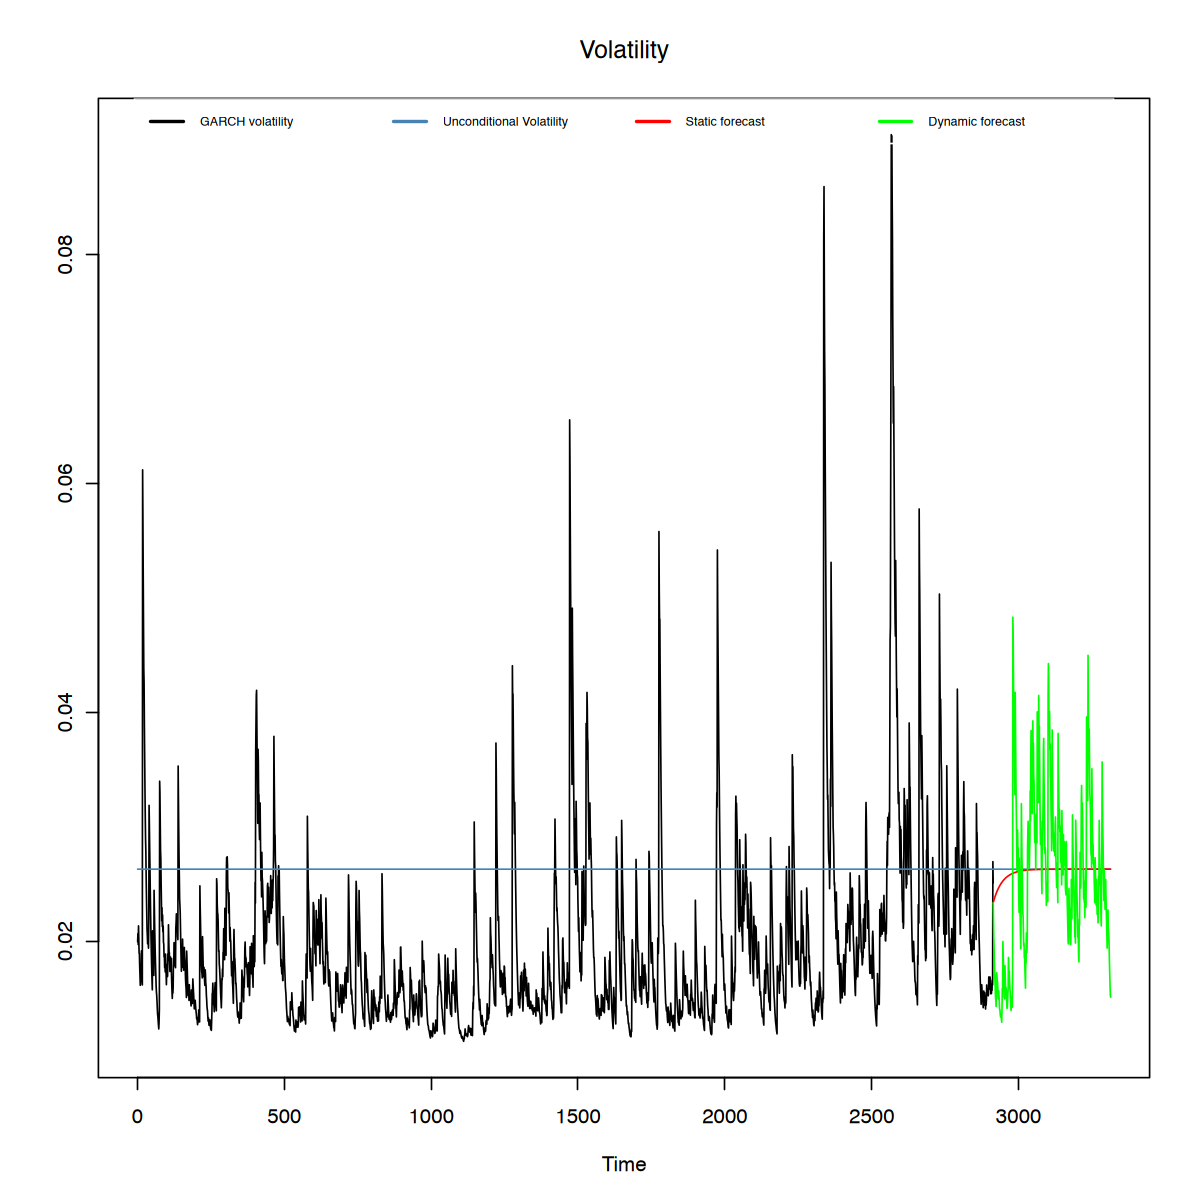

In [110]:
horizon <- 400
daxfit <- ugarchfit(daxspec, rdax[, 2], out.sample = horizon)

UncVol <- sqrt(uncvariance(daxfit))
FGar <- ugarchforecast(daxfit, n.ahead = horizon) # static forecast
FDyn <- ugarchforecast(daxfit, n.ahead = 1, n.roll = horizon) # dynamic forecast, might produce smth useful. 

plot.ts(daxfit@fit$sigma, ylab = NA, xlim = c(0, l), main = 'Volatility')
lines(rep(UncVol, l), col = 'steelblue')
lines(c(rep(NA, l - horizon - 1), FGar@forecast$sigma), col = 'red')
lines(c(rep(NA, l - horizon - 1), FDyn@forecast$sigma), col = 'green')
legend("top", ncol = 4, legend = c('GARCH volatility', 'Unconditional Volatility', 'Static forecast', 
      'Dynamic forecast'), col = c('black', 'steelblue', 'red', 'green'), lwd = 2, 
       box.col = 'white', cex = 0.6, yjust = 0)

##  * GARCH with Event days impact

In [111]:
head(qcom_data)
tail(qcom_data)
qcom_data <- cbind(qcom_data, events = rep(0, length(qcom_data[, 1])))
head(qcom_data)

,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis,log_ret
,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,2010-01-04,46.94,0,0,NA
2,2010-01-05,48.07,0,0,0.023788113
3,2010-01-06,47.60,0,0,-0.009825563
4,2010-01-07,48.98,0,0,0.028579332
5,2010-01-08,49.47,0,0,0.009954394
6,2010-01-11,49.29,0,0,-0.003645204


,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis,log_ret
,<chr>,<dbl>,<dbl>,<int>,<dbl>
3310,2023-02-27,123.42,1,1,-0.0074265600
3311,2023-02-28,123.53,1,1,0.0008908768
3312,2023-03-01,123.68,1,1,0.0012135514
3313,2023-03-02,123.78,1,1,0.0008082034
3314,2023-03-03,123.60,1,1,-0.0014552594
3315,2023-03-06,122.41,1,1,-0.0096744301


,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis,log_ret,events
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,2010-01-04,46.94,0,0,NA,0
2,2010-01-05,48.07,0,0,0.023788113,0
3,2010-01-06,47.60,0,0,-0.009825563,0
4,2010-01-07,48.98,0,0,0.028579332,0
5,2010-01-08,49.47,0,0,0.009954394,0
6,2010-01-11,49.29,0,0,-0.003645204,0


In [112]:
qcom_data$Index <- as.Date(qcom_data$Index)

earnings_dates <- as.Date(c(
  "2024-07-24", "2024-05-01", "2024-01-31", "2023-11-01", "2023-08-02", 
  "2023-05-03", "2023-02-02", "2022-11-02", "2022-07-27", "2022-04-27", 
  "2022-02-02", "2021-11-03", "2021-07-28", "2021-04-28", "2021-02-03", 
  "2020-11-04", "2020-07-29", "2020-04-29", "2020-02-05", "2019-11-06", 
  "2019-07-31", "2019-05-01", "2019-01-30", "2018-11-07", "2018-07-25", 
  "2018-04-25", "2018-01-31", "2017-11-03", "2017-07-19", "2017-04-19", 
  "2017-01-25", "2016-11-02", "2016-07-20", "2016-04-20", "2016-01-27", 
  "2015-11-04", "2015-07-22", "2015-04-22", "2015-01-28", "2014-11-05", 
  "2014-07-23", "2014-04-23", "2014-01-29", "2013-11-06", "2013-07-24"
))

qcom_data$EarningsWindow <- sapply(qcom_data$Index, function(x) any(abs(x - earnings_dates) <= 3))

In [113]:
length(earnings_dates)

[1] 45

In [114]:
head(qcom_data)

,Index,QCOM.Close,"rep(0, length(qcom_data[, 1]))",Covid_crisis,log_ret,events,EarningsWindow
,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<lgl>
1,2010-01-04,46.94,0,0,NA,0,FALSE
2,2010-01-05,48.07,0,0,0.023788113,0,FALSE
3,2010-01-06,47.60,0,0,-0.009825563,0,FALSE
4,2010-01-07,48.98,0,0,0.028579332,0,FALSE
5,2010-01-08,49.47,0,0,0.009954394,0,FALSE
6,2010-01-11,49.29,0,0,-0.003645204,0,FALSE


In [115]:
gspec5 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1), 
                     external.regressors = as.matrix(qcom_data[, c("EarningsWindow", "Covid_crisis")])), distribution.model = "std") # dummy var

gfit5 <- ugarchfit(gspec5, log_ret)
gfit5


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000446    0.000231   1.9273 0.053940
omega   0.000030    0.000007   4.2622 0.000020
alpha1  0.073007    0.024805   2.9433 0.003248
beta1   0.739332    0.042357  17.4548 0.000000
gamma1  0.180034    0.045080   3.9936 0.000065
vxreg1  0.000110    0.000040   2.7177 0.006574
vxreg2  0.000072    0.000020   3.5617 0.000368
shape   3.740160    0.256148  14.6016 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000446    0.000219   2.0356 0.041794
omega   0.000030    0.000012   2.5466 0.010877
alpha1  0.073007    0.029209   2.4995 0.012438
beta1   0.739332    0.070501  10.4868 0.000000
gamma1 

In [116]:
gspec5 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                     variance.model = list(model = "eGARCH", garchOrder = c(1, 1), 
                     external.regressors = as.matrix(qcom_data[, c("EarningsWindow", "Covid_crisis")])), distribution.model = "std") # dummy var

gfit5 <- ugarchfit(gspec5, log_ret)
gfit5


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000408    0.000236   1.7239 0.084723
omega  -0.534878    0.061744  -8.6629 0.000000
alpha1 -0.079114    0.017118  -4.6217 0.000004
beta1   0.936044    0.007324 127.8102 0.000000
gamma1  0.216419    0.023563   9.1846 0.000000
vxreg1  0.084536    0.042757   1.9771 0.048029
vxreg2  0.075540    0.013449   5.6170 0.000000
shape   3.685003    0.244185  15.0910 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000408    0.000228   1.7893 0.073565
omega  -0.534878    0.043578 -12.2741 0.000000
alpha1 -0.079114    0.019117  -4.1385 0.000035
beta1   0.936044    0.005146 181.9115 0.000000
gamma1  0

## Robustness checks

### ARMAs

In [117]:
# not significant at 5% lvl
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000460    0.000657  0.69992 0.483979
ar1    -0.023624    0.012969 -1.82157 0.068521
omega   0.000014    0.000039  0.34878 0.727258
alpha1  0.072315    0.238001  0.30384 0.761249
beta1   0.857746    0.078095 10.98339 0.000000
gamma1  0.112840    0.011938  9.45196 0.000000
shape   3.501742    2.297492  1.52416 0.127469

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000460    0.020352  0.022605  0.98196
ar1    -0.023624    0.626977 -0.037679  0.96994
omega   0.000014    0.001143  0.011914  0.99049
alpha1  0.072315    6.975580  0.010367  0.99173
beta1   0.857746    2.325272  0.368880  0.71222
g

In [118]:
# also not significant
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 1), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000462    0.000671  0.68783 0.491560
ma1    -0.025070    0.027210 -0.92134 0.356870
omega   0.000014    0.000036  0.38072 0.703411
alpha1  0.072289    0.218554  0.33076 0.740826
beta1   0.857692    0.074074 11.57886 0.000000
gamma1  0.112899    0.039302  2.87258 0.004071
shape   3.502011    2.117191  1.65408 0.098110

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000462    0.016931  0.027276  0.97824
ma1    -0.025070    0.557117 -0.044999  0.96411
omega   0.000014    0.000959  0.014219  0.98865
alpha1  0.072289    5.843929  0.012370  0.99013
beta1   0.857692    1.945213  0.440925  0.65927
g

In [119]:
# they are opposite of each other
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = log_ret)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000523    0.000269   1.94250 0.052077
ar1     0.905364    0.017099  52.94807 0.000000
ma1    -0.922718    0.016834 -54.81146 0.000000
omega   0.000014    0.000014   0.97150 0.331297
alpha1  0.073879    0.086514   0.85395 0.393130
beta1   0.857989    0.032830  26.13413 0.000000
gamma1  0.107990    0.031468   3.43176 0.000600
shape   3.484447    0.835626   4.16986 0.000030

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000523    0.002008   0.260232 0.794685
ar1     0.905364    0.054464  16.623118 0.000000
ma1    -0.922718    0.028095 -32.842388 0.000000
omega   0.000014    0.000148   0.0924

### Narrower Covid period

In [120]:
qcom_data$Covid_crisis = as.integer(qcom_data$Index >= as.Date("2020-01-31") & qcom_data$Index <= as.Date("2023-05-11"))

In [121]:
gspec5 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1), 
                     external.regressors = as.matrix(qcom_data[, c("Covid_crisis")])), distribution.model = "std") # dummy var

gfit5 <- ugarchfit(gspec5, log_ret)
gfit5


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000450    0.000231   1.9455 0.051717
omega   0.000021    0.000005   4.1469 0.000034
alpha1  0.061064    0.020024   3.0496 0.002291
beta1   0.815290    0.030923  26.3647 0.000000
gamma1  0.131750    0.036664   3.5934 0.000326
vxreg1  0.000053    0.000015   3.4198 0.000627
shape   3.560571    0.228644  15.5725 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000450    0.000214   2.1010 0.035639
omega   0.000021    0.000007   2.8789 0.003991
alpha1  0.061064    0.022902   2.6663 0.007669
beta1   0.815290    0.045858  17.7784 0.000000
gamma1  0.131750    0.051031   2.5818 0.009829
vxreg1 

### Wider earnings window

In [122]:

qcom_data$EarningsWindow <- sapply(qcom_data$Index, function(x) any(abs(x - earnings_dates) <= 5))

In [123]:
gspec5 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1), 
                     external.regressors = as.matrix(qcom_data[, c("EarningsWindow")])), distribution.model = "std") # dummy var

gfit5 <- ugarchfit(gspec5, log_ret)
gfit5


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000419    0.000232   1.8090 0.070444
omega   0.000018    0.000004   4.0909 0.000043
alpha1  0.083279    0.023449   3.5515 0.000383
beta1   0.814038    0.029381  27.7063 0.000000
gamma1  0.150797    0.041620   3.6232 0.000291
vxreg1  0.000054    0.000022   2.4178 0.015617
shape   3.613688    0.240911  15.0001 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000419    0.000215   1.9508 0.051079
omega   0.000018    0.000007   2.5125 0.011987
alpha1  0.083279    0.030630   2.7189 0.006551
beta1   0.814038    0.052877  15.3949 0.000000
gamma1  0.150797    0.066078   2.2821 0.022483
vxreg1 

### Trimmed Sample

In [124]:
head(qcom_data_ret)
tail(qcom_data_ret)

,Index,log_ret
,<date>,<dbl>
1,2010-01-04,NA
2,2010-01-05,0.023788113
3,2010-01-06,-0.009825563
4,2010-01-07,0.028579332
5,2010-01-08,0.009954394
6,2010-01-11,-0.003645204


,Index,log_ret
,<date>,<dbl>
3310,2023-02-27,-0.0074265600
3311,2023-02-28,0.0008908768
3312,2023-03-01,0.0012135514
3313,2023-03-02,0.0008082034
3314,2023-03-03,-0.0014552594
3315,2023-03-06,-0.0096744301


In [125]:
qcom_data_ret__sub = qcom_data_ret[qcom_data_ret[ ,1] >= as.Date("2016-07-31"),]$log_ret

In [126]:
head(qcom_data_ret__sub)

[1] -0.0117337037 -0.0204172064  0.0067428923 -0.0004918108  0.0165884435
[6] -0.0067972101

In [127]:
# you can specify some special GARCH models using ugarchspec function
model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                     variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                     distribution.model = "std") # 'norm' normal distribution, 'std' student-t distribution
# estimate the model
fit <- ugarchfit(spec = model_specification, data = qcom_data_ret__sub)

# Explore the results
#coef(fit) # estimated parameters
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000389    0.000382   1.0168 0.309255
omega   0.000019    0.000007   2.7747 0.005525
alpha1  0.104362    0.035504   2.9395 0.003288
beta1   0.839556    0.033861  24.7939 0.000000
gamma1  0.110162    0.052744   2.0886 0.036741
shape   3.477761    0.317509  10.9533 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000389    0.000340   1.1445 0.252401
omega   0.000019    0.000009   2.0509 0.040276
alpha1  0.104362    0.049267   2.1183 0.034149
beta1   0.839556    0.056037  14.9821 0.000000
gamma1  0.110162    0.081540   1.3510 0.176687
shape   3.477761    0.362553   9.5924 0.000000

LogLik

### Out of sample volatility

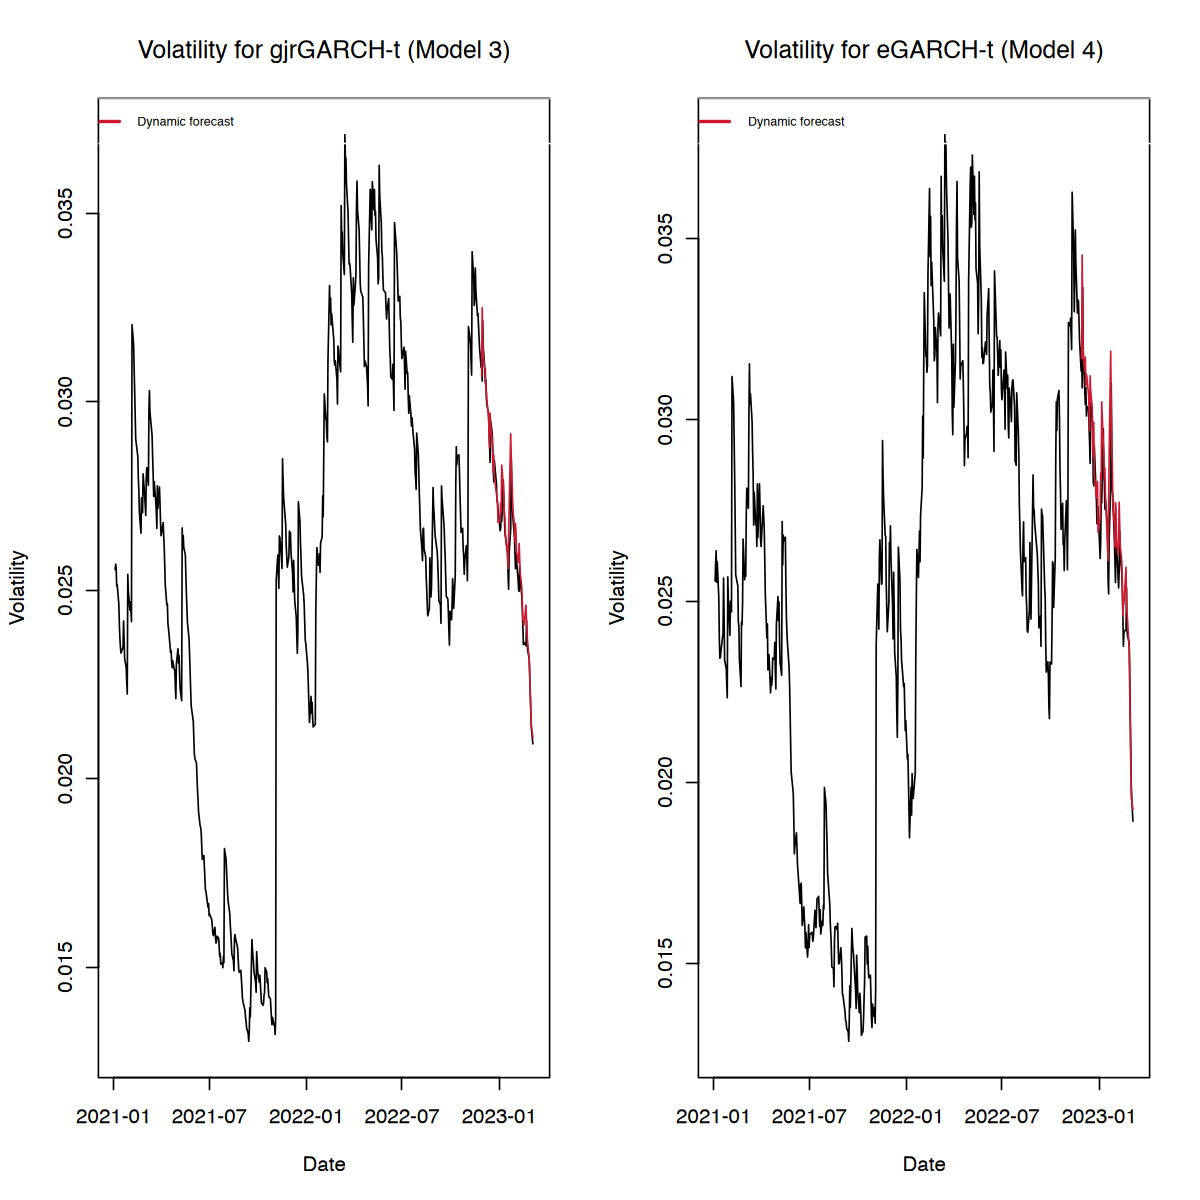

In [128]:
qcom_data$log_ret <- c(NA, diff(log(price)))
qcom_data_ret = subset(qcom_data, select = c(Index, log_ret))
qcom_data_ret$Index = as.Date(qcom_data_ret$Index)
rdax3 <- qcom_data_ret[qcom_data_ret[ ,1] >= as.Date("2021-01-01"),]
horizon3 <- 65
l3 <- length(rdax3[, 1])

model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                                  variance.model = list(model = "gjrGARCH", garchOrder = c(1, 1)),
                                  distribution.model = "std") 
fit3 <- ugarchfit(spec = model_specification, data = rdax3)
fit3_alt = ugarchfit(spec = model_specification, data = rdax3, out.sample = 65)

UncVol3 <- sqrt(uncvariance(fit3_alt))


FGar3 <- ugarchforecast(fit3_alt, n.ahead = horizon3)
FDyn3 <- ugarchforecast(fit3_alt, n.ahead = 1, n.roll = horizon3)
par(mfrow = c(1,2))
# Plot for fit3
plot(rdax3$Index, fit3@fit$sigma, type = 'n', xlab = "Date", ylab = "Volatility", main = "Volatility for gjrGARCH-t (Model 3)")
lines(rdax3$Index, fit3@fit$sigma, col = 'black')
#lines(c(rep(NA, l3 - horizon3), FGar3@forecast$sigma), col = 'red')
dynamic_forecast_dates <- tail(rdax3$Index, 66)
lines(dynamic_forecast_dates, FDyn3@forecast$sigma, col = "#cf1930")
legend("top", ncol = 4, legend = c('gjrGARCH-t volatility',
                                   'Dynamic forecast'), col = c('black', "#cf1930"), lwd = 2, 
       box.col = 'white', cex = 0.6, yjust = 0)


model_specification <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = TRUE), 
                                  variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
                                  distribution.model = "std") 
fit3 <- ugarchfit(spec = model_specification, data = rdax3)
fit3_alt = ugarchfit(spec = model_specification, data = rdax3, out.sample = 65)

UncVol3 <- sqrt(uncvariance(fit3_alt))


FGar3 <- ugarchforecast(fit3_alt, n.ahead = horizon3)
FDyn3 <- ugarchforecast(fit3_alt, n.ahead = 1, n.roll = horizon3)
# Plot for fit3
# Plot for fit3
plot(rdax3$Index, fit3@fit$sigma, type = 'n', xlab = "Date", ylab = "Volatility", main = 'Volatility for eGARCH-t (Model 4)')
lines(rdax3$Index, fit3@fit$sigma, col = 'black')
#lines(c(rep(NA, l3 - horizon3), FGar3@forecast$sigma), col = 'red')
dynamic_forecast_dates <- tail(rdax3$Index, 66)
lines(dynamic_forecast_dates, FDyn3@forecast$sigma, col = "#cf1930")
legend("top", ncol = 4, legend = c('eGARCH-t volatility',
                                   'Dynamic forecast'), col = c('black', "#cf1930"), lwd = 2, 
       box.col = 'white', cex = 0.6, yjust = 0)
